# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Linear-Regression"><b>Analysis</b> - Linear-Regression</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [76]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
import os
import math
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [77]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        
        # determine MCC score
        mcc = matthews_corrcoef(y_test, yhat)
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions, mcc)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    mcc = highestscore[7]
    print('MCC: ', mcc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1, highestscore[7]

def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        
        # determine MCC score
        mcc = matthews_corrcoef(y_test, yhat)
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions, mcc)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    mcc = highestscore[7]
    print('MCC: ', mcc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1, highestscore[7]

def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        
        # determine MCC score
        mcc = matthews_corrcoef(y_test, yhat)
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions, mcc)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    mcc = highestscore[7]
    print('MCC: ', mcc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1, highestscore[7]

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)
    mcc1 = matthews_corrcoef(y_test, predictions1)
    print(f"MCC for model 1: {mcc1}")

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    prec_1 = precision_score(y_test, predictions1)
    print("Precision score for model 1: ", prec_1)
    rec_1 = recall_score(y_test, predictions1)
    print("Recall score for model 1: ", rec_1)
    f1_1 = f1_score(y_test, predictions1)
    print("F1 score for model 1: ", f1_1)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    
    prec_2 = precision_score(y_test, predictions2)
    print("Precision score for model 2: ", prec_2)
    rec_2 = recall_score(y_test, predictions2)
    print("Recall score for model 2: ", rec_2)
    f1_2 = f1_score(y_test, predictions2)
    print("F1 score for model 2: ", f1_2)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    mcc2 = matthews_corrcoef(y_test, predictions2)
    print(f"MCC for model 2: {mcc2}")
    
    return acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)
    mcc1 = matthews_corrcoef(y_test, predictions1)
    print(f"MCC for model 1: {mcc1}")

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    prec_1 = precision_score(y_test, predictions1)
    print("Precision score for model 1: ", prec_1)
    rec_1 = recall_score(y_test, predictions1)
    print("Recall score for model 1: ", rec_1)
    f1_1 = f1_score(y_test, predictions1)
    print("F1 score for model 1: ", f1_1)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    prec_2 = precision_score(y_test, predictions2)
    print("Precision score for model 2: ", prec_2)
    rec_2 = recall_score(y_test, predictions2)
    print("Recall score for model 2: ", rec_2)
    f1_2 = f1_score(y_test, predictions2)
    print("F1 score for model 2: ", f1_2)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    mcc2 = matthews_corrcoef(y_test, predictions2)
    print(f"MCC for model 2: {mcc2}")
    
    return acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Linear Regression

In [78]:
# Make sure the data is from all dates
df = pd.read_csv("../Neo4j_output/Centrality_Output.csv")
# Replace NaN with 0 to include developers who did not introduce any bugs
df['Number_of_Bugs'] = df['Number_of_Bugs'].fillna(0)
print(df)

                    Name   PageRank    Betweenness  Closeness  Harmonic  \
0             Seth Vargo  24.098295  172342.464826   0.917656  0.955134   
1     Mitchell Hashimoto  24.093374  263957.868091   0.879363  0.931406   
2          Chris Roberts  21.082051  177846.949345   0.842297  0.906385   
3               tfanning  19.974389   59072.500908   0.847842  0.910267   
4             Brian Cain  19.631400  131598.446530   0.818503  0.889129   
...                  ...        ...            ...        ...       ...   
1155               winky   0.153670       0.000000   0.487179  0.492091   
1156           Yufan Lou   0.153324       0.000000   0.459010  0.471096   
1157       Aidan Feldman   0.152928       0.000000   0.488000  0.492954   
1158        Steven Leung   0.152204       0.000000   0.498066  0.499569   
1159             Murathe   0.150903       0.000000   0.487795  0.492522   

        Degree  Number_of_Bugs  
0     108731.0           233.0  
1     786949.0           865.0  


#### Predictions with sklearn

In [79]:
linear_regressor = LinearRegression()

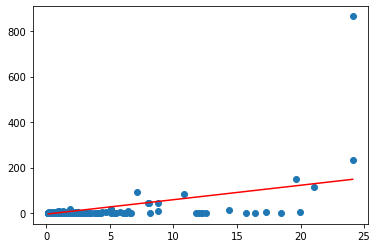

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     380.9
Date:                Sun, 08 Jan 2023   Prob (F-statistic):           1.47e-73
Time:                        15:23:20   Log-Likelihood:                -5312.7
No. Observations:                1160   AIC:                         1.063e+04
Df Residuals:                    1158   BIC:                         1.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4607      0.761     -5.859      0.0

In [80]:
x = df['PageRank'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [81]:
regression_results(y, y_pred)

explained_variance:  0.2475
r2:  0.2475
MAE:  4.8982
MSE:  556.645
RMSE:  23.5933


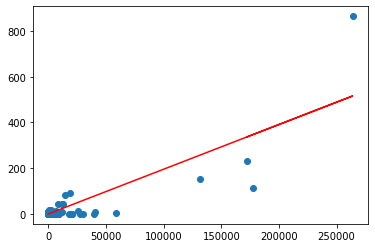

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     2846.
Date:                Sun, 08 Jan 2023   Prob (F-statistic):          3.09e-314
Time:                        15:23:20   Log-Likelihood:                -4758.1
No. Observations:                1160   AIC:                             9520.
Df Residuals:                    1158   BIC:                             9530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4835      0.432     -1.120      0.2

In [82]:
x = df['Betweenness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [83]:
regression_results(y, y_pred)

explained_variance:  0.7108
r2:  0.7108
MAE:  2.1069
MSE:  213.94
RMSE:  14.6267


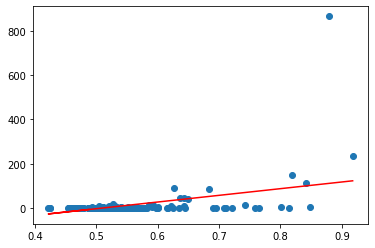

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     274.3
Date:                Sun, 08 Jan 2023   Prob (F-statistic):           1.84e-55
Time:                        15:23:20   Log-Likelihood:                -5354.3
No. Observations:                1160   AIC:                         1.071e+04
Df Residuals:                    1158   BIC:                         1.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -153.1468      9.375    -16.335      0.0

In [84]:
x = df['Closeness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [85]:
regression_results(y, y_pred)

explained_variance:  0.1915
r2:  0.1915
MAE:  5.8539
MSE:  598.0523
RMSE:  24.4551


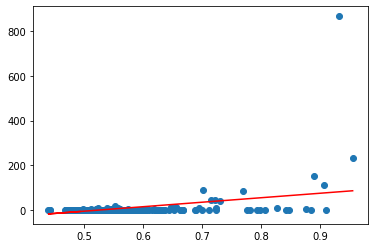

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     196.1
Date:                Sun, 08 Jan 2023   Prob (F-statistic):           2.85e-41
Time:                        15:23:20   Log-Likelihood:                -5386.9
No. Observations:                1160   AIC:                         1.078e+04
Df Residuals:                    1158   BIC:                         1.079e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.1860      7.597    -13.715      0.0

In [86]:
x = df['Harmonic'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [87]:
regression_results(y, y_pred)

explained_variance:  0.1448
r2:  0.1448
MAE:  5.983
MSE:  632.6194
RMSE:  25.1519


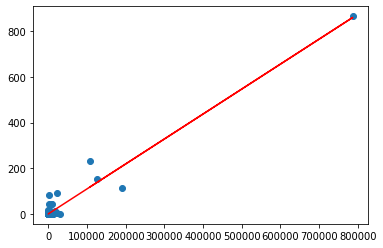

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 2.266e+04
Date:                Sun, 08 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:23:21   Log-Likelihood:                -3724.0
No. Observations:                1160   AIC:                             7452.
Df Residuals:                    1158   BIC:                             7462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1904      0.177      1.078      0.2

In [88]:
x = df['Degree'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [89]:
regression_results(y, y_pred)

explained_variance:  0.9514
r2:  0.9514
MAE:  1.0246
MSE:  35.9721
RMSE:  5.9977


In [90]:
x = df[['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']]
y = df['Number_of_Bugs']
#model = linear_regressor.fit(x, y)
#y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         Number_of_Bugs   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     4607.
Date:                Sun, 08 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:23:21   Log-Likelihood:                -3712.9
No. Observations:                1160   AIC:                             7438.
Df Residuals:                    1154   BIC:                             7468.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.3917      7.621     -1.232      

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

Performing analysis for: ActiveMQ
                Name                                               File  \
0       Bruce Snyder             assembly/src/release/example/build.xml   
1       Bruce Snyder  activemq-core/src/main/java/org/apache/activem...   
2       Bruce Snyder  activemq-core/src/main/java/org/apache/activem...   
3       Bruce Snyder  activemq-core/src/main/java/org/apache/activem...   
4       Bruce Snyder  activemq-core/src/main/java/org/apache/activem...   
...              ...                                                ...   
72623  Bosanac Dejan  activemq-core/src/main/java/org/apache/activem...   
72624  Bosanac Dejan  activemq-core/src/main/java/org/apache/activem...   
72625  Bosanac Dejan  activemq-core/src/main/java/org/apache/activem...   
72626  Bosanac Dejan  activemq-camel/src/test/java/org/apache/active...   
72627  Bosanac Dejan  activemq-core/src/main/java/org/apache/activem...   

                      Bug  PageRank  Betweenness  Closeness  Harm

Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7708016454893406
Average Precision-Recall Score: 0.652228790096634
PRC-AUC for model 1: 0.7312950815818863
Accuracy: 0.712
MCC for model 1: 0.4217066198403052
Precision score for model 1:  0.6530234709214938
Recall score for model 1:  0.716751269035533
F1 score for model 1:  0.6834049246778389
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.71      0.74     10285
           1       0.65      0.72      0.68      7880

    accuracy                           0.71     18165
   macro avg       0.71      0.71      0.71     18165
weighted avg       0.72      0.71      0.71     18165


Scores for model 2
------------------
Roc_Auc Score: 0.7707949949287933
Average Precision-Recall Score: 0.6522233255124052
PRC-AUC for model 2: 0.7312904539862076
Precision score for model 2:  0.6530234709214938
Recall score for model 2:  0.716751269035533
F1 score for model 

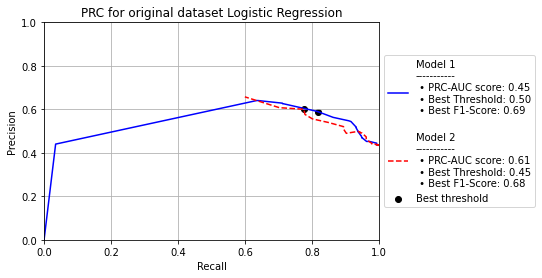

Best Threshold=0.340092, F1-Score=0.704 for model 1
Best Threshold=0.340061, F1-Score=0.704 for model 2


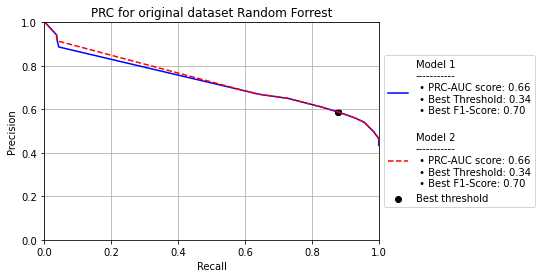

Best Threshold=0.340052, F1-Score=0.704 for model 1
Best Threshold=0.339943, F1-Score=0.704 for model 2


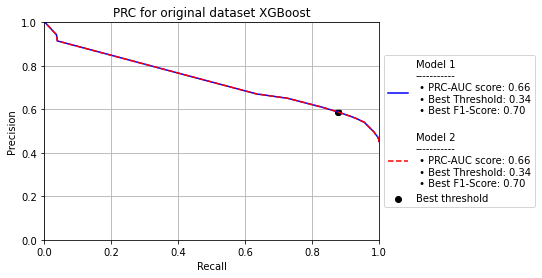

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7239468177252862
Average Precision-Recall Score: 0.6043750494974274
PRC-AUC for model 1: 0.4450822590932818
Accuracy: 0.674
MCC for model 1: 0.38666566585640355
Precision score for model 1:  0.5898727222781797
Recall score for model 1:  0.8175126903553299
F1 score for model 1:  0.6852826977288442
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.56      0.66     10285
           1       0.59      0.82      0.69      7880

    accuracy                           0.67     18165
   macro avg       0.70      0.69      0.67     18165
weighted avg       0.71      0.67      0.67     18165


Scores for model 2
------------------
Roc_Auc Score: 0.7220531724037519
Average Precision-Recall Score: 0.614385750125525
PRC-AUC for model 2: 0.6063397781924829
Precision score for model 2:  0.6004714201532115
Recall score for model 2:  0.77

TRAIN: [    0     1     2 ... 66741 66742 66743] | TEST: [63951 63952 63953 ... 72654 72655 72656]

Model Score: 0.5668272539573297

Average Precision-Recall Score: 0.43317274604267036
PRC-AUC Score: 0.6494017707577008
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.72      4118
           1       0.00      0.00      0.00      3147

    accuracy                           0.57      7265
   macro avg       0.28      0.50      0.36      7265
weighted avg       0.32      0.57      0.41      7265

Accuracy: 0.567
MCC:  0.0
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 66741 66742 66743] | TEST: [63951 63952 63953 ... 72654 72655 72656]

Model Score: 0.5668272539573297

Average Precision-Recall Score: 0.43317274604267036
PRC-AUC Score: 0.5194501085782096
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   sup

TRAIN: [    0     1     2 ... 66741 66742 66743] | TEST: [63951 63952 63953 ... 72654 72655 72656]

Model Score: 0.5668272539573297

Average Precision-Recall Score: 0.43317274604267036
PRC-AUC Score: 0.6494017707577008
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.72      4118
           1       0.00      0.00      0.00      3147

    accuracy                           0.57      7265
   macro avg       0.28      0.50      0.36      7265
weighted avg       0.32      0.57      0.41      7265

Accuracy: 0.567
MCC:  0.0
Row 14 model 2

Model Score: 0.5898092328020481

Average Precision-Recall Score: 0.41019076719795194
PRC-AUC Score: 0.6065774731248764
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.59      1.00      0.74      7142
           1       0.00      0.00      0.00      4967

    a

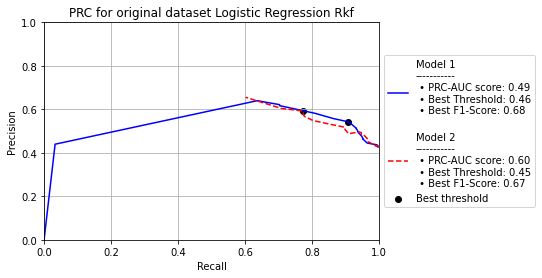

Best Threshold=0.344615, F1-Score=0.694 for model 1
Best Threshold=0.345094, F1-Score=0.694 for model 2


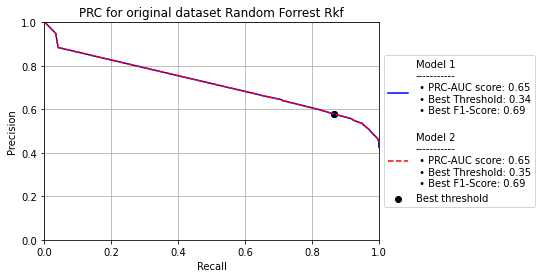

Best Threshold=0.343934, F1-Score=0.694 for model 1
Best Threshold=0.343834, F1-Score=0.694 for model 2


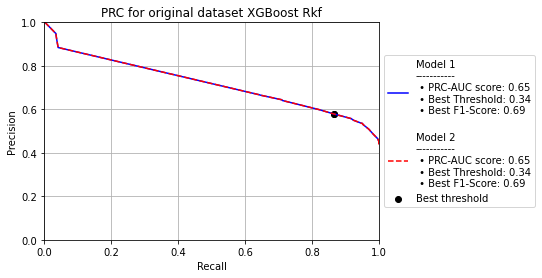

Best Threshold=0.461872, F1-Score=0.604 for model 1
Best Threshold=0.439735, F1-Score=0.606 for model 2


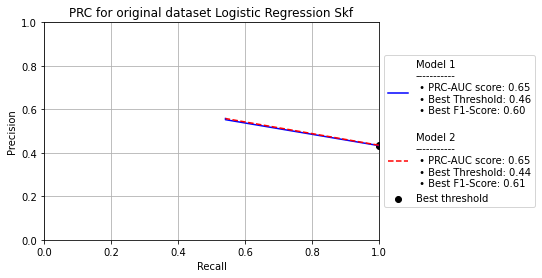

Best Threshold=0.298850, F1-Score=0.606 for model 1
Best Threshold=0.217048, F1-Score=0.606 for model 2


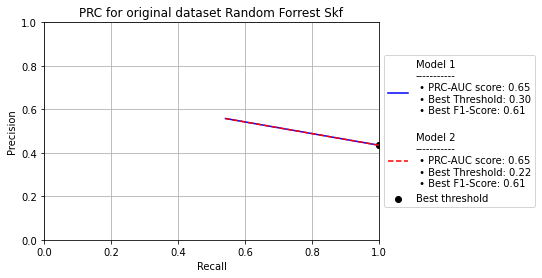

Best Threshold=0.322868, F1-Score=0.606 for model 1
Best Threshold=0.011066, F1-Score=0.606 for model 2


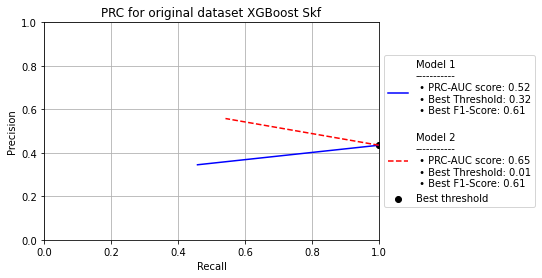

Best Threshold=0.474311, F1-Score=0.582 for model 1
Best Threshold=0.445942, F1-Score=0.583 for model 2


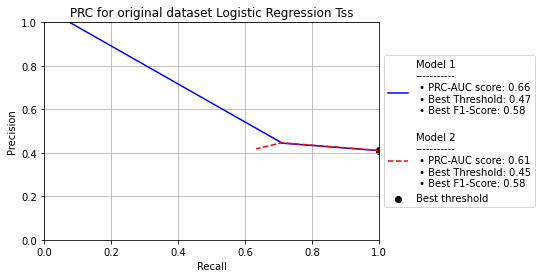

Best Threshold=0.327896, F1-Score=0.583 for model 1
Best Threshold=0.197405, F1-Score=0.583 for model 2


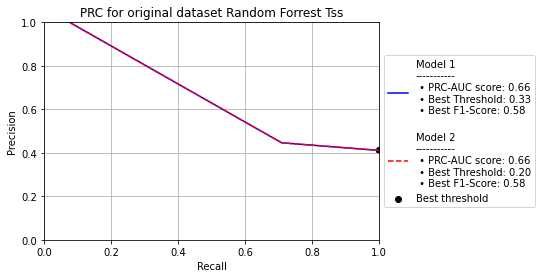

Best Threshold=0.367747, F1-Score=0.583 for model 1
Best Threshold=0.006338, F1-Score=0.583 for model 2


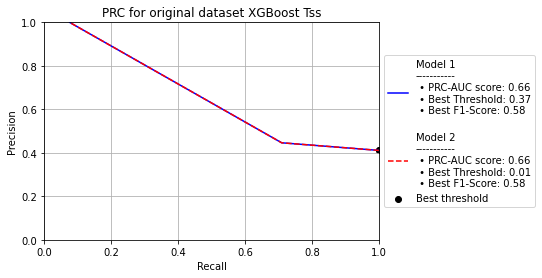

0    41183
1    31474
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7267480752630835
Average Precision-Recall Score: 0.608896667243137
PRC-AUC for model 1: 0.5388561478132372
Accuracy: 0.676
MCC for model 1: 0.3891832299610189
Precision score for model 1:  0.5921833622500229
Recall score for model 1:  0.8196410515672397
F1 score for model 1:  0.6875894608492817
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.56      0.66     10253
           1       0.59      0.82      0.69      7912

    accuracy                           0.68     18165
   macro avg       0.70      0.69      0.68     18165
weighted avg       0.71      0.68      0.67     18165


Scores for model 2
------------------
Roc_Auc Score: 0.7273943508802622
Average Precision-Recall Score: 0.6214193666464649
PRC-AUC for model 2: 0.7265624375535141
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 scor

TRAIN: [    0     1     2 ... 62944 62946 62947] | TEST: [    5    36    39 ... 62918 62937 62945]

Model Score: 0.5047664442326025

Average Precision-Recall Score: 0.5002669327763567
PRC-AUC Score: 0.5051027680277999
Precision:  0.5055393586005831
Recall:  0.27646683673469385
F1:  0.35745207173778604
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.73      0.60      3158
           1       0.51      0.28      0.36      3136

    accuracy                           0.50      6294
   macro avg       0.51      0.50      0.48      6294
weighted avg       0.51      0.50      0.48      6294

Accuracy: 0.505
MCC:  0.008919313435271132
TRAIN: [    0     1     2 ... 62944 62946 62947] | TEST: [    5    36    39 ... 62918 62937 62945]

Model Score: 0.5047664442326025

Average Precision-Recall Score: 0.5002669327763567
PRC-AUC Score: 0.5291881818663277
Precision:  0.5055393586005831
Recall:  0.27646683673469385
F1:  0.35745207173778604


TRAIN: [    0     1     2 ... 62944 62946 62947] | TEST: [    5    36    39 ... 62918 62937 62945]

Model Score: 0.5073085478233238

Average Precision-Recall Score: 0.5014810569564309
PRC-AUC Score: 0.7491261518906895
Precision:  0.5138778747026169
Recall:  0.2066326530612245
F1:  0.29474641801228113
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.81      0.62      3158
           1       0.51      0.21      0.29      3136

    accuracy                           0.51      6294
   macro avg       0.51      0.51      0.46      6294
weighted avg       0.51      0.51      0.46      6294

Accuracy: 0.507
MCC:  0.015642732591617598
TRAIN: [    0     1     2 ... 62944 62946 62947] | TEST: [    5    36    39 ... 62918 62937 62945]

Model Score: 0.49984111852557994

Average Precision-Recall Score: 0.49839423571851404
PRC-AUC Score: 0.5016033587769765
Precision:  0.4984787018255578
Recall:  0.6269132653061225
F1:  0.5553672316384181
C

MCC for model 2: 0.23075284930080495

Scores for model 1
------------------
Roc_Auc Score: 0.7734894379980201
Average Precision-Recall Score: 0.7104380313910348
PRC-AUC for model 1: 0.7808132220263034
Accuracy: 0.718
MCC for model 1: 0.4359219358762849
Precision score for model 1:  0.7096591978911693
Recall score for model 1:  0.7343399902581588
F1 score for model 1:  0.7217886723799494
Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.70      0.71     10327
           1       0.71      0.73      0.72     10265

    accuracy                           0.72     20592
   macro avg       0.72      0.72      0.72     20592
weighted avg       0.72      0.72      0.72     20592


Scores for model 2
------------------
Roc_Auc Score: 0.7734507611809844
Average Precision-Recall Score: 0.7104243049609462
PRC-AUC for model 2: 0.7807991195472975
Precision score for model 2:  0.7096591978911693
Recall score for model 2:  0.7343399902581588


TRAIN: [    0     2     3 ... 82363 82364 82365] | TEST: [    1    10    20 ... 82341 82357 82360]

Model Score: 0.7112676056338029

Average Precision-Recall Score: 0.6468340413335348
PRC-AUC Score: 0.7093164454001952
Precision:  0.7012138188608776
Recall:  0.7323256947830327
F1:  0.716432148819461
Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.69      0.71      4134
           1       0.70      0.73      0.72      4102

    accuracy                           0.71      8236
   macro avg       0.71      0.71      0.71      8236
weighted avg       0.71      0.71      0.71      8236

Accuracy: 0.711
MCC:  0.423038875781647
Row 45 model 1
TRAIN: [    0     2     3 ... 82363 82364 82365] | TEST: [    1    10    20 ... 82341 82357 82360]

Model Score: 0.7112676056338029

Average Precision-Recall Score: 0.6468340413335348
PRC-AUC Score: 0.709315075728841
Precision:  0.7012138188608776
Recall:  0.7323256947830327
F1:  0.71643214881

TRAIN: [    0     2     3 ... 82363 82364 82365] | TEST: [    1    10    20 ... 82341 82357 82360]

Model Score: 0.7112676056338029

Average Precision-Recall Score: 0.6468340413335348
PRC-AUC Score: 0.709315075728841
Precision:  0.7012138188608776
Recall:  0.7323256947830327
F1:  0.716432148819461
Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.69      0.71      4134
           1       0.70      0.73      0.72      4102

    accuracy                           0.71      8236
   macro avg       0.71      0.71      0.71      8236
weighted avg       0.71      0.71      0.71      8236

Accuracy: 0.711
MCC:  0.423038875781647
TRAIN: [    0     1     2 ... 78245 78246 78247] | TEST: [63951 63952 63953 ... 82363 82364 82365]

Model Score: 0.45726080621661

Average Precision-Recall Score: 0.479591570768141
PRC-AUC Score: 0.7631352904698867
Precision:  0.4775108612317915
Recall:  0.9074793589120933
F1:  0.625753516409913
Classificatio

F1 score for model 1:  0.7175748273215655
Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.70      0.71     10345
           1       0.71      0.73      0.72     10247

    accuracy                           0.71     20592
   macro avg       0.71      0.71      0.71     20592
weighted avg       0.71      0.71      0.71     20592


Scores for model 2
------------------
Roc_Auc Score: 0.7721497145211204
Average Precision-Recall Score: 0.7078976277206728
PRC-AUC for model 2: 0.7627231013494351
Precision score for model 2:  0.7055938119045373
Recall score for model 2:  0.7299697472430955
F1 score for model 2:  0.7175748273215655
Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.70      0.71     10345
           1       0.71      0.73      0.72     10247

    accuracy                           0.71     20592
   macro avg       0.71      0.71      0.71     20592
weighted a

TRAIN: [    0     1     2 ... 78245 78246 78247] | TEST: [37065 37066 37067 ... 82363 82364 82365]

Model Score: 0.4522826614861583

Average Precision-Recall Score: 0.4773368499344562
PRC-AUC Score: 0.7136142365189303
Precision:  0.4749458115517022
Recall:  0.9045653229723166
F1:  0.6228576206002843
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4118
           1       0.47      0.90      0.62      4118

    accuracy                           0.45      8236
   macro avg       0.24      0.45      0.31      8236
weighted avg       0.24      0.45      0.31      8236

Accuracy: 0.452
MCC:  -0.22384900468082428
TRAIN: [    0     1     2 ... 78245 78246 78247] | TEST: [37065 37066 37067 ... 82363 82364 82365]

Model Score: 0.4428120446818844

Average Precision-Recall Score: 0.47315349392228595
PRC-AUC Score: 0.37013050072854914
Precision:  0.46944336317633323
Recall:  0.878581835842642
F1:  0.611923890063425
Cla

TRAIN: [    0     1     2 ... 78245 78246 78247] | TEST: [37065 37066 37067 ... 82363 82364 82365]

Model Score: 0.4428120446818844

Average Precision-Recall Score: 0.47315349392228595
PRC-AUC Score: 0.3701107172323349
Precision:  0.46944336317633323
Recall:  0.878581835842642
F1:  0.611923890063425
Classification Report:

              precision    recall  f1-score   support

           0       0.05      0.01      0.01      4118
           1       0.47      0.88      0.61      4118

    accuracy                           0.44      8236
   macro avg       0.26      0.44      0.31      8236
weighted avg       0.26      0.44      0.31      8236

Accuracy: 0.443
MCC:  -0.23326543570187075
Row 67 model 2
TRAIN: [    0     1     2 ... 78245 78246 78247] | TEST: [37065 37066 37067 ... 82363 82364 82365]

Model Score: 0.4428120446818844

Average Precision-Recall Score: 0.47315349392228595
PRC-AUC Score: 0.3689272141594438
Precision:  0.46944336317633323
Recall:  0.878581835842642
F1:  0.61192

Performing analysis for: Ant
                       Name  \
13939  Antoine Levy-Lambert   
13940  Antoine Levy-Lambert   
13941  Antoine Levy-Lambert   
13942  Antoine Levy-Lambert   
13943  Antoine Levy-Lambert   
...                     ...   
80540        Stefan Bodewig   
80541        Stefan Bodewig   
80542        Stefan Bodewig   
80543        Stefan Bodewig   
80544        Stefan Bodewig   

                                                    File                 Bug  \
13939              docs/manual/CoreTypes/zipfileset.html  INTRODUCED_NEW_BUG   
13940    src/main/org/apache/tools/ant/taskdefs/Zip.java  INTRODUCED_NEW_BUG   
13941                     docs/manual/CoreTasks/zip.html  INTRODUCED_NEW_BUG   
13942  src/main/org/apache/tools/ant/types/ZipFileSet...  INTRODUCED_NEW_BUG   
13943                 docs/manual/conceptstypeslist.html  INTRODUCED_NEW_BUG   
...                                                  ...                 ...   
80540            src/etc/testcases/tas


Scores for model 1
------------------
Roc_Auc Score: 0.7548742049072698
Average Precision-Recall Score: 0.42926047891533387
PRC-AUC for model 1: 0.4646229653693463
Accuracy: 0.795
MCC for model 1: 0.2808605285912707
Precision score for model 1:  0.571790969051243
Recall score for model 1:  0.2554397098821396
F1 score for model 1:  0.35312548958170137
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     15725
           1       0.57      0.26      0.35      4412

    accuracy                           0.79     20137
   macro avg       0.70      0.60      0.62     20137
weighted avg       0.76      0.79      0.76     20137


Scores for model 2
------------------
Roc_Auc Score: 0.7549781561199619
Average Precision-Recall Score: 0.4292710709434394
PRC-AUC for model 2: 0.4647222579382717
Precision score for model 2:  0.571790969051243
Recall score for model 2:  0.2554397098821396
F1 score for model 2:  0.353125489581

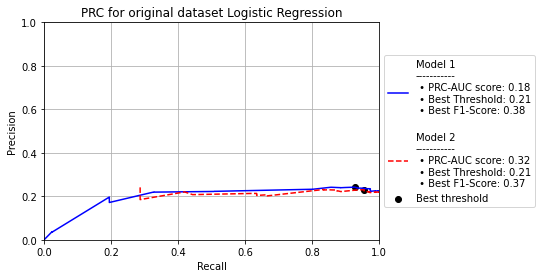

Best Threshold=0.239631, F1-Score=0.467 for model 1
Best Threshold=0.239600, F1-Score=0.467 for model 2


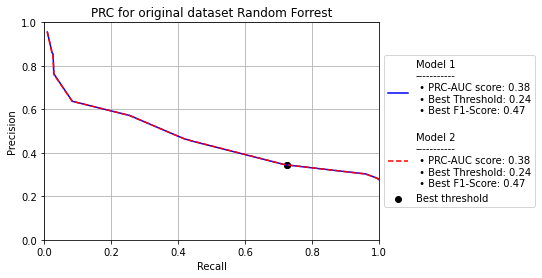

Best Threshold=0.238470, F1-Score=0.467 for model 1
Best Threshold=0.240110, F1-Score=0.467 for model 2


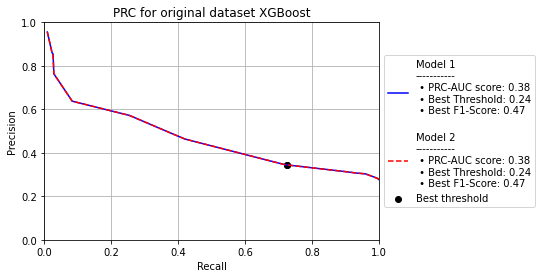

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5041615149894708
Average Precision-Recall Score: 0.21922867614748032
PRC-AUC for model 1: 0.18310750127050485
Accuracy: 0.348
MCC for model 1: 0.12715280012406635
Precision score for model 1:  0.24206231892626973
Recall score for model 1:  0.9279238440616501
F1 score for model 1:  0.3839624853458382
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.18      0.31     15725
           1       0.24      0.93      0.38      4412

    accuracy                           0.35     20137
   macro avg       0.57      0.56      0.35     20137
weighted avg       0.76      0.35      0.32     20137


Scores for model 2
------------------
Roc_Auc Score: 0.49919478168371567
Average Precision-Recall Score: 0.230095170923895
PRC-AUC for model 2: 0.3223923547960307
Precision score for model 2:  0.22989319965126417
Recall score for model 2: 

TRAIN: [    0     1     2 ... 78804 78805 78806] | TEST: [69119 69120 69121 ... 80542 80543 80544]

Model Score: 0.7842066054134591

Average Precision-Recall Score: 0.21579339458654084
PRC-AUC Score: 0.6078966972932704
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      6316
           1       0.00      0.00      0.00      1738

    accuracy                           0.78      8054
   macro avg       0.39      0.50      0.44      8054
weighted avg       0.61      0.78      0.69      8054

Accuracy: 0.784
MCC:  0.0
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 78804 78805 78806] | TEST: [69119 69120 69121 ... 80542 80543 80544]

Model Score: 0.7842066054134591

Average Precision-Recall Score: 0.21579339458654084
PRC-AUC Score: 0.6078966972932704
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   sup

TRAIN: [    0     1     2 ... 78804 78805 78806] | TEST: [69119 69120 69121 ... 80542 80543 80544]

Model Score: 0.7842066054134591

Average Precision-Recall Score: 0.21579339458654084
PRC-AUC Score: 0.6078966972932704
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      6316
           1       0.00      0.00      0.00      1738

    accuracy                           0.78      8054
   macro avg       0.39      0.50      0.44      8054
weighted avg       0.61      0.78      0.69      8054

Accuracy: 0.784
MCC:  0.0
Row 14 model 2

Model Score: 0.6193384982121574

Average Precision-Recall Score: 0.3806615017878427
PRC-AUC Score: 0.6903307508939214
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.62      1.00      0.76      8314
           1       0.00      0.00      0.00      5110

    ac

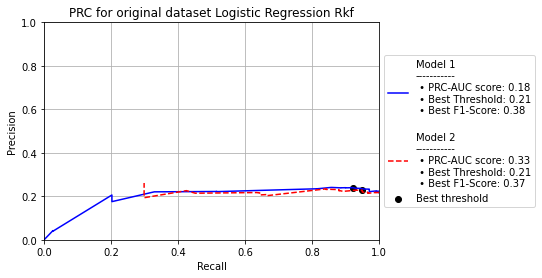

Best Threshold=0.247231, F1-Score=0.469 for model 1
Best Threshold=0.247221, F1-Score=0.469 for model 2


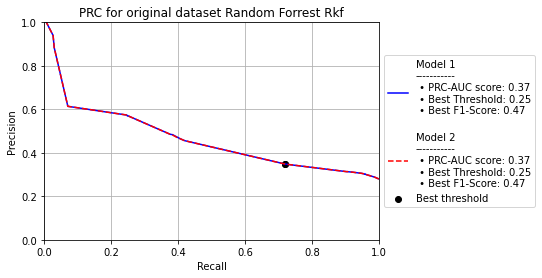

Best Threshold=0.247114, F1-Score=0.469 for model 1
Best Threshold=0.247180, F1-Score=0.469 for model 2


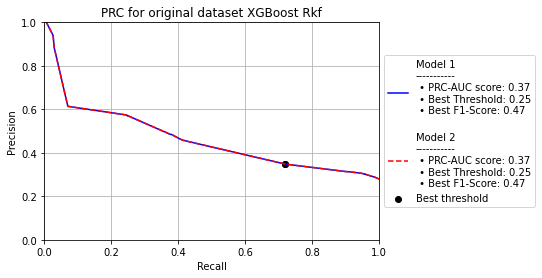

Best Threshold=0.221126, F1-Score=0.355 for model 1
Best Threshold=0.218039, F1-Score=0.355 for model 2


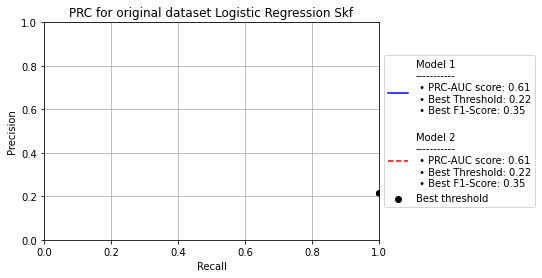

Best Threshold=0.270140, F1-Score=0.355 for model 1
Best Threshold=0.269055, F1-Score=0.355 for model 2


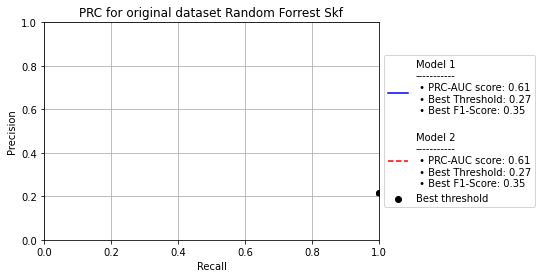

Best Threshold=0.269503, F1-Score=0.355 for model 1
Best Threshold=0.269628, F1-Score=0.355 for model 2


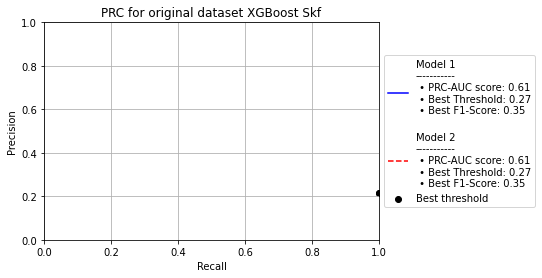

Best Threshold=0.186539, F1-Score=0.551 for model 1
Best Threshold=0.183795, F1-Score=0.551 for model 2


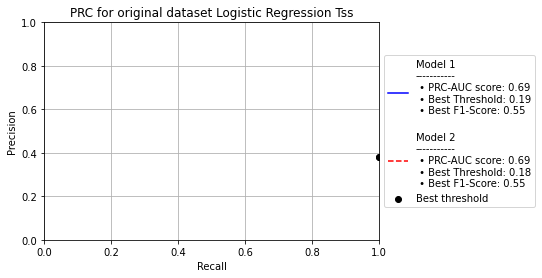

Best Threshold=0.000000, F1-Score=0.551 for model 1
Best Threshold=0.000000, F1-Score=0.551 for model 2


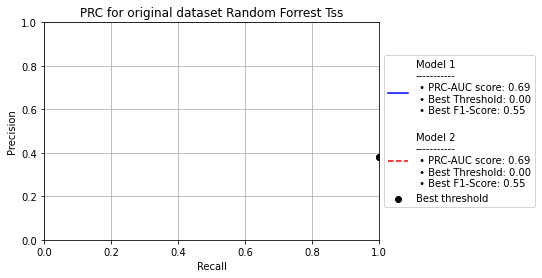

Best Threshold=0.000062, F1-Score=0.551 for model 1
Best Threshold=0.000026, F1-Score=0.551 for model 2


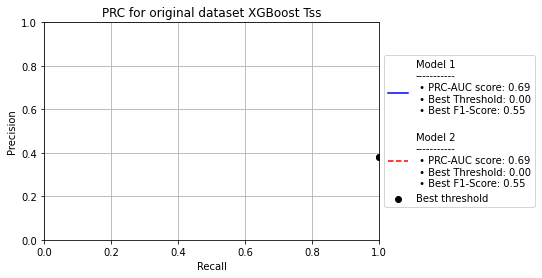

0    63169
1    17376
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5044514224970937
Average Precision-Recall Score: 0.21862822874581334
PRC-AUC for model 1: 0.19944569331032255
Accuracy: 0.781
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     15730
           1       0.00      0.00      0.00      4407

    accuracy                           0.78     20137
   macro avg       0.39      0.50      0.44     20137
weighted avg       0.61      0.78      0.69     20137


Scores for model 2
------------------
Roc_Auc Score: 0.5111732317438116
Average Precision-Recall Score: 0.23465489168335368
PRC-AUC for model 2: 0.3403564585955426
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

            

TRAIN: [    0     1     2 ... 34749 34750 34751] | TEST: [    7     9    13 ... 34725 34738 34743]

Model Score: 0.5030215827338129

Average Precision-Recall Score: 0.4991881792770763
PRC-AUC Score: 0.5017574957426536
Precision:  0.5
Recall:  0.7313259988419224
F1:  0.5939336938631553
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.28      0.36      1748
           1       0.50      0.73      0.59      1727

    accuracy                           0.50      3475
   macro avg       0.51      0.50      0.48      3475
weighted avg       0.51      0.50      0.48      3475

Accuracy: 0.503
MCC:  0.00985952478410462
TRAIN: [    0     1     2 ... 34749 34750 34751] | TEST: [    7     9    13 ... 34725 34738 34743]

Model Score: 0.5030215827338129

Average Precision-Recall Score: 0.4991881792770763
PRC-AUC Score: 0.7484892086330935
Precision:  0.5
Recall:  0.7313259988419224
F1:  0.5939336938631553
Classification Report:

           

TRAIN: [    0     1     2 ... 34749 34750 34751] | TEST: [    7     9    13 ... 34725 34738 34743]

Model Score: 0.49985611510791367

Average Precision-Recall Score: 0.4967393513975481
PRC-AUC Score: 0.4936486296582058
Precision:  0.4964401294498382
Recall:  0.44412275622466707
F1:  0.46882640586797064
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.55      0.53      1748
           1       0.50      0.44      0.47      1727

    accuracy                           0.50      3475
   macro avg       0.50      0.50      0.50      3475
weighted avg       0.50      0.50      0.50      3475

Accuracy: 0.500
MCC:  -0.0009632478835186173
Row 27 model 2
TRAIN: [    0     1     2 ... 34749 34750 34751] | TEST: [    7     9    13 ... 34725 34738 34743]

Model Score: 0.5001438848920863

Average Precision-Recall Score: 0.4968838870419997
PRC-AUC Score: 0.4951351453315194
Precision:  0.49676584734799484
Recall:  0.44470179502026635
F1:  0

Recall score for model 2:  0.904991437813154
F1 score for model 2:  0.7313123030007944
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.43      0.57     15818
           1       0.61      0.90      0.73     15767

    accuracy                           0.67     31585
   macro avg       0.72      0.67      0.65     31585
weighted avg       0.72      0.67      0.65     31585

Accuracy: 0.668
MCC for model 2: 0.3822184284470343
-------------------------------
|Scores for XGBoost Classifier|
-------------------------------
Row 38 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7481859778048814
Average Precision-Recall Score: 0.70761651108732
PRC-AUC for model 1: 0.7351009726511536
Accuracy: 0.668
MCC for model 1: 0.3822184284470343
Precision score for model 1:  0.613562091503268
Recall score for model 1:  0.904991437813154
F1 score for model 1:  0.7313123030007944
Classification Report:

              precision   

TRAIN: [     0      1      2 ... 126335 126336 126337] | TEST: [     3      9     11 ... 126275 126309 126322]

Model Score: 0.6688830839863849

Average Precision-Recall Score: 0.6037789583556948
PRC-AUC Score: 0.7135691426686327
Precision:  0.6153346328784925
Recall:  0.9000475209884365
F1:  0.7309448768251109
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.44      0.57      6320
           1       0.62      0.90      0.73      6313

    accuracy                           0.67     12633
   macro avg       0.71      0.67      0.65     12633
weighted avg       0.71      0.67      0.65     12633

Accuracy: 0.669
MCC:  0.38111070361135674
TRAIN: [     0      1      2 ... 120018 120019 120020] | TEST: [ 69119  69120  69121 ... 126335 126336 126337]

Model Score: 0.4426502018522916

Average Precision-Recall Score: 0.4730937782823135
PRC-AUC Score: 0.5575431375652999
Precision:  0.4696002687269063
Recall:  0.8852303308532531
F1:  

TRAIN: [     0      1      2 ... 120018 120019 120020] | TEST: [ 69119  69120  69121 ... 126335 126336 126337]

Model Score: 0.4398796802026439

Average Precision-Recall Score: 0.47188699445308213
PRC-AUC Score: 0.4501445947464598
Precision:  0.46803672197422724
Recall:  0.879689726135824
F1:  0.6109950522264981
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6316
           1       0.47      0.88      0.61      6317

    accuracy                           0.44     12633
   macro avg       0.23      0.44      0.31     12633
weighted avg       0.23      0.44      0.31     12633

Accuracy: 0.440
MCC:  -0.25298349287051425
TRAIN: [     0      1      2 ... 120018 120019 120020] | TEST: [ 69119  69120  69121 ... 126335 126336 126337]

Model Score: 0.4398796802026439

Average Precision-Recall Score: 0.47188699445308213
PRC-AUC Score: 0.7500197894403546
Precision:  0.46803672197422724
Recall:  0.879689726135824
F1

Roc_Auc Score: 0.7516529096507304
Average Precision-Recall Score: 0.7093117063881133
PRC-AUC for model 2: 0.7361185901309767
Precision score for model 2:  0.615745927777299
Recall score for model 2:  0.9054559280147012
F1 score for model 2:  0.7330135686254392
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.44      0.57     15804
           1       0.62      0.91      0.73     15781

    accuracy                           0.67     31585
   macro avg       0.72      0.67      0.65     31585
weighted avg       0.72      0.67      0.65     31585

Accuracy: 0.670
MCC for model 2: 0.38645940139947

Scores for model 1
------------------
Roc_Auc Score: 0.507984711919416
Average Precision-Recall Score: 0.49596245317926696
PRC-AUC for model 1: 0.44895736126234587
Accuracy: 0.502
MCC for model 1: 0.040279229113348816
Precision score for model 1:  0.5007303442144037
Recall score for model 1:  0.9992395919143273
F1 score for model 1:  0

TRAIN: [     0      1      2 ... 120018 120019 120020] | TEST: [ 56853  56854  56855 ... 126335 126336 126337]

Model Score: 0.4432043061822212

Average Precision-Recall Score: 0.4733362371642826
PRC-AUC Score: 0.7498416938723694
Precision:  0.4699118757868233
Recall:  0.886338451796739
F1:  0.6141948222904783
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6316
           1       0.47      0.89      0.61      6317

    accuracy                           0.44     12633
   macro avg       0.23      0.44      0.31     12633
weighted avg       0.23      0.44      0.31     12633

Accuracy: 0.443
MCC:  -0.24546005149969352
TRAIN: [     0      1      2 ... 120018 120019 120020] | TEST: [ 56853  56854  56855 ... 126335 126336 126337]

Model Score: 0.3596137101242777

Average Precision-Recall Score: 0.441299940643367
PRC-AUC Score: 0.6507303096143396
Precision:  0.4183626484943365
Recall:  0.7191704923223049
F1:  0

TRAIN: [     0      1      2 ... 120018 120019 120020] | TEST: [ 56853  56854  56855 ... 126335 126336 126337]

Model Score: 0.3596928678856962

Average Precision-Recall Score: 0.4413255365850561
PRC-AUC Score: 0.6508421077228431
Precision:  0.4184162062615101
Recall:  0.7193287953142314
F1:  0.5290795831635325
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6316
           1       0.42      0.72      0.53      6317

    accuracy                           0.36     12633
   macro avg       0.21      0.36      0.26     12633
weighted avg       0.21      0.36      0.26     12633

Accuracy: 0.360
MCC:  -0.4040220588214231
Row 67 model 2
TRAIN: [     0      1      2 ... 120018 120019 120020] | TEST: [ 56853  56854  56855 ... 126335 126336 126337]

Model Score: 0.3596137101242777

Average Precision-Recall Score: 0.441299940643367
PRC-AUC Score: 0.6508421077224048
Precision:  0.4183626484943365
Recall:  0.71917049

Performing analysis for: Camel
                     Name                                               File  \
119            Bob Paulin  components/camel-tika/src/main/java/org/apache...   
120            Bob Paulin  components/camel-tika/src/test/java/org/apache...   
121            Bob Paulin  components/camel-tika/src/main/resources/META-...   
122            Bob Paulin  components/camel-tika/src/test/resources/test.doc   
123            Bob Paulin                               apache-camel/pom.xml   
...                   ...                                                ...   
515388  Roman Kalukiewicz  components/camel-jetty/src/main/java/org/apach...   
515389  Roman Kalukiewicz  components/camel-jetty/src/main/java/org/apach...   
515390  Roman Kalukiewicz  components/camel-jetty/src/test/java/org/apach...   
515393         Gary Tully  components/camel-jms/src/main/java/org/apache/...   
515394         Gary Tully  components/camel-jms/src/test/java/org/apache/...   

        

              precision    recall  f1-score   support

           0       0.87      0.96      0.91    106534
           1       0.64      0.30      0.41     22327

    accuracy                           0.85    128861
   macro avg       0.75      0.63      0.66    128861
weighted avg       0.83      0.85      0.83    128861


Scores for model 2
------------------
Roc_Auc Score: 0.7914904158772291
Average Precision-Recall Score: 0.4560065208046451
PRC-AUC for model 2: 0.4952522030687625
Precision score for model 2:  0.6394551251086852
Recall score for model 2:  0.29645720428181127
F1 score for model 2:  0.40510435155150254
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91    106534
           1       0.64      0.30      0.41     22327

    accuracy                           0.85    128861
   macro avg       0.75      0.63      0.66    128861
weighted avg       0.83      0.85      0.83    128861

Accuracy: 0.849
MCC

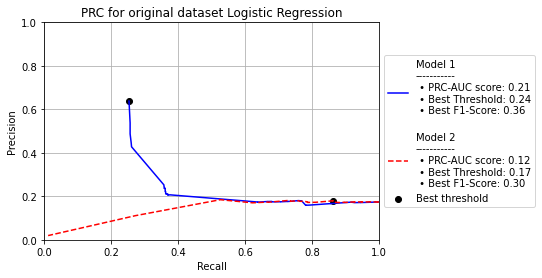

Best Threshold=0.256430, F1-Score=0.499 for model 1
Best Threshold=0.242113, F1-Score=0.499 for model 2


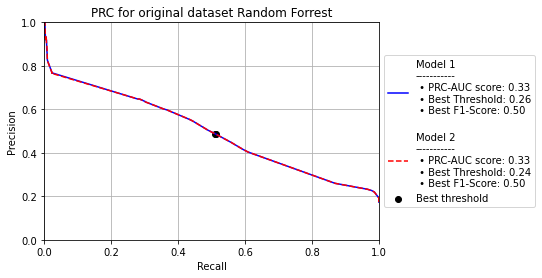

Best Threshold=0.258859, F1-Score=0.499 for model 1
Best Threshold=0.257032, F1-Score=0.499 for model 2


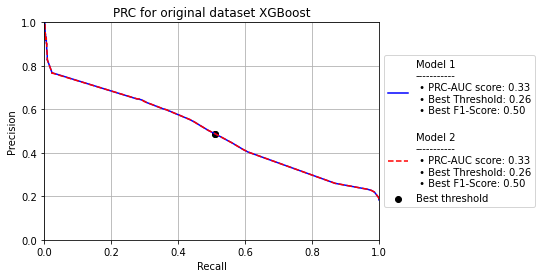

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5517481882160225
Average Precision-Recall Score: 0.3017379776162632
PRC-AUC for model 1: 0.207764755028206
Accuracy: 0.846
MCC for model 1: 0.3340017621881175
Precision score for model 1:  0.6379815273710295
Recall score for model 1:  0.25368388050342633
F1 score for model 1:  0.36301874699567377
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.97      0.91    106534
           1       0.64      0.25      0.36     22327

    accuracy                           0.85    128861
   macro avg       0.75      0.61      0.64    128861
weighted avg       0.82      0.85      0.82    128861


Scores for model 2
------------------
Roc_Auc Score: 0.44578290319205277
Average Precision-Recall Score: 0.15884327209248517
PRC-AUC for model 2: 0.1199677086659416
Precision score for model 2:  0.1794606967396159
Recall score for model 2:  0

TRAIN: [     0      1      2 ... 495265 495266 495267] | TEST: [453739 453740 453741 ... 515439 515440 515441]

Model Score: 0.36419369858761447

Average Precision-Recall Score: 0.16028085811667506
PRC-AUC Score: 0.14448727658522162
Precision:  0.03067364033190452
Recall:  0.08761091766820173
F1:  0.045438657811953866
Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.42      0.52     42641
           1       0.03      0.09      0.05      8903

    accuracy                           0.36     51544
   macro avg       0.36      0.25      0.28     51544
weighted avg       0.58      0.36      0.44     51544

Accuracy: 0.364
MCC:  -0.370821558650266
Original_XGB_Classifier_skf model 1
TRAIN: [     0      1      2 ... 495265 495266 495267] | TEST: [453739 453740 453741 ... 515439 515440 515441]

Model Score: 0.3723032748719541

Average Precision-Recall Score: 0.15748935774652942
PRC-AUC Score: 0.11050933147238759
Precision:  0.040122

TRAIN: [     0      1      2 ... 495265 495266 495267] | TEST: [453739 453740 453741 ... 515439 515440 515441]

Model Score: 0.2467794505665063

Average Precision-Recall Score: 0.172856544615447
PRC-AUC Score: 0.10993627987597217
Precision:  0.17287298012376184
Recall:  0.8880152757497473
F1:  0.2894062522878688
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.11      0.20     42641
           1       0.17      0.89      0.29      8903

    accuracy                           0.25     51544
   macro avg       0.50      0.50      0.24     51544
weighted avg       0.72      0.25      0.21     51544

Accuracy: 0.247
MCC:  0.0010892059485276366
Row 14 model 2

Model Score: 0.7094183244671564

Average Precision-Recall Score: 0.29058167553284364
PRC-AUC Score: 0.34346914498790687
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.71      1.00     

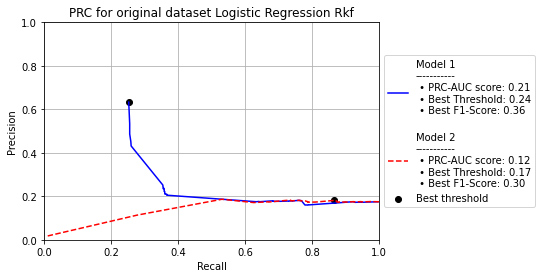

Best Threshold=0.273572, F1-Score=0.501 for model 1
Best Threshold=0.267181, F1-Score=0.501 for model 2


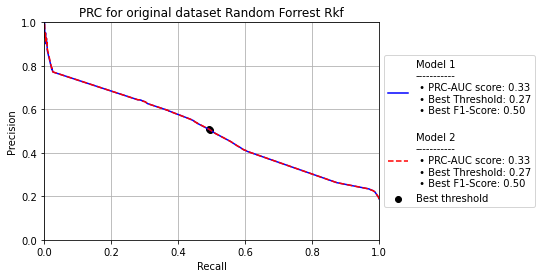

Best Threshold=0.270808, F1-Score=0.501 for model 1
Best Threshold=0.274205, F1-Score=0.501 for model 2


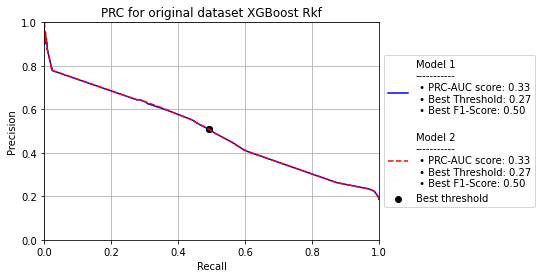

Best Threshold=0.119258, F1-Score=0.412 for model 1
Best Threshold=0.167231, F1-Score=0.309 for model 2


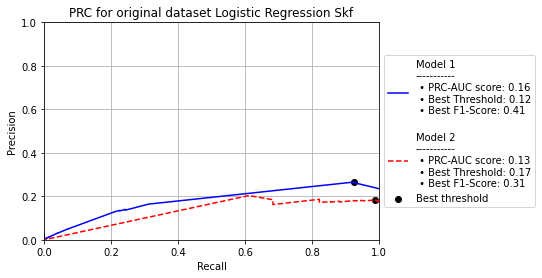

Best Threshold=0.214456, F1-Score=0.318 for model 1
Best Threshold=0.388563, F1-Score=0.318 for model 2


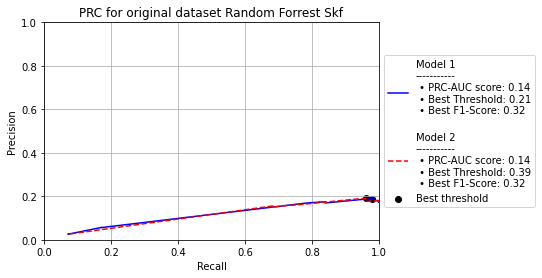

Best Threshold=0.029730, F1-Score=0.307 for model 1
Best Threshold=0.113530, F1-Score=0.309 for model 2


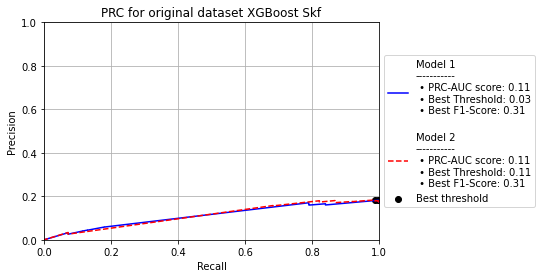

Best Threshold=0.021966, F1-Score=0.461 for model 1
Best Threshold=0.009196, F1-Score=0.458 for model 2


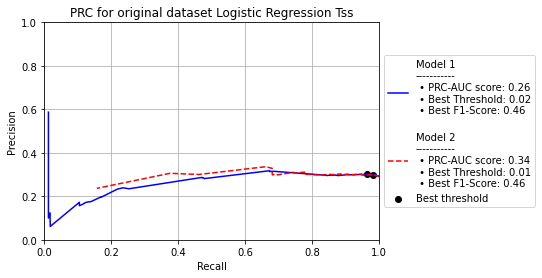

Best Threshold=0.096851, F1-Score=0.464 for model 1
Best Threshold=0.058019, F1-Score=0.465 for model 2


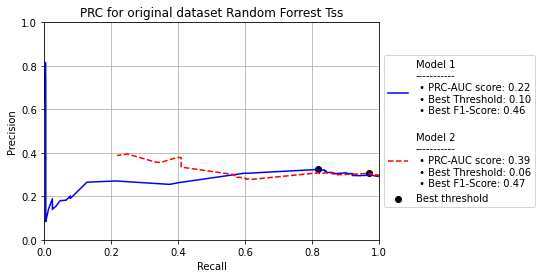

Best Threshold=0.016583, F1-Score=0.473 for model 1
Best Threshold=0.015901, F1-Score=0.479 for model 2


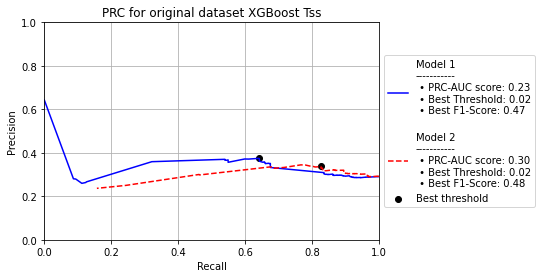

0    426411
1     89031
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5483286402366628
Average Precision-Recall Score: 0.29818899030535984
PRC-AUC for model 1: 0.35662420431645814
Accuracy: 0.828
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    106686
           1       0.00      0.00      0.00     22175

    accuracy                           0.83    128861
   macro avg       0.41      0.50      0.45    128861
weighted avg       0.69      0.83      0.75    128861


Scores for model 2
------------------
Roc_Auc Score: 0.44281302445442466
Average Precision-Recall Score: 0.15660288593033053
PRC-AUC for model 2: 0.14220585329019772
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

        

TRAIN: [     0      2      3 ... 178059 178060 178061] | TEST: [     1     19     21 ... 178013 178020 178045]

Model Score: 0.5018533078737504

Average Precision-Recall Score: 0.4990173149204757
PRC-AUC Score: 0.5029880152262804
Precision:  0.5001398210290827
Recall:  0.4031785392245266
F1:  0.4464553170244633
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.60      0.55      8934
           1       0.50      0.40      0.45      8872

    accuracy                           0.50     17806
   macro avg       0.50      0.50      0.50     17806
weighted avg       0.50      0.50      0.50     17806

Accuracy: 0.502
MCC:  0.003082011939793221
TRAIN: [     0      2      3 ... 178059 178060 178061] | TEST: [     1     19     21 ... 178013 178020 178045]

Model Score: 0.5018533078737504

Average Precision-Recall Score: 0.4990173149204757
PRC-AUC Score: 0.7491295069077839
Precision:  0.5001398210290827
Recall:  0.4031785392245266
F1: 

TRAIN: [     0      2      3 ... 178059 178060 178061] | TEST: [     1     19     21 ... 178013 178020 178045]

Model Score: 0.5049983151746602

Average Precision-Recall Score: 0.5002154179066477
PRC-AUC Score: 0.7491295069077839
Precision:  0.5100346020761246
Recall:  0.16614066726780885
F1:  0.25063764665873156
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.84      0.63      8934
           1       0.51      0.17      0.25      8872

    accuracy                           0.50     17806
   macro avg       0.51      0.50      0.44     17806
weighted avg       0.51      0.50      0.44     17806

Accuracy: 0.505
MCC:  0.010366638978763271
TRAIN: [     0      2      3 ... 178059 178060 178061] | TEST: [     1     19     21 ... 178013 178020 178045]

Model Score: 0.4997753566213636

Average Precision-Recall Score: 0.4983839440881363
PRC-AUC Score: 0.4972679922551939
Precision:  0.49845529172919056
Recall:  0.6364968440036068
F


Scores for model 1
------------------
Roc_Auc Score: 0.7898576061321073
Average Precision-Recall Score: 0.7654987542716413
PRC-AUC for model 1: 0.792939251635042
Accuracy: 0.709
MCC for model 1: 0.4275063425678543
Precision score for model 1:  0.763284453319784
Recall score for model 1:  0.6061766279102503
F1 score for model 1:  0.675718649315871
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.74    106643
           1       0.76      0.61      0.68    106563

    accuracy                           0.71    213206
   macro avg       0.72      0.71      0.71    213206
weighted avg       0.72      0.71      0.71    213206


Scores for model 2
------------------
Roc_Auc Score: 0.7897828694899502
Average Precision-Recall Score: 0.765468623319826
PRC-AUC for model 2: 0.7931086516662225
Precision score for model 2:  0.7632788589929927
Recall score for model 2:  0.6061578596698667
F1 score for model 2:  0.6757047962759559

TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [     4      5     18 ... 852773 852776 852792]

Model Score: 0.7101498557726132

Average Precision-Recall Score: 0.6600030273767185
PRC-AUC Score: 0.7769881659661655
Precision:  0.7614684253530991
Recall:  0.6119749525082671
F1:  0.6785858244373074
Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.81      0.74     42643
           1       0.76      0.61      0.68     42639

    accuracy                           0.71     85282
   macro avg       0.72      0.71      0.71     85282
weighted avg       0.72      0.71      0.71     85282

Accuracy: 0.710
MCC:  0.42863525509315265
Row 45 model 1
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [     4      5     18 ... 852773 852776 852792]

Model Score: 0.7104430008677095

Average Precision-Recall Score: 0.6605922892713251
PRC-AUC Score: 0.7769441639001926
Precision:  0.7632080729854205
Recall:  0.6101690

Row 45 model 2
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [     4      5     18 ... 852773 852776 852792]

Model Score: 0.7101264041650055

Average Precision-Recall Score: 0.659995068839211
PRC-AUC Score: 0.7769809441778662
Precision:  0.7615155584097145
Recall:  0.6118342362625765
F1:  0.6785180176079691
Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.81      0.74     42643
           1       0.76      0.61      0.68     42639

    accuracy                           0.71     85282
   macro avg       0.72      0.71      0.71     85282
weighted avg       0.72      0.71      0.71     85282

Accuracy: 0.710
MCC:  0.42860795094236026
TRAIN: [     0      1      2 ... 810178 810179 810180] | TEST: [453739 453740 453741 ... 852819 852820 852821]

Model Score: 0.38375038108862364

Average Precision-Recall Score: 0.469349652303809
PRC-AUC Score: 0.35482897755539833
Precision:  0.2636597692381043
Recall:  0.1296873

Roc_Auc Score: 0.7903425774639732
Average Precision-Recall Score: 0.7666984455238437
PRC-AUC for model 1: 0.7934830852304537
Accuracy: 0.710
MCC for model 1: 0.4296607514855371
Precision score for model 1:  0.766150744232936
Recall score for model 1:  0.6053206143351106
F1 score for model 1:  0.6763055404330165
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.74    106489
           1       0.77      0.61      0.68    106717

    accuracy                           0.71    213206
   macro avg       0.72      0.71      0.71    213206
weighted avg       0.72      0.71      0.71    213206


Scores for model 2
------------------
Roc_Auc Score: 0.7904147995708384
Average Precision-Recall Score: 0.7668404052922546
PRC-AUC for model 2: 0.7933394829051346
Precision score for model 2:  0.7660623881057113
Recall score for model 2:  0.605451802430728
F1 score for model 2:  0.676352978122056
Classification Report:

             

Accuracy: 0.712
MCC:  0.43406966176440853
TRAIN: [     0      1      2 ... 810178 810179 810180] | TEST: [383770 383771 383772 ... 852819 852820 852821]

Model Score: 0.5937243498041791

Average Precision-Recall Score: 0.5613843074183691
PRC-AUC Score: 0.54447865142722
Precision:  0.6549451401543054
Recall:  0.39616800731690155
F1:  0.4937019610135312
Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.79      0.66     42641
           1       0.65      0.40      0.49     42641

    accuracy                           0.59     85282
   macro avg       0.61      0.59      0.58     85282
weighted avg       0.61      0.59      0.58     85282

Accuracy: 0.594
MCC:  0.2040518561240593
TRAIN: [     0      1      2 ... 810178 810179 810180] | TEST: [383770 383771 383772 ... 852819 852820 852821]

Model Score: 0.5937243498041791

Average Precision-Recall Score: 0.5613843074183691
PRC-AUC Score: 0.75
Precision:  0.6549451401543054
Recall:

TRAIN: [     0      1      2 ... 810178 810179 810180] | TEST: [383770 383771 383772 ... 852819 852820 852821]

Model Score: 0.38448910672826625

Average Precision-Recall Score: 0.4692897073694535
PRC-AUC Score: 0.75
Precision:  0.26586490469173363
Recall:  0.13116484134987452
F1:  0.1756650648575646
Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.64      0.51     42641
           1       0.27      0.13      0.18     42641

    accuracy                           0.38     85282
   macro avg       0.34      0.38      0.34     85282
weighted avg       0.34      0.38      0.34     85282

Accuracy: 0.384
MCC:  -0.2679592471063279
TRAIN: [     0      1      2 ... 810178 810179 810180] | TEST: [383770 383771 383772 ... 852819 852820 852821]

Model Score: 0.32895569991322904

Average Precision-Recall Score: 0.43328408501627935
PRC-AUC Score: 0.4294415291103964
Precision:  0.39005050124368734
Recall:  0.6067868952416688
F1:  0.474856

Performing analysis for: Derby
                      Name                                               File  \
12159  Richard N. Hillegas  java/build/org/apache/derbyPreBuild/ReleasePro...   
12160  Richard N. Hillegas            tools/ant/properties/release.properties   
12161  Richard N. Hillegas                                          build.xml   
12162  Richard N. Hillegas  java/engine/org/apache/derby/iapi/services/inf...   
12163  Richard N. Hillegas  java/client/org/apache/derby/client/am/Agent.java   
...                    ...                                                ...   
59990             Ken Coar                               java/build/build.xml   
59991             Ken Coar  java/engine/org/apache/derby/iapi/services/str...   
59992             Ken Coar  java/engine/org/apache/derby/impl/io/JarDBFile...   
59993             Ken Coar  java/engine/org/apache/derby/impl/sql/compile/...   
59994             Ken Coar  java/engine/org/apache/derby/impl/sql/catalog/... 

Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7611128259225524
Average Precision-Recall Score: 0.7001002521797723
PRC-AUC for model 1: 0.7289285862871235
Accuracy: 0.700
MCC for model 1: 0.38211559859391525
Precision score for model 1:  0.6510511504717762
Recall score for model 1:  0.6224086089571135
F1 score for model 1:  0.6364077669902912
Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      8680
           1       0.65      0.62      0.64      6319

    accuracy                           0.70     14999
   macro avg       0.69      0.69      0.69     14999
weighted avg       0.70      0.70      0.70     14999


Scores for model 2
------------------
Roc_Auc Score: 0.7611169098680521
Average Precision-Recall Score: 0.7001087998141795
PRC-AUC for model 2: 0.7289362881212998
Precision score for model 2:  0.6497203027311615
Recall score for model 2:  0.6249406551669568
F1 score for mo

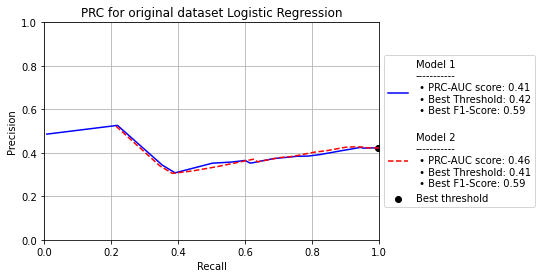

Best Threshold=0.394403, F1-Score=0.678 for model 1
Best Threshold=0.390212, F1-Score=0.678 for model 2


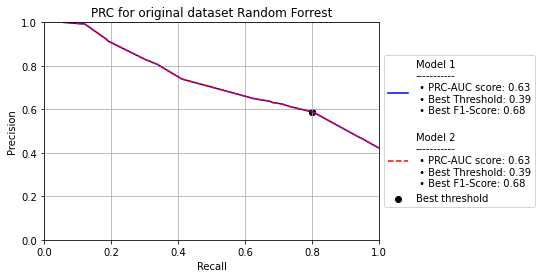

Best Threshold=0.389592, F1-Score=0.678 for model 1
Best Threshold=0.389599, F1-Score=0.678 for model 2


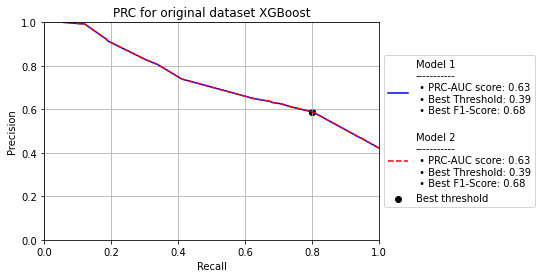

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.4177332844475333
Average Precision-Recall Score: 0.40575071492583925
PRC-AUC for model 1: 0.41114735821256493
Accuracy: 0.425
MCC for model 1: 0.04628969972873338
Precision score for model 1:  0.4229789516020914
Recall score for model 1:  0.9985757240069632
F1 score for model 1:  0.5942458916042755
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.01      0.02      8680
           1       0.42      1.00      0.59      6319

    accuracy                           0.43     14999
   macro avg       0.66      0.50      0.31     14999
weighted avg       0.69      0.43      0.26     14999


Scores for model 2
------------------
Roc_Auc Score: 0.41729136143428164
Average Precision-Recall Score: 0.40444579128712926
PRC-AUC for model 2: 0.46230910312585194
Precision score for model 2:  0.4226700589180504
Recall score for model 2:

TRAIN: [    0     1     2 ... 57423 57424 57425] | TEST: [42448 42449 42450 ... 59992 59993 59994]

Model Score: 0.4192365394232372

Average Precision-Recall Score: 0.4191397132377459
PRC-AUC Score: 0.4632135897934601
Precision:  0.4191397132377459
Recall:  1.0
F1:  0.5906954887218046
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3485
           1       0.42      1.00      0.59      2514

    accuracy                           0.42      5999
   macro avg       0.71      0.50      0.30      5999
weighted avg       0.76      0.42      0.25      5999

Accuracy: 0.419
MCC:  0.01096675180344823
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 57423 57424 57425] | TEST: [42448 42449 42450 ... 59992 59993 59994]

Model Score: 0.4192365394232372

Average Precision-Recall Score: 0.4191397132377459
PRC-AUC Score: 0.6696996056292381
Precision:  0.4191397132377459
Recall:  1.0
F1:  0.5906954887218046

TRAIN: [    0     1     2 ... 57423 57424 57425] | TEST: [42448 42449 42450 ... 59992 59993 59994]

Model Score: 0.4192365394232372

Average Precision-Recall Score: 0.4191397132377459
PRC-AUC Score: 0.31629315995855545
Precision:  0.4191397132377459
Recall:  1.0
F1:  0.5906954887218046
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3485
           1       0.42      1.00      0.59      2514

    accuracy                           0.42      5999
   macro avg       0.71      0.50      0.30      5999
weighted avg       0.76      0.42      0.25      5999

Accuracy: 0.419
MCC:  0.01096675180344823
Row 14 model 2

Model Score: 0.14611461146114613

Average Precision-Recall Score: 0.8538853885388539
PRC-AUC Score: 0.9019823529062307
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.15      1.00      0.25      1461
           1  

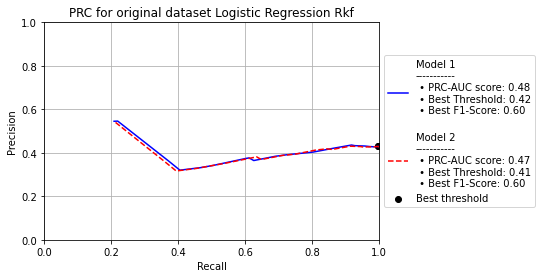

Best Threshold=0.325991, F1-Score=0.678 for model 1
Best Threshold=0.324433, F1-Score=0.678 for model 2


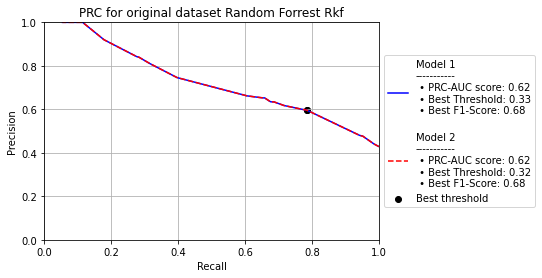

Best Threshold=0.330288, F1-Score=0.678 for model 1
Best Threshold=0.330232, F1-Score=0.678 for model 2


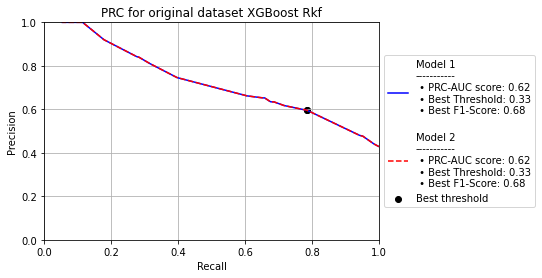

Best Threshold=0.418842, F1-Score=0.704 for model 1
Best Threshold=0.419032, F1-Score=0.613 for model 2


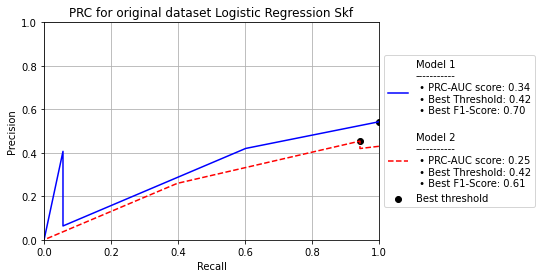

Best Threshold=0.904326, F1-Score=0.638 for model 1
Best Threshold=0.568322, F1-Score=0.592 for model 2


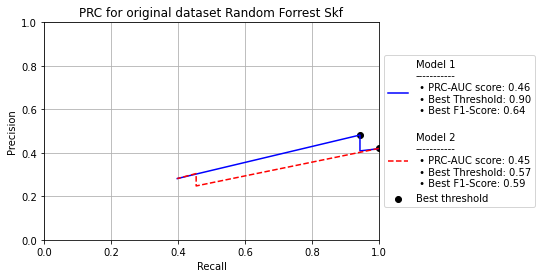

Best Threshold=0.999718, F1-Score=0.745 for model 1
Best Threshold=0.839204, F1-Score=0.659 for model 2


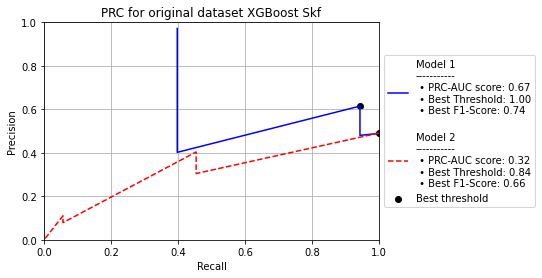

Best Threshold=0.328847, F1-Score=0.924 for model 1
Best Threshold=0.326432, F1-Score=0.925 for model 2


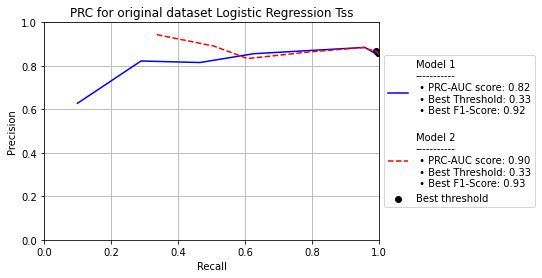

Best Threshold=0.000000, F1-Score=0.921 for model 1
Best Threshold=0.000000, F1-Score=0.921 for model 2


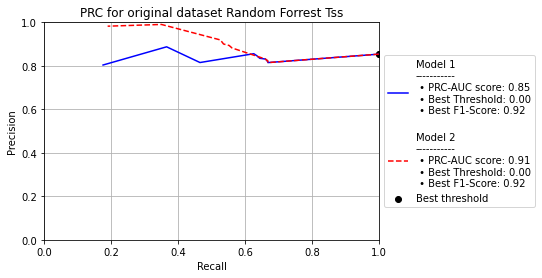

Best Threshold=0.000797, F1-Score=0.921 for model 1
Best Threshold=0.000318, F1-Score=0.921 for model 2


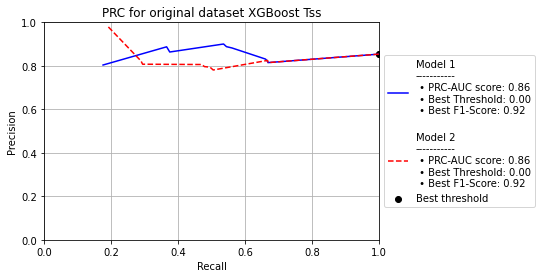

0    34852
1    25143
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.4213043997451773
Average Precision-Recall Score: 0.40391253454261944
PRC-AUC for model 1: 0.46291949868255083
Accuracy: 0.581
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      8714
           1       0.00      0.00      0.00      6285

    accuracy                           0.58     14999
   macro avg       0.29      0.50      0.37     14999
weighted avg       0.34      0.58      0.43     14999


Scores for model 2
------------------
Roc_Auc Score: 0.42115159011303965
Average Precision-Recall Score: 0.4027109365120537
PRC-AUC for model 2: 0.4618026420831732
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

            

TRAIN: [    0     1     2 ... 50283 50284 50285] | TEST: [   10    15    22 ... 50261 50265 50269]

Model Score: 0.4896579156722355

Average Precision-Recall Score: 0.48960444218937144
PRC-AUC Score: 0.5245142530309284
Precision:  0.4896041583366653
Recall:  0.9947197400487409
F1:  0.6562165058949625
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.01      0.01      2566
           1       0.49      0.99      0.66      2462

    accuracy                           0.49      5028
   macro avg       0.49      0.50      0.33      5028
weighted avg       0.49      0.49      0.33      5028

Accuracy: 0.490
MCC:  -0.0014915775002383915
TRAIN: [    0     1     2 ... 50283 50284 50285] | TEST: [   10    15    22 ... 50261 50265 50269]

Model Score: 0.4896579156722355

Average Precision-Recall Score: 0.48960444218937144
PRC-AUC Score: 0.7448289578361178
Precision:  0.4896041583366653
Recall:  0.9947197400487409
F1:  0.6562165058949625


TRAIN: [    0     1     2 ... 50283 50284 50285] | TEST: [   10    15    22 ... 50261 50265 50269]

Model Score: 0.4896579156722355

Average Precision-Recall Score: 0.48960444218937144
PRC-AUC Score: 0.7448289578361178
Precision:  0.4896041583366653
Recall:  0.9947197400487409
F1:  0.6562165058949625
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.01      0.01      2566
           1       0.49      0.99      0.66      2462

    accuracy                           0.49      5028
   macro avg       0.49      0.50      0.33      5028
weighted avg       0.49      0.49      0.33      5028

Accuracy: 0.490
MCC:  -0.0014915775002383915
TRAIN: [    0     1     2 ... 50283 50284 50285] | TEST: [   10    15    22 ... 50261 50265 50269]

Model Score: 0.48786793953858393

Average Precision-Recall Score: 0.48444730645777556
PRC-AUC Score: 0.4845652274184176
Precision:  0.48038875390489416
Recall:  0.5621445978878961
F1:  0.518061014411379

Recall score for model 1:  0.6585282373074729
F1 score for model 1:  0.6781811772999647
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      8661
           1       0.70      0.66      0.68      8765

    accuracy                           0.69     17426
   macro avg       0.69      0.69      0.69     17426
weighted avg       0.69      0.69      0.69     17426


Scores for model 2
------------------
Roc_Auc Score: 0.7497790681032196
Average Precision-Recall Score: 0.747273131314924
PRC-AUC for model 2: 0.7725130163296614
Precision score for model 2:  0.699043236042146
Recall score for model 2:  0.6585282373074729
F1 score for model 2:  0.6781811772999647
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      8661
           1       0.70      0.66      0.68      8765

    accuracy                           0.69     17426
   macro avg       0

TRAIN: [    0     1     2 ... 69700 69701 69703] | TEST: [   17    61    68 ... 69658 69679 69702]

Model Score: 0.6952654232424678

Average Precision-Recall Score: 0.6421367397080177
PRC-AUC Score: 0.6551658070715055
Precision:  0.7050570008769366
Recall:  0.6838673093280409
F1:  0.694300518134715
Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      3443
           1       0.71      0.68      0.69      3527

    accuracy                           0.70      6970
   macro avg       0.70      0.70      0.70      6970
weighted avg       0.70      0.70      0.70      6970

Accuracy: 0.695
MCC:  0.3908464603998889
TRAIN: [    0     1     2 ... 66216 66217 66218] | TEST: [42448 42449 42450 ... 69701 69702 69703]

Model Score: 0.3774748923959828

Average Precision-Recall Score: 0.45447698318563134
PRC-AUC Score: 0.4055101323232492
Precision:  0.37154031287605294
Recall:  0.35437589670014347
F1:  0.3627551769716551
Clas

TRAIN: [    0     1     2 ... 66216 66217 66218] | TEST: [42448 42449 42450 ... 69701 69702 69703]

Model Score: 0.4510760401721664

Average Precision-Recall Score: 0.47859913390283393
PRC-AUC Score: 0.4141575795298226
Precision:  0.43743119266055047
Recall:  0.34203730272596844
F1:  0.3838969404186795
Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.56      0.51      3485
           1       0.44      0.34      0.38      3485

    accuracy                           0.45      6970
   macro avg       0.45      0.45      0.44      6970
weighted avg       0.45      0.45      0.44      6970

Accuracy: 0.451
MCC:  -0.100261056897253
TRAIN: [    0     1     2 ... 66216 66217 66218] | TEST: [42448 42449 42450 ... 69701 69702 69703]

Model Score: 0.4510760401721664

Average Precision-Recall Score: 0.47859913390283393
PRC-AUC Score: 0.75
Precision:  0.43743119266055047
Recall:  0.34203730272596844
F1:  0.3838969404186795
Classification

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      8711
           1       0.69      0.69      0.69      8715

    accuracy                           0.69     17426
   macro avg       0.69      0.69      0.69     17426
weighted avg       0.69      0.69      0.69     17426

Accuracy: 0.691
MCC for model 2: 0.3829911920553588

Scores for model 1
------------------
Roc_Auc Score: 0.42467977754203584
Average Precision-Recall Score: 0.4834407307747212
PRC-AUC for model 1: 0.5348621450675367
Accuracy: 0.500
MCC for model 1: 0.0
Precision score for model 1:  0.5001147710317916
Recall score for model 1:  1.0
F1 score for model 1:  0.6667686775563291
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8711
           1       0.50      1.00      0.67      8715

    accuracy                           0.50     17426
   macro avg       0.25      0.50      0.33     17426
w

TRAIN: [    0     1     2 ... 66216 66217 66218] | TEST: [31367 31368 31369 ... 69701 69702 69703]

Model Score: 0.33486370157819223

Average Precision-Recall Score: 0.4337694715114187
PRC-AUC Score: 0.49091006598933556
Precision:  0.4010658414990545
Recall:  0.6694404591104735
F1:  0.5016125564394754
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3485
           1       0.40      0.67      0.50      3485

    accuracy                           0.33      6970
   macro avg       0.20      0.33      0.25      6970
weighted avg       0.20      0.33      0.25      6970

Accuracy: 0.335
MCC:  -0.4444379524244378
Row 67 model 1
TRAIN: [    0     1     2 ... 66216 66217 66218] | TEST: [31367 31368 31369 ... 69701 69702 69703]

Model Score: 0.33486370157819223

Average Precision-Recall Score: 0.4337694715114187
PRC-AUC Score: 0.48017602542735605
Precision:  0.4010658414990545
Recall:  0.6694404591104735
F1:  0.501

TRAIN: [    0     1     2 ... 66216 66217 66218] | TEST: [31367 31368 31369 ... 69701 69702 69703]

Model Score: 0.3347202295552367

Average Precision-Recall Score: 0.43372332340191944
PRC-AUC Score: 0.4098117585586504
Precision:  0.4009969061533173
Recall:  0.6694404591104735
F1:  0.5015586369988175
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3485
           1       0.40      0.67      0.50      3485

    accuracy                           0.33      6970
   macro avg       0.20      0.33      0.25      6970
weighted avg       0.20      0.33      0.25      6970

Accuracy: 0.335
MCC:  -0.4449788620747792

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   11617.0

    a

Performing analysis for: Geronimo
                           Name  \
1831                 Haihong Xu   
1832                 Haihong Xu   
1833                 Haihong Xu   
1834                 Haihong Xu   
1835                 Haihong Xu   
...                         ...   
120723  Hemapani Srinath Perera   
120724  Hemapani Srinath Perera   
120725  Hemapani Srinath Perera   
120726  Hemapani Srinath Perera   
120727  Hemapani Srinath Perera   

                                                     File                 Bug  \
1831    plugins/tomcat/geronimo-tomcat7/src/main/java/...  INTRODUCED_NEW_BUG   
1832    plugins/tomcat/geronimo-tomcat7/src/main/java/...  INTRODUCED_NEW_BUG   
1833    plugins/j2ee/geronimo-web/src/main/java/org/ap...  INTRODUCED_NEW_BUG   
1834    plugins/tomcat/geronimo-tomcat7/src/main/java/...  INTRODUCED_NEW_BUG   
1835    plugins/tomcat/geronimo-tomcat7/src/main/java/...  INTRODUCED_NEW_BUG   
...                                                   ...  


Accuracy: 0.650
MCC for model 2: 0.27497958714588944
Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7003187364659249
Average Precision-Recall Score: 0.6131992338501538
PRC-AUC for model 1: 0.6322777896947959
Accuracy: 0.650
MCC for model 1: 0.27497958714588944
Precision score for model 1:  0.7143619861185264
Recall score for model 1:  0.3094595636419705
F1 score for model 1:  0.43184507799892413
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.91      0.75     17212
           1       0.71      0.31      0.43     12971

    accuracy                           0.65     30183
   macro avg       0.67      0.61      0.59     30183
weighted avg       0.67      0.65      0.61     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7003178540741943
Average Precision-Recall Score: 0.6131990055810254
PRC-AUC for model 2: 0.6322775549603044
Precision score for model 2:  0.7143619861185264
Recall

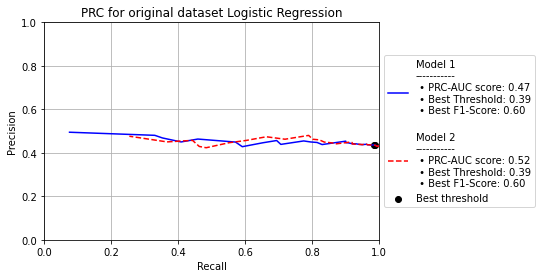

Best Threshold=0.309650, F1-Score=0.641 for model 1
Best Threshold=0.310327, F1-Score=0.641 for model 2


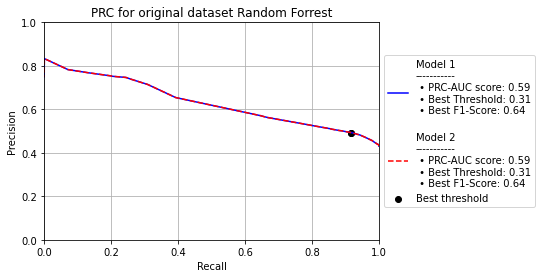

Best Threshold=0.308469, F1-Score=0.641 for model 1
Best Threshold=0.308865, F1-Score=0.641 for model 2


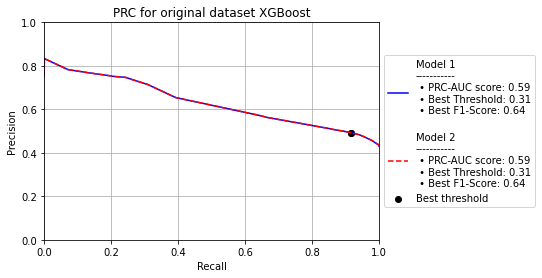

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5408422783816731
Average Precision-Recall Score: 0.460868869748582
PRC-AUC for model 1: 0.47496405006978815
Accuracy: 0.447
MCC for model 1: 0.0764410477086865
Precision score for model 1:  0.43646616541353384
Recall score for model 1:  0.9845809883586462
F1 score for model 1:  0.6048163671236768
Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.04      0.08     17212
           1       0.44      0.98      0.60     12971

    accuracy                           0.45     30183
   macro avg       0.61      0.51      0.34     30183
weighted avg       0.63      0.45      0.31     30183


Scores for model 2
------------------
Roc_Auc Score: 0.5466583059229019
Average Precision-Recall Score: 0.459744428062375
PRC-AUC for model 2: 0.5213174752163428
Precision score for model 2:  0.43519429832004075
Recall score for model 2:  0.9

TRAIN: [     0      1      2 ... 109959 109960 109961] | TEST: [106331 106332 106333 ... 120727 120728 120729]

Model Score: 0.45614180402551147

Average Precision-Recall Score: 0.4042872207643409
PRC-AUC Score: 0.43128116544091033
Precision:  0.3590725806451613
Recall:  0.3446207430340557
F1:  0.35169826224328593
Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.54      0.53      6905
           1       0.36      0.34      0.35      5168

    accuracy                           0.46     12073
   macro avg       0.44      0.44      0.44     12073
weighted avg       0.45      0.46      0.45     12073

Accuracy: 0.456
MCC:  -0.11643215276461513
Original_XGB_Classifier_skf model 1
TRAIN: [     0      1      2 ... 109959 109960 109961] | TEST: [106331 106332 106333 ... 120727 120728 120729]

Model Score: 0.4582953698335128

Average Precision-Recall Score: 0.4049392962301237
PRC-AUC Score: 0.43522392065740845
Precision:  0.360964734

TRAIN: [     0      1      2 ... 109959 109960 109961] | TEST: [106331 106332 106333 ... 120727 120728 120729]

Model Score: 0.4556448273005881

Average Precision-Recall Score: 0.407000592414942
PRC-AUC Score: 0.43441071437796097
Precision:  0.3780403057678944
Recall:  0.42105263157894735
F1:  0.39838886854632
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.48      0.50      6905
           1       0.38      0.42      0.40      5168

    accuracy                           0.46     12073
   macro avg       0.45      0.45      0.45     12073
weighted avg       0.46      0.46      0.46     12073

Accuracy: 0.456
MCC:  -0.09650300406848437
Row 14 model 2

Model Score: 0.5508672531186323

Average Precision-Recall Score: 0.44913274688136773
PRC-AUC Score: 0.5294281143649555
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.55      1.00      0.7

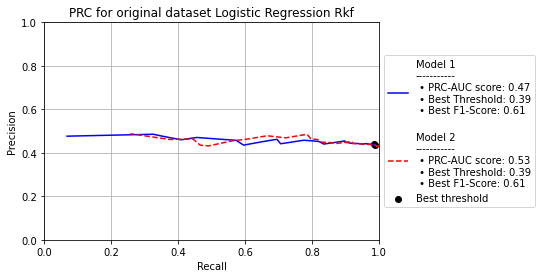

Best Threshold=0.311634, F1-Score=0.646 for model 1
Best Threshold=0.309747, F1-Score=0.646 for model 2


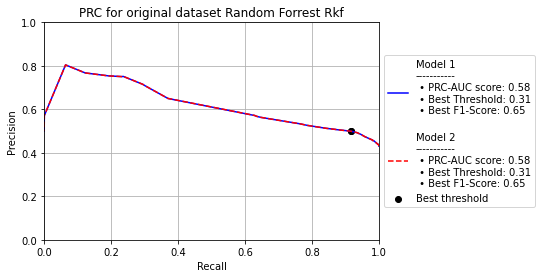

Best Threshold=0.309706, F1-Score=0.646 for model 1
Best Threshold=0.309508, F1-Score=0.646 for model 2


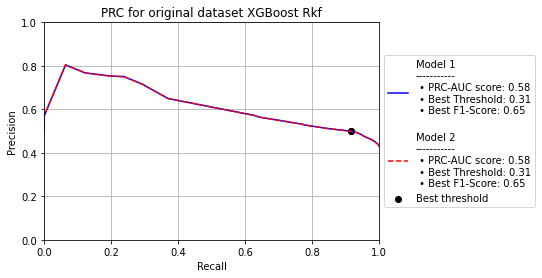

Best Threshold=0.401641, F1-Score=0.619 for model 1
Best Threshold=0.400656, F1-Score=0.619 for model 2


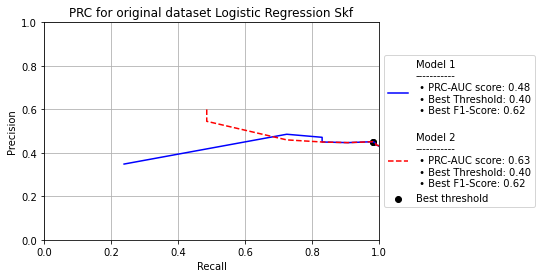

Best Threshold=0.151540, F1-Score=0.606 for model 1
Best Threshold=0.333748, F1-Score=0.626 for model 2


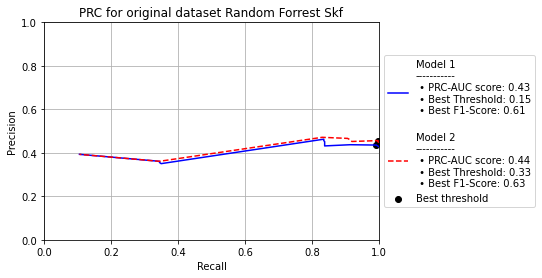

Best Threshold=0.124799, F1-Score=0.605 for model 1
Best Threshold=0.240658, F1-Score=0.628 for model 2


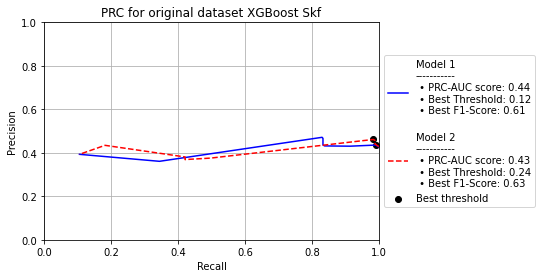

Best Threshold=0.396014, F1-Score=0.636 for model 1
Best Threshold=0.392998, F1-Score=0.636 for model 2


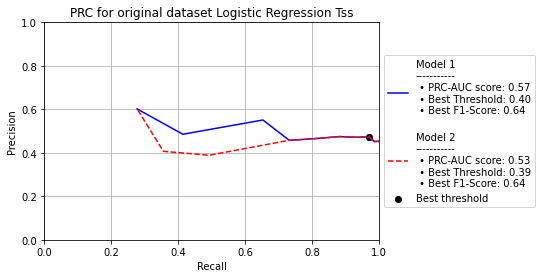

Best Threshold=0.000000, F1-Score=0.620 for model 1
Best Threshold=0.000000, F1-Score=0.620 for model 2


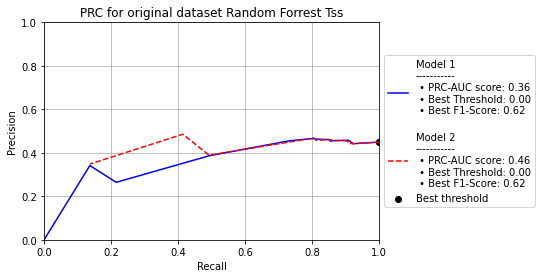

Best Threshold=0.001775, F1-Score=0.620 for model 1
Best Threshold=0.000513, F1-Score=0.620 for model 2


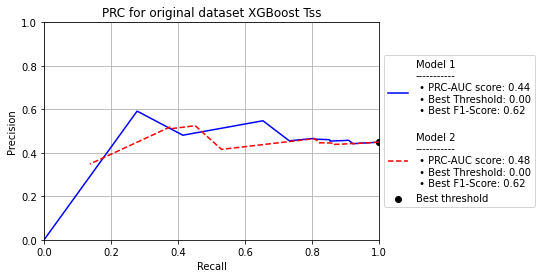

0    69051
1    51679
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5421817516913152
Average Precision-Recall Score: 0.45971044818495954
PRC-AUC for model 1: 0.480543204541654
Accuracy: 0.572
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17257
           1       0.00      0.00      0.00     12926

    accuracy                           0.57     30183
   macro avg       0.29      0.50      0.36     30183
weighted avg       0.33      0.57      0.42     30183


Scores for model 2
------------------
Roc_Auc Score: 0.5503369678929161
Average Precision-Recall Score: 0.45984968700897483
PRC-AUC for model 2: 0.5255329683354796
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              

TRAIN: [     0      2      3 ... 103355 103356 103357] | TEST: [     1      4     15 ... 103311 103322 103323]

Model Score: 0.49579100145137883

Average Precision-Recall Score: 0.5067102916785203
PRC-AUC Score: 0.5085764485523293
Precision:  0.5202558635394456
Recall:  0.046653919694072656
F1:  0.08562905772942621
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.96      0.65      5105
           1       0.52      0.05      0.09      5230

    accuracy                           0.50     10335
   macro avg       0.51      0.50      0.37     10335
weighted avg       0.51      0.50      0.37     10335

Accuracy: 0.496
MCC:  0.006196185176530953
TRAIN: [     0      2      3 ... 103355 103356 103357] | TEST: [     1      4     15 ... 103311 103322 103323]

Model Score: 0.49579100145137883

Average Precision-Recall Score: 0.5067102916785203
PRC-AUC Score: 0.7530237058538946
Precision:  0.5202558635394456
Recall:  0.0466539196940726

TRAIN: [     0      2      3 ... 103355 103356 103357] | TEST: [     1      4     15 ... 103311 103322 103323]

Model Score: 0.4934687953555878

Average Precision-Recall Score: 0.5056877289218772
PRC-AUC Score: 0.7530237058538946
Precision:  0.48878923766816146
Recall:  0.02084130019120459
F1:  0.039977993764900056
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.98      0.66      5105
           1       0.49      0.02      0.04      5230

    accuracy                           0.49     10335
   macro avg       0.49      0.50      0.35     10335
weighted avg       0.49      0.49      0.34     10335

Accuracy: 0.493
MCC:  -0.005126140538874773
TRAIN: [     0      2      3 ... 103355 103356 103357] | TEST: [     1      4     15 ... 103311 103322 103323]

Model Score: 0.4949201741654572

Average Precision-Recall Score: 0.5036645659624673
PRC-AUC Score: 0.49988711273502767
Precision:  0.5010121457489879
Recall:  0.473231357552581

Precision score for model 1:  0.6301155714365474
Recall score for model 1:  0.6562009419152276
F1 score for model 1:  0.6428937624608373
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.62      0.63     17327
           1       0.63      0.66      0.64     17199

    accuracy                           0.64     34526
   macro avg       0.64      0.64      0.64     34526
weighted avg       0.64      0.64      0.64     34526


Scores for model 2
------------------
Roc_Auc Score: 0.6986343273805451
Average Precision-Recall Score: 0.672940392952051
PRC-AUC for model 2: 0.6897287229762225
Precision score for model 2:  0.6301155714365474
Recall score for model 2:  0.6562009419152276
F1 score for model 2:  0.6428937624608373
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.62      0.63     17327
           1       0.63      0.66      0.64     17199

    accuracy            

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     5     10     18 ... 138077 138090 138098]

Model Score: 0.6469949312092687

Average Precision-Recall Score: 0.5914412399463186
PRC-AUC Score: 0.6525613564611661
Precision:  0.6427540415704388
Recall:  0.6497884138333576
F1:  0.6462520862056453
Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      6957
           1       0.64      0.65      0.65      6853

    accuracy                           0.65     13810
   macro avg       0.65      0.65      0.65     13810
weighted avg       0.65      0.65      0.65     13810

Accuracy: 0.647
MCC:  0.2940249154617265
Row 45 model 1
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     5     10     18 ... 138077 138090 138098]

Model Score: 0.6469949312092687

Average Precision-Recall Score: 0.5914412399463186
PRC-AUC Score: 0.6525252824869847
Precision:  0.6427540415704388
Recall:  0.64978841

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     5     10     18 ... 138077 138090 138098]

Model Score: 0.6469949312092687

Average Precision-Recall Score: 0.5914412399463186
PRC-AUC Score: 0.6527512171456887
Precision:  0.6427540415704388
Recall:  0.6497884138333576
F1:  0.6462520862056453
Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      6957
           1       0.64      0.65      0.65      6853

    accuracy                           0.65     13810
   macro avg       0.65      0.65      0.65     13810
weighted avg       0.65      0.65      0.65     13810

Accuracy: 0.647
MCC:  0.2940249154617265
TRAIN: [     0      1      2 ... 131194 131195 131196] | TEST: [106331 106332 106333 ... 138099 138100 138101]

Model Score: 0.6078204199855177

Average Precision-Recall Score: 0.5617013681679717
PRC-AUC Score: 0.7509626950752797
Precision:  0.572260506648549
Recall:  0.8538740043446778
F1:  0.

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     17300
           1       0.63      0.64      0.64     17226

    accuracy                           0.64     34526
   macro avg       0.64      0.64      0.64     34526
weighted avg       0.64      0.64      0.64     34526


Scores for model 2
------------------
Roc_Auc Score: 0.701140398738565
Average Precision-Recall Score: 0.6753901682569003
PRC-AUC for model 2: 0.6883719276353794
Precision score for model 2:  0.6343751798768203
Recall score for model 2:  0.6397886915128295
F1 score for model 2:  0.6370704355617214
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     17300
           1       0.63      0.64      0.64     17226

    accuracy                           0.64     34526
   macro avg       0.64      0.64      0.64     34526
weighted avg       0.64      0.64      0.64     34526

Accuracy: 0.636
MCC fo

TRAIN: [     0      1      2 ... 131194 131195 131196] | TEST: [ 62146  62147  62148 ... 138099 138100 138101]

Model Score: 0.5479362780593773

Average Precision-Recall Score: 0.5255101125999174
PRC-AUC Score: 0.7517624083327448
Precision:  0.5321671525753159
Recall:  0.7930485155684287
F1:  0.6369293399243967
Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.30      0.40      6905
           1       0.53      0.79      0.64      6905

    accuracy                           0.55     13810
   macro avg       0.56      0.55      0.52     13810
weighted avg       0.56      0.55      0.52     13810

Accuracy: 0.548
MCC:  0.10999652630067638
TRAIN: [     0      1      2 ... 131194 131195 131196] | TEST: [ 62146  62147  62148 ... 138099 138100 138101]

Model Score: 0.3833454018826937

Average Precision-Recall Score: 0.45025165454159244
PRC-AUC Score: 0.3889788194375855
Precision:  0.4264585045193098
Recall:  0.6764663287472846
F1: 

TRAIN: [     0      1      2 ... 131194 131195 131196] | TEST: [ 62146  62147  62148 ... 138099 138100 138101]

Model Score: 0.38522809558291093

Average Precision-Recall Score: 0.45093808313972517
PRC-AUC Score: 0.38931422910609026
Precision:  0.4274732314450444
Recall:  0.6764663287472846
F1:  0.5238896366083445
Classification Report:

              precision    recall  f1-score   support

           0       0.23      0.09      0.13      6905
           1       0.43      0.68      0.52      6905

    accuracy                           0.39     13810
   macro avg       0.33      0.39      0.33     13810
weighted avg       0.33      0.39      0.33     13810

Accuracy: 0.385
MCC:  -0.28239465593269325
Row 67 model 2
TRAIN: [     0      1      2 ... 131194 131195 131196] | TEST: [ 62146  62147  62148 ... 138099 138100 138101]

Model Score: 0.3718320057929037

Average Precision-Recall Score: 0.44612560459521694
PRC-AUC Score: 0.35617890385075984
Precision:  0.42034203420342037
Recall:  0.

Performing analysis for: Hadoop
                Name                                               File  \
3964       Duo Zhang  hbase-client/src/test/java/org/apache/hadoop/h...   
3965       Duo Zhang  hbase-client/src/main/java/org/apache/hadoop/h...   
3966       Duo Zhang  hbase-client/src/main/java/org/apache/hadoop/h...   
3967       Duo Zhang  hbase-client/src/test/java/org/apache/hadoop/h...   
3968       Duo Zhang  hbase-client/src/main/java/org/apache/hadoop/h...   
...              ...                                                ...   
128490  Doug Cutting      src/java/org/apache/hadoop/hbase/HLogKey.java   
128491  Doug Cutting    src/java/org/apache/hadoop/hbase/HStoreKey.java   
128492  Doug Cutting  src/java/org/apache/hadoop/hbase/HTableDescrip...   
128493  Doug Cutting      src/java/org/apache/hadoop/hbase/HMaster.java   
128494  Doug Cutting     src/java/org/apache/hadoop/hbase/HLogEdit.java   

                       Bug  PageRank  Betweenness  Closeness  Harmo

Roc_Auc Score: 0.7168623059789658
Average Precision-Recall Score: 0.7147693260032526
PRC-AUC for model 2: 0.7264254212863479
Precision score for model 2:  0.6269803786870465
Recall score for model 2:  0.8658247361555793
F1 score for model 2:  0.727295365689668
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.43      0.55     15258
           1       0.63      0.87      0.73     16866

    accuracy                           0.66     32124
   macro avg       0.69      0.65      0.64     32124
weighted avg       0.68      0.66      0.64     32124

Accuracy: 0.659
MCC for model 2: 0.3315217370908481
Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7170323738158475
Average Precision-Recall Score: 0.7149756320136991
PRC-AUC for model 1: 0.7267317729790376
Accuracy: 0.659
MCC for model 1: 0.3310508556286532
Precision score for model 1:  0.6269548032307957
Recall score for model 1:  0.8652318273449543
F1 s

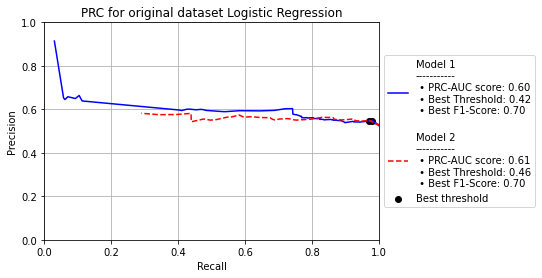

Best Threshold=0.361052, F1-Score=0.741 for model 1
Best Threshold=0.376382, F1-Score=0.741 for model 2


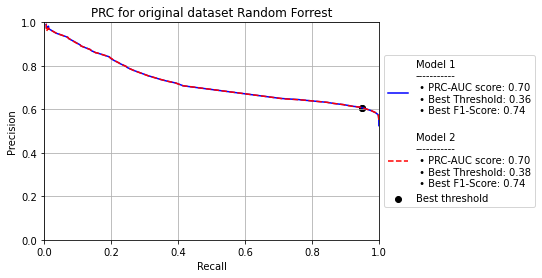

Best Threshold=0.362517, F1-Score=0.741 for model 1
Best Threshold=0.369542, F1-Score=0.741 for model 2


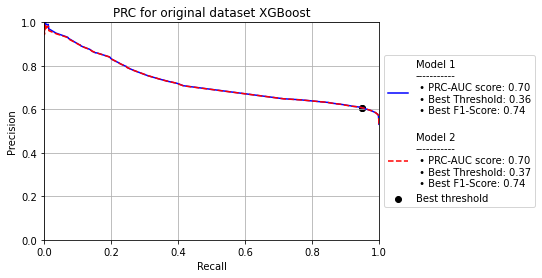

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5942326860796001
Average Precision-Recall Score: 0.5990636575130236
PRC-AUC for model 1: 0.598603851158674
Accuracy: 0.564
MCC for model 1: 0.17460201759823044
Precision score for model 1:  0.5472598879421808
Recall score for model 1:  0.9787145736985652
F1 score for model 1:  0.7019923876756895
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.10      0.19     15258
           1       0.55      0.98      0.70     16866

    accuracy                           0.56     32124
   macro avg       0.68      0.54      0.44     32124
weighted avg       0.68      0.56      0.46     32124


Scores for model 2
------------------
Roc_Auc Score: 0.5649309096085375
Average Precision-Recall Score: 0.5671046175151585
PRC-AUC for model 2: 0.6121605375333165
Precision score for model 2:  0.548640867702196
Recall score for model 2:  0.971

TRAIN: [     0      1      2 ... 120158 120159 120160] | TEST: [111071 111072 111073 ... 128493 128494 128495]

Model Score: 0.49396840221028876

Average Precision-Recall Score: 0.5120962736159453
PRC-AUC Score: 0.7503307417680288
Precision:  0.5103448275862069
Recall:  0.8780777217442896
F1:  0.6455130302039036
Classification Report:

              precision    recall  f1-score   support

           0       0.34      0.07      0.12      6107
           1       0.51      0.88      0.65      6742

    accuracy                           0.49     12849
   macro avg       0.43      0.47      0.38     12849
weighted avg       0.43      0.49      0.39     12849

Accuracy: 0.494
MCC:  -0.08766423762622462
Original_Random_Forrest_skf model 1
TRAIN: [     0      1      2 ... 120158 120159 120160] | TEST: [111071 111072 111073 ... 128493 128494 128495]

Model Score: 0.46299322904506185

Average Precision-Recall Score: 0.49793364010171626
PRC-AUC Score: 0.43182060013034196
Precision:  0.493199035

TRAIN: [     0      1      2 ... 120158 120159 120160] | TEST: [111071 111072 111073 ... 128493 128494 128495]

Model Score: 0.4500739357148416

Average Precision-Recall Score: 0.49417579373323367
PRC-AUC Score: 0.704851642585656
Precision:  0.4847601128880527
Recall:  0.7643132601601899
F1:  0.5932535113976514
Classification Report:

              precision    recall  f1-score   support

           0       0.28      0.10      0.15      6107
           1       0.48      0.76      0.59      6742

    accuracy                           0.45     12849
   macro avg       0.38      0.43      0.37     12849
weighted avg       0.39      0.45      0.38     12849

Accuracy: 0.450
MCC:  -0.17509169877211334
Row 12 model 2
TRAIN: [     0      1      2 ... 120158 120159 120160] | TEST: [111071 111072 111073 ... 128493 128494 128495]

Model Score: 0.28134485173943496

Average Precision-Recall Score: 0.45224596504725856
PRC-AUC Score: 0.4263843453230749
Precision:  0.3397221507589401
Recall:  0.3917

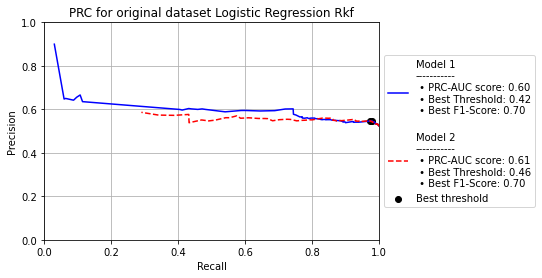

Best Threshold=0.400582, F1-Score=0.741 for model 1
Best Threshold=0.398149, F1-Score=0.741 for model 2


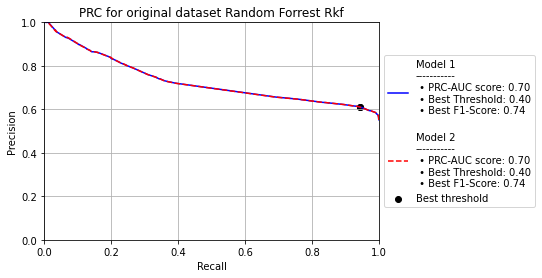

Best Threshold=0.412363, F1-Score=0.741 for model 1
Best Threshold=0.398789, F1-Score=0.741 for model 2


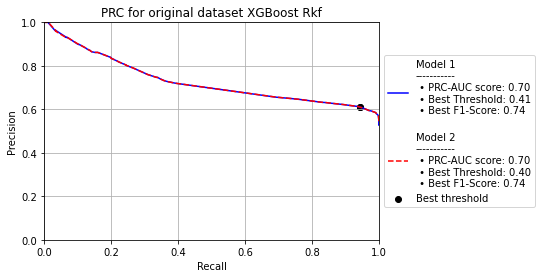

Best Threshold=0.003572, F1-Score=0.688 for model 1
Best Threshold=0.004557, F1-Score=0.688 for model 2


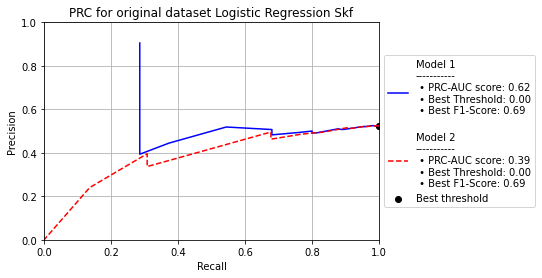

Best Threshold=0.000000, F1-Score=0.688 for model 1
Best Threshold=0.164512, F1-Score=0.688 for model 2


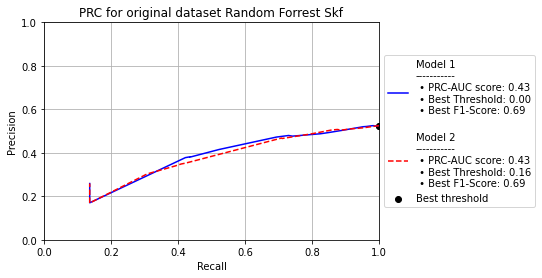

Best Threshold=0.000210, F1-Score=0.688 for model 1
Best Threshold=0.000242, F1-Score=0.688 for model 2


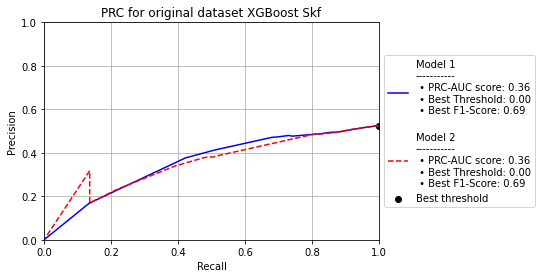

Best Threshold=0.004266, F1-Score=0.789 for model 1
Best Threshold=0.004527, F1-Score=0.789 for model 2


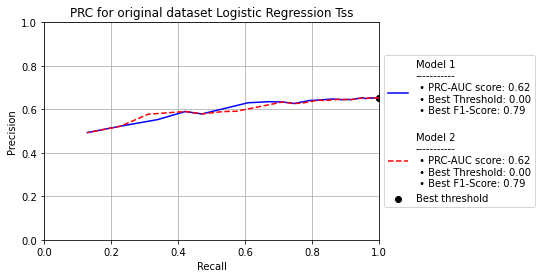

Best Threshold=0.004167, F1-Score=0.789 for model 1
Best Threshold=0.138676, F1-Score=0.790 for model 2


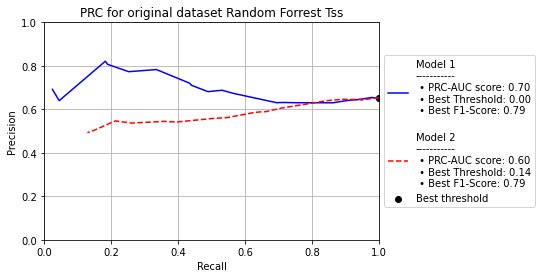

Best Threshold=0.000105, F1-Score=0.789 for model 1
Best Threshold=0.000193, F1-Score=0.789 for model 2


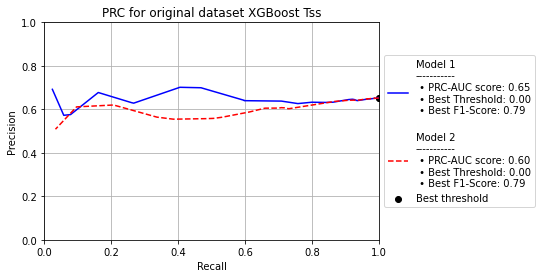

1    67424
0    61072
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5931586000135709
Average Precision-Recall Score: 0.5965842169145976
PRC-AUC for model 1: 0.6083025343830719
Accuracy: 0.563
MCC for model 1: 0.1184324152792182
Precision score for model 1:  0.5567364551702093
Recall score for model 1:  0.8258163930539916
F1 score for model 1:  0.6650915252619268
Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.27      0.37     15251
           1       0.56      0.83      0.67     16873

    accuracy                           0.56     32124
   macro avg       0.57      0.55      0.52     32124
weighted avg       0.57      0.56      0.53     32124


Scores for model 2
------------------
Roc_Auc Score: 0.5580190761421273
Average Precision-Recall Score: 0.562466627358724
PRC-AUC for model 2: 0.6225926298008511
Precision score for model 2:  0.5506472377449246
Recall score for model 

TRAIN: [     0      1      2 ... 122140 122142 122143] | TEST: [     3      9     10 ... 122130 122131 122141]

Model Score: 0.4902570820370067

Average Precision-Recall Score: 0.5004661730786817
PRC-AUC Score: 0.49561910210395527
Precision:  0.46562786434463793
Recall:  0.08258819704113152
F1:  0.14029273681303508
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.90      0.64      6063
           1       0.47      0.08      0.14      6151

    accuracy                           0.49     12214
   macro avg       0.48      0.49      0.39     12214
weighted avg       0.48      0.49      0.39     12214

Accuracy: 0.490
MCC:  -0.023786766806512358
TRAIN: [     0      1      2 ... 122140 122142 122143] | TEST: [     3      9     10 ... 122130 122131 122141]

Model Score: 0.4902570820370067

Average Precision-Recall Score: 0.5004661730786817
PRC-AUC Score: 0.7518012117242509
Precision:  0.46562786434463793
Recall:  0.082588197041131

TRAIN: [     0      1      2 ... 122140 122142 122143] | TEST: [     3      9     10 ... 122130 122131 122141]

Model Score: 0.49361388570492876

Average Precision-Recall Score: 0.5021205843932386
PRC-AUC Score: 0.7518012117242509
Precision:  0.473015873015873
Recall:  0.04844740692570314
F1:  0.08789264120336233
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.95      0.65      6063
           1       0.47      0.05      0.09      6151

    accuracy                           0.49     12214
   macro avg       0.48      0.50      0.37     12214
weighted avg       0.48      0.49      0.37     12214

Accuracy: 0.494
MCC:  -0.014266346506220166
TRAIN: [     0      1      2 ... 122140 122142 122143] | TEST: [     3      9     10 ... 122130 122131 122141]

Model Score: 0.5009824791223186

Average Precision-Recall Score: 0.5037518995600864
PRC-AUC Score: 0.5046170751243149
Precision:  0.5038535645472062
Recall:  0.5951877743456349
F


Scores for model 2
------------------
Roc_Auc Score: 0.7172882378247005
Average Precision-Recall Score: 0.6945370274973897
PRC-AUC for model 2: 0.7080229137689972
Precision score for model 2:  0.6125037238796442
Recall score for model 2:  0.8460905349794239
F1 score for model 2:  0.7105932307996149
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.45      0.56     16702
           1       0.61      0.85      0.71     17010

    accuracy                           0.65     33712
   macro avg       0.68      0.65      0.64     33712
weighted avg       0.68      0.65      0.64     33712

Accuracy: 0.652
MCC for model 2: 0.32741602035685474
-------------------------------
|Scores for XGBoost Classifier|
-------------------------------
Row 38 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7174749442997425
Average Precision-Recall Score: 0.6947209061336045
PRC-AUC for model 1: 0.7080477807543716
Accuracy: 0.652
MCC 

TRAIN: [     0      2      3 ... 134844 134846 134847] | TEST: [     1     10     11 ... 134804 134830 134845]

Model Score: 0.6532186294867992

Average Precision-Recall Score: 0.5951402838683308
PRC-AUC Score: 0.6813197317936608
Precision:  0.612767789858973
Recall:  0.8406439226111357
F1:  0.7088418430884185
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.46      0.57      6713
           1       0.61      0.84      0.71      6771

    accuracy                           0.65     13484
   macro avg       0.68      0.65      0.64     13484
weighted avg       0.68      0.65      0.64     13484

Accuracy: 0.653
MCC:  0.3292113140632615
TRAIN: [     0      1      2 ... 124936 124937 124938] | TEST: [120161 120162 120163 ... 134845 134846 134847]

Model Score: 0.462770691189558

Average Precision-Recall Score: 0.48235489908216445
PRC-AUC Score: 0.3935047404000667
Precision:  0.47395725254202115
Recall:  0.6775437555621477
F1:  0

TRAIN: [     0      1      2 ... 124936 124937 124938] | TEST: [120161 120162 120163 ... 134845 134846 134847]

Model Score: 0.4552061702758825

Average Precision-Recall Score: 0.47899196979673836
PRC-AUC Score: 0.36360553408988705
Precision:  0.46899383983572895
Recall:  0.6775437555621477
F1:  0.5543016624196093
Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.23      0.30      6742
           1       0.47      0.68      0.55      6742

    accuracy                           0.46     13484
   macro avg       0.44      0.46      0.43     13484
weighted avg       0.44      0.46      0.43     13484

Accuracy: 0.455
MCC:  -0.100020619506711
TRAIN: [     0      1      2 ... 124936 124937 124938] | TEST: [120161 120162 120163 ... 134845 134846 134847]

Model Score: 0.4552061702758825

Average Precision-Recall Score: 0.47899196979673836
PRC-AUC Score: 0.6794003944036586
Precision:  0.46899383983572895
Recall:  0.6775437555621477
F

              precision    recall  f1-score   support

           0       0.73      0.46      0.57     16863
           1       0.61      0.83      0.70     16849

    accuracy                           0.65     33712
   macro avg       0.67      0.65      0.63     33712
weighted avg       0.67      0.65      0.63     33712


Scores for model 2
------------------
Roc_Auc Score: 0.7140825182853611
Average Precision-Recall Score: 0.6899793291665862
PRC-AUC for model 2: 0.7027170291332598
Precision score for model 2:  0.6071413076489218
Recall score for model 2:  0.8305537420618434
F1 score for model 2:  0.7014887964308987
Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.46      0.57     16863
           1       0.61      0.83      0.70     16849

    accuracy                           0.65     33712
   macro avg       0.67      0.65      0.63     33712
weighted avg       0.67      0.65      0.63     33712

Accuracy: 0.647
MCC f

TRAIN: [     0      1      2 ... 128103 128104 128105] | TEST: [ 60682  60683  60684 ... 134845 134846 134847]

Model Score: 0.5512459210916641

Average Precision-Recall Score: 0.5273958118262135
PRC-AUC Score: 0.7397276491469856
Precision:  0.5345949734655051
Recall:  0.7919015129041828
F1:  0.6382927849841592
Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.31      0.41      6742
           1       0.53      0.79      0.64      6742

    accuracy                           0.55     13484
   macro avg       0.57      0.55      0.52     13484
weighted avg       0.57      0.55      0.52     13484

Accuracy: 0.551
MCC:  0.11692643438443519
TRAIN: [     0      1      2 ... 128103 128104 128105] | TEST: [ 60682  60683  60684 ... 134845 134846 134847]

Model Score: 0.6377929397804806

Average Precision-Recall Score: 0.5823882111482575
PRC-AUC Score: 0.5931198750957134
Precision:  0.5979131534569984
Recall:  0.8414417086917828
F1:  

TRAIN: [     0      1      2 ... 128103 128104 128105] | TEST: [ 60682  60683  60684 ... 134845 134846 134847]

Model Score: 0.6376446158409967

Average Precision-Recall Score: 0.5822906971550454
PRC-AUC Score: 0.5930011882745796
Precision:  0.5978490088570223
Recall:  0.8409967368733313
F1:  0.6988783433994823
Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.43      0.55      6742
           1       0.60      0.84      0.70      6742

    accuracy                           0.64     13484
   macro avg       0.66      0.64      0.62     13484
weighted avg       0.66      0.64      0.62     13484

Accuracy: 0.638
MCC:  0.3013368218776403
Row 67 model 2
TRAIN: [     0      1      2 ... 128103 128104 128105] | TEST: [ 60682  60683  60684 ... 134845 134846 134847]

Model Score: 0.6377187778107386

Average Precision-Recall Score: 0.582343717197816
PRC-AUC Score: 0.5884506070836528
Precision:  0.5979120531477381
Recall:  0.840996736

Performing analysis for: HBase
                 Name                                               File  \
126908  Owen O'Malley  src/docs/src/documentation/resources/images/hd...   
126909  Owen O'Malley  src/docs/src/documentation/content/xdocs/hod_a...   
126910  Owen O'Malley  src/docs/cn/src/documentation/classes/CatalogM...   
126911  Owen O'Malley  src/docs/cn/src/documentation/resources/images...   
126912  Owen O'Malley  src/docs/cn/src/documentation/skins/common/scr...   
...               ...                                                ...   
127498  Owen O'Malley  src/test/hdfs-with-mr/org/apache/hadoop/fs/Acc...   
127499  Owen O'Malley  src/test/lib/mina-core-2.0.0-M2-20080407.12410...   
127500  Owen O'Malley  src/test/hdfs-with-mr/org/apache/hadoop/hdfs/N...   
127501  Owen O'Malley  src/test/hdfs-with-mr/org/apache/hadoop/test/A...   
127502  Owen O'Malley     src/test/lib/ftpserver-core-1.0.0-SNAPSHOT.jar   

                       Bug  PageRank  Betweenness  Close

MCC for model 2: 0.0
Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.9978684531059683
Average Precision-Recall Score: 0.3403141361256545
PRC-AUC for model 1: 0.6701570680628273
Accuracy: 0.998
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59112
           1       0.00      0.00      0.00       130

    accuracy                           1.00     59242
   macro avg       0.50      0.50      0.50     59242
weighted avg       1.00      1.00      1.00     59242


Scores for model 2
------------------
Roc_Auc Score: 0.9978684531059684
Average Precision-Recall Score: 0.3403141361256545
PRC-AUC for model 2: 0.6701570680628273
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              precision    recall 

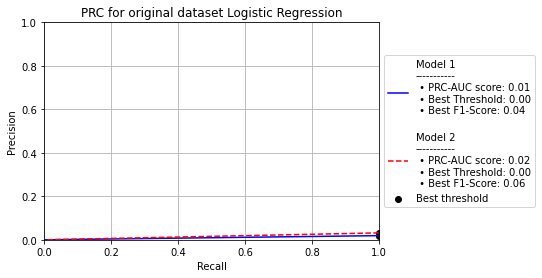

Best Threshold=0.347669, F1-Score=0.508 for model 1
Best Threshold=0.346712, F1-Score=0.508 for model 2


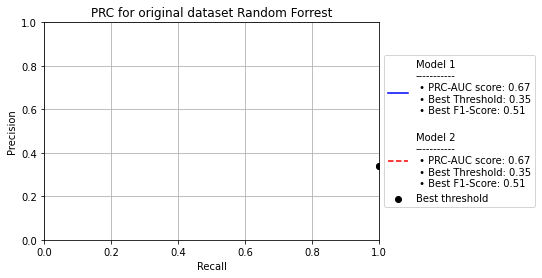

Best Threshold=0.347276, F1-Score=0.508 for model 1
Best Threshold=0.347558, F1-Score=0.508 for model 2


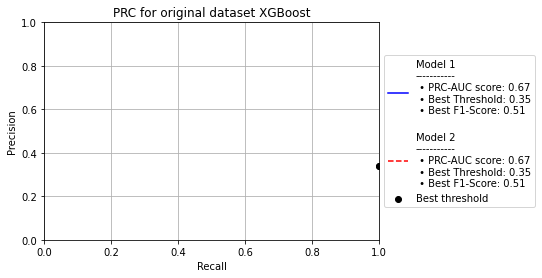

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.889379483015293
Average Precision-Recall Score: 0.01913171449595291
PRC-AUC for model 1: 0.009565857247976454
Accuracy: 0.887
MCC for model 1: 0.13028650813110093
Precision score for model 1:  0.01913171449595291
Recall score for model 1:  1.0
F1 score for model 1:  0.03754512635379062
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     59112
           1       0.02      1.00      0.04       130

    accuracy                           0.89     59242
   macro avg       0.51      0.94      0.49     59242
weighted avg       1.00      0.89      0.94     59242


Scores for model 2
------------------
Roc_Auc Score: 0.9352415753146569
Average Precision-Recall Score: 0.031831537708129284
PRC-AUC for model 2: 0.015915768854064642
Precision score for model 2:  0.031831537708129284
Recall score for model 2:  1.0
F1 s

TRAIN: [     0      1      2 ... 213326 213327 213328] | TEST: [127444 127445 127446 ... 236963 236964 236965]

Model Score: 0.9975101282916948

Average Precision-Recall Score: 0.002489871708305199
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23637
           1       0.00      0.00      0.00        59

    accuracy                           1.00     23696
   macro avg       0.50      0.50      0.50     23696
weighted avg       1.00      1.00      1.00     23696

Accuracy: 0.998
MCC:  0.0
Original_XGB_Classifier_skf model 1
TRAIN: [     0      1      2 ... 213326 213327 213328] | TEST: [127444 127445 127446 ... 236963 236964 236965]

Model Score: 0.9975101282916948

Average Precision-Recall Score: 0.002489871708305199
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support


Model Score: 1.0

Average Precision-Recall Score: nan
PRC-AUC Score: nan
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39494

    accuracy                           1.00     39494
   macro avg       1.00      1.00      1.00     39494
weighted avg       1.00      1.00      1.00     39494

Accuracy: 1.000
MCC:  0.0
Row 15 model 2

Model Score: 1.0

Average Precision-Recall Score: nan
PRC-AUC Score: nan
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39494

    accuracy                           1.00     39494
   macro avg       1.00      1.00      1.00     39494
weighted avg       1.00      1.00      1.00     39494

Accuracy: 1.000
MCC:  0.0
Row 16 model 2

Model Score: 1.0

Average Precision-Recall Score: nan
PRC-AUC Score: nan
Precision:  0.0
Recall:  0

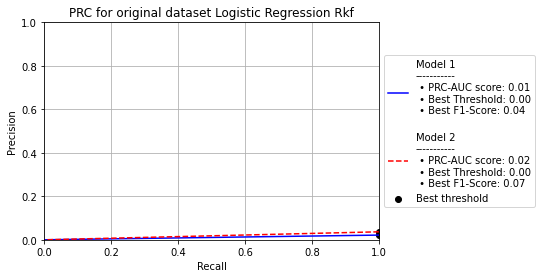

Best Threshold=0.345023, F1-Score=0.534 for model 1
Best Threshold=0.344752, F1-Score=0.534 for model 2


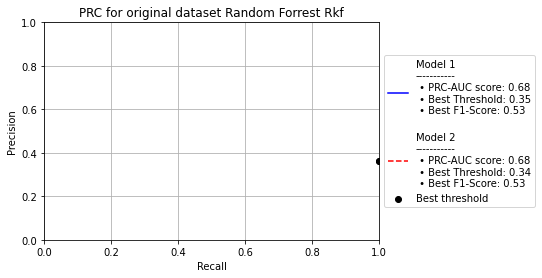

Best Threshold=0.343763, F1-Score=0.534 for model 1
Best Threshold=0.343984, F1-Score=0.534 for model 2


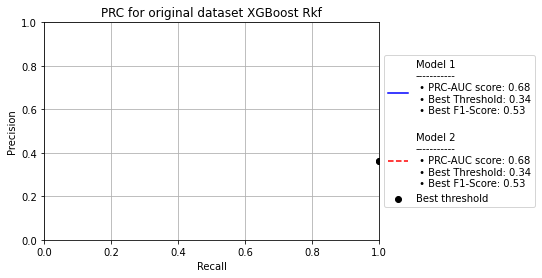

Best Threshold=0.003449, F1-Score=0.099 for model 1
Best Threshold=0.002820, F1-Score=0.041 for model 2


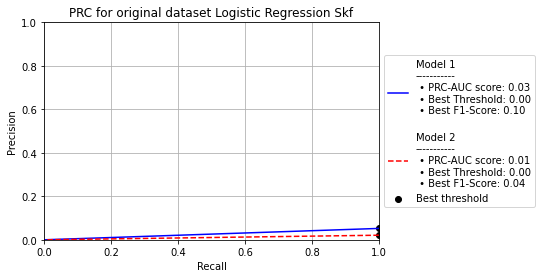

Best Threshold=0.324194, F1-Score=1.000 for model 1
Best Threshold=0.324647, F1-Score=1.000 for model 2


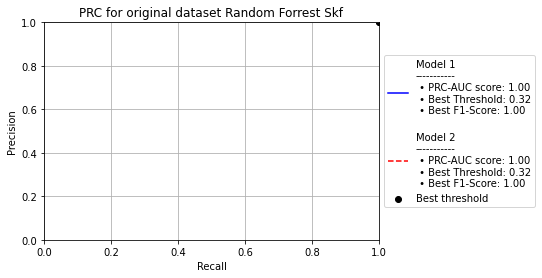

Best Threshold=0.322390, F1-Score=1.000 for model 1
Best Threshold=0.322630, F1-Score=1.000 for model 2


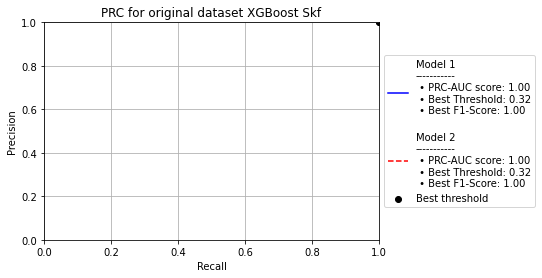

Best Threshold=0.053481, F1-Score=0.000 for model 1
Best Threshold=0.048088, F1-Score=0.000 for model 2


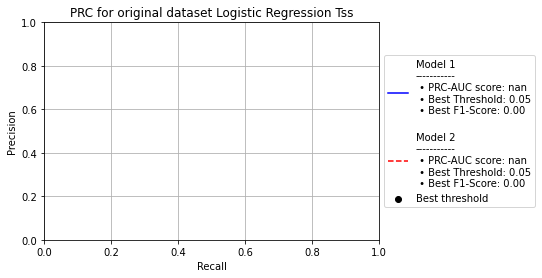

Best Threshold=0.000000, F1-Score=0.000 for model 1
Best Threshold=0.014670, F1-Score=0.000 for model 2


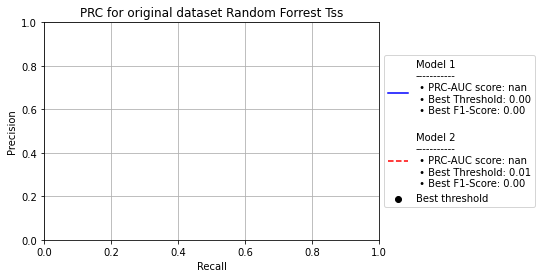

Best Threshold=0.000026, F1-Score=0.000 for model 1
Best Threshold=0.000634, F1-Score=0.000 for model 2


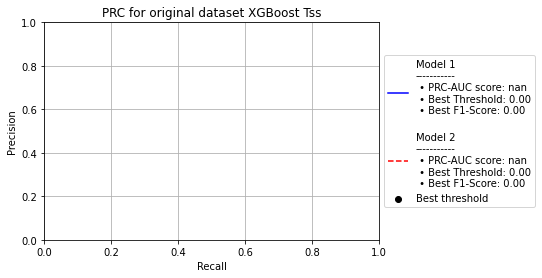

0    236371
1       595
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8887243369497149
Average Precision-Recall Score: 0.023184601924759404
PRC-AUC for model 1: 0.011592300962379702
Accuracy: 0.997
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59083
           1       0.00      0.00      0.00       159

    accuracy                           1.00     59242
   macro avg       0.50      0.50      0.50     59242
weighted avg       0.99      1.00      1.00     59242


Scores for model 2
------------------
Roc_Auc Score: 0.9363353248819457
Average Precision-Recall Score: 0.03930778739184178
PRC-AUC for model 2: 0.01965389369592089
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

       

TRAIN: [   0    1    2 ... 1187 1188 1189] | TEST: [  16   20   28   42   64   78   86   91  100  104  123  128  137  147
  154  163  168  172  182  191  199  212  231  241  245  262  276  307
  328  337  349  359  365  367  385  392  394  396  398  399  404  407
  419  421  424  435  441  448  454  462  464  466  482  492  496  498
  509  518  519  539  545  553  562  571  580  593  597  608  623  624
  628  649  660  663  671  699  702  714  725  741  743  758  763  767
  772  775  784  788  801  819  835  844  855  882  900  920  939  944
  945  955  961  962  981  991  994 1031 1033 1036 1040 1086 1103 1104
 1120 1123 1136 1156 1167 1181 1182]

Model Score: 0.453781512605042

Average Precision-Recall Score: 0.43913508799746315
PRC-AUC Score: 0.7226890756302521
Precision:  0.4375
Recall:  0.7924528301886793
F1:  0.5637583892617449
Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.18      0.27        66
           1       0.


Model Score: 0.010101010101010102

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0000000000000002
Precision:  1.0
Recall:  0.010101010101010102
F1:  0.02
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.01      0.02       198

    accuracy                           0.01       198
   macro avg       0.50      0.01      0.01       198
weighted avg       1.00      0.01      0.02       198

Accuracy: 0.010
MCC:  0.0
Row 35 model 1

Model Score: 0.015151515151515152

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0000000000000002
Precision:  1.0
Recall:  0.015151515151515152
F1:  0.02985074626865672
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.02      0.03       198

    accuracy                           0.02       198
   macro avg       0.50    

TRAIN: [   0    1    2 ... 1127 1128 1129] | TEST: [ 536  537  538  539  540  541  542  543  544  545  546  547  548  549
  550  551  552  553  554  555  556  557  558  559  560  561  562  563
  564  565  566  567  568  569  570  571  572  573  574  575  576  577
  578  579  580  581  582  583  584  585  586  587  588  589  590  591
  592  593  594 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1140
 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154
 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167 1168
 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182
 1183 1184 1185 1186 1187 1188 1189]

Model Score: 0.33613445378151263

Average Precision-Recall Score: 0.4731363513147194
PRC-AUC Score: 0.3243866357569953
Precision:  0.1935483870967742
Recall:  0.1
F1:  0.13186813186813187
Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.58      0.46        59
           1       0.1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59067
           1       1.00      1.00      1.00     59119

    accuracy                           1.00    118186
   macro avg       1.00      1.00      1.00    118186
weighted avg       1.00      1.00      1.00    118186

Accuracy: 0.998
MCC for model 2: 0.9953065545254222

Scores for model 1
------------------
Roc_Auc Score: 0.9028052889092048
Average Precision-Recall Score: 0.9095370698010738
PRC-AUC for model 1: 0.4547685349005369
Accuracy: 0.500
MCC for model 1: 0.0
Precision score for model 1:  0.50021999221566
Recall score for model 1:  1.0
F1 score for model 1:  0.6668621866275627
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     59067
           1       0.50      1.00      0.67     59119

    accuracy                           0.50    118186
   macro avg       0.25      0.50      0.33    118186
weig

TRAIN: [     0      1      2 ... 449102 449103 449104] | TEST: [213329 213330 213331 ... 472739 472740 472741]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23637
           1       1.00      1.00      1.00     23637

    accuracy                           1.00     47274
   macro avg       1.00      1.00      1.00     47274
weighted avg       1.00      1.00      1.00     47274

Accuracy: 1.000
MCC:  1.0
Row 49 model 1
TRAIN: [     0      1      2 ... 449102 449103 449104] | TEST: [213329 213330 213331 ... 472739 472740 472741]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23637
           1       1.00      


Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     78790

    accuracy                           1.00     78790
   macro avg       1.00      1.00      1.00     78790
weighted avg       1.00      1.00      1.00     78790

Accuracy: 1.000
MCC:  0.0

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     78790

    accuracy                           1.00     78790
   macro avg       1.00      1.00      1.00     78790
weighted avg       1.00      1.00      1.00     78790

Accuracy: 1.000
MCC:  0.0

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Classification Rep

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59074
           1       1.00      1.00      1.00     59112

    accuracy                           1.00    118186
   macro avg       1.00      1.00      1.00    118186
weighted avg       1.00      1.00      1.00    118186

Accuracy: 0.998
MCC for model 2: 0.995306557557256
Row 59 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.9976470189931274
Average Precision-Recall Score: 0.9953190772857383
PRC-AUC for model 1: 0.9976595386428692
Accuracy: 0.998
MCC for model 1: 0.995306557557256
Precision score for model 1:  0.9953190772857383
Recall score for model 1:  1.0
F1 score for model 1:  0.9976540480329446
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59074
           1       1.00      1.00      1.00     59112

    accuracy                           1.00    118186
   macro avg       1.00     


Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     78790

    accuracy                           1.00     78790
   macro avg       1.00      1.00      1.00     78790
weighted avg       1.00      1.00      1.00     78790

Accuracy: 1.000
MCC:  0.0
TRAIN: [     0      1      2 ... 472739 472740 472741] | TEST: [     6     16     17 ... 472690 472728 472738]

Model Score: 0.9573973008419004

Average Precision-Recall Score: 0.9217894450700944
PRC-AUC Score: 0.4697605187153099
Precision:  0.9217894450700944
Recall:  1.0
F1:  0.959303265438086
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.91      0.96     23537
           1       0.92      1.00      0.96     23737

    accuracy                           0.96     47274
   macro avg       0.96   

Performing analysis for: Ivy
                Name                                               File  \
3835   Maarten Coene       src/java/org/apache/ivy/core/IvyContext.java   
3836   Maarten Coene                                        CHANGES.txt   
3837   Maarten Coene  src/java/org/apache/ivy/plugins/resolver/Abstr...   
3838   Maarten Coene  src/java/org/apache/ivy/plugins/resolver/Basic...   
3839   Maarten Coene  src/java/org/apache/ivy/plugins/resolver/Repos...   
...              ...                                                ...   
24439             mm  src/example/configurations/multi-projects/filt...   
24440             mm  src/example/configurations/multi-projects/myap...   
24442             mb     src/java/fr/jayasoft/ivy/report/ivy-report.xsl   
24443             mb  src/java/fr/jayasoft/ivy/report/XmlReportOutpu...   
24444             mb     src/java/fr/jayasoft/ivy/report/ivy-report.xsl   

                      Bug  PageRank  Betweenness  Closeness  Harmonic 

Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8917230874227365
Average Precision-Recall Score: 0.7205075327101281
PRC-AUC for model 1: 0.8467811194239913
Accuracy: 0.852
MCC for model 1: 0.7058993869104574
Precision score for model 1:  0.7297698589458055
Recall score for model 1:  0.9178338001867413
F1 score for model 1:  0.8130686517783291
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      3973
           1       0.73      0.92      0.81      2142

    accuracy                           0.85      6115
   macro avg       0.84      0.87      0.85      6115
weighted avg       0.87      0.85      0.86      6115


Scores for model 2
------------------
Roc_Auc Score: 0.8917912412049307
Average Precision-Recall Score: 0.7205645978984719
PRC-AUC for model 2: 0.8468344380990948
Precision score for model 2:  0.7297698589458055
Recall score for model 2:  0.9178338001867413
F1 score for mod

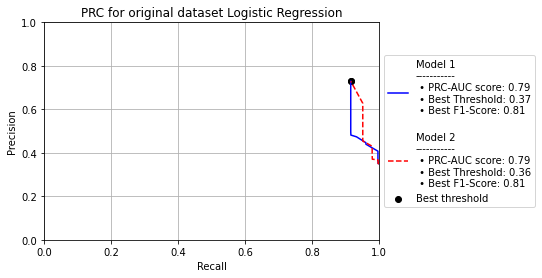

Best Threshold=0.721432, F1-Score=0.813 for model 1
Best Threshold=0.721993, F1-Score=0.813 for model 2


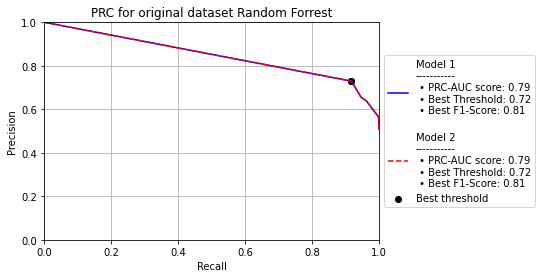

Best Threshold=0.721814, F1-Score=0.813 for model 1
Best Threshold=0.721814, F1-Score=0.813 for model 2


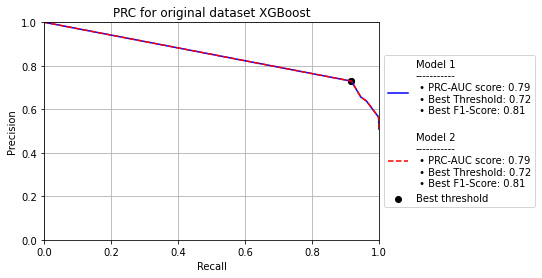

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8611554110695372
Average Precision-Recall Score: 0.7044042245968
PRC-AUC for model 1: 0.7920214926119146
Accuracy: 0.852
MCC for model 1: 0.704216646827748
Precision score for model 1:  0.729368029739777
Recall score for model 1:  0.9159663865546218
F1 score for model 1:  0.8120860927152318
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      3973
           1       0.73      0.92      0.81      2142

    accuracy                           0.85      6115
   macro avg       0.84      0.87      0.84      6115
weighted avg       0.87      0.85      0.85      6115


Scores for model 2
------------------
Roc_Auc Score: 0.8704025867415511
Average Precision-Recall Score: 0.7100337042438813
PRC-AUC for model 2: 0.7920214926119146
Precision score for model 2:  0.729368029739777
Recall score for model 2:  0.91596638

TRAIN: [    0     1     2 ... 23579 23580 23581] | TEST: [14906 14907 14908 ... 24454 24455 24456]

Model Score: 0.3496932515337423

Average Precision-Recall Score: 0.34916836586760497
PRC-AUC Score: 0.667032998407863
Precision:  0.3490878938640133
Recall:  0.9767981438515081
F1:  0.51435552840562
Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.01      0.02      1583
           1       0.35      0.98      0.51       862

    accuracy                           0.35      2445
   macro avg       0.37      0.49      0.27      2445
weighted avg       0.38      0.35      0.19      2445

Accuracy: 0.350
MCC:  -0.06206382527279201
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 23579 23580 23581] | TEST: [14906 14907 14908 ... 24454 24455 24456]

Model Score: 0.3496932515337423

Average Precision-Recall Score: 0.34916836586760497
PRC-AUC Score: 0.667032998407863
Precision:  0.3490878938640133
Recall:  0.97679814385

TRAIN: [    0     1     2 ... 23579 23580 23581] | TEST: [14906 14907 14908 ... 24454 24455 24456]

Model Score: 0.3496932515337423

Average Precision-Recall Score: 0.34916836586760497
PRC-AUC Score: 0.6658213258989347
Precision:  0.3490878938640133
Recall:  0.9767981438515081
F1:  0.51435552840562
Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.01      0.02      1583
           1       0.35      0.98      0.51       862

    accuracy                           0.35      2445
   macro avg       0.37      0.49      0.27      2445
weighted avg       0.38      0.35      0.19      2445

Accuracy: 0.350
MCC:  -0.06206382527279201
Row 14 model 2

Model Score: 0.0031894013738959764

Average Precision-Recall Score: 0.996810598626104
PRC-AUC Score: 0.9992611141815106
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      1.00      0.01        13

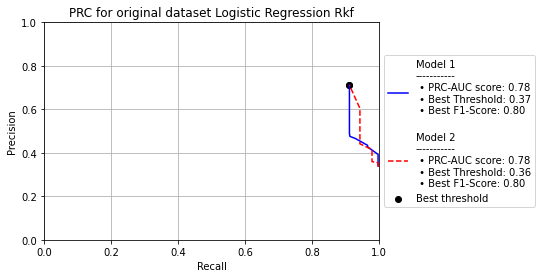

Best Threshold=0.724683, F1-Score=0.800 for model 1
Best Threshold=0.724791, F1-Score=0.800 for model 2


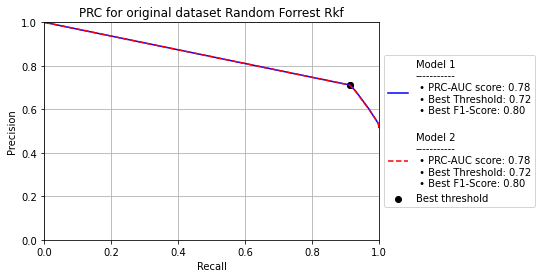

Best Threshold=0.724962, F1-Score=0.800 for model 1
Best Threshold=0.724972, F1-Score=0.800 for model 2


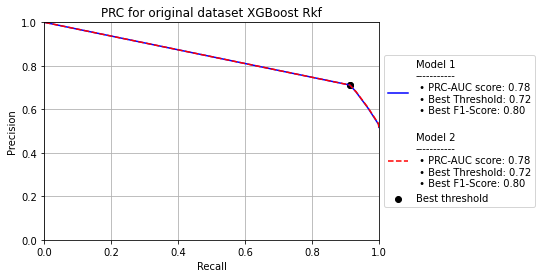

Best Threshold=0.123767, F1-Score=0.522 for model 1
Best Threshold=0.191439, F1-Score=0.522 for model 2


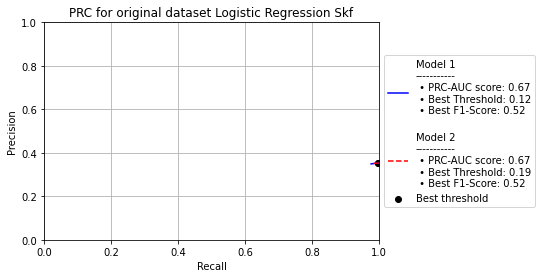

Best Threshold=0.000000, F1-Score=0.521 for model 1
Best Threshold=0.149318, F1-Score=0.522 for model 2


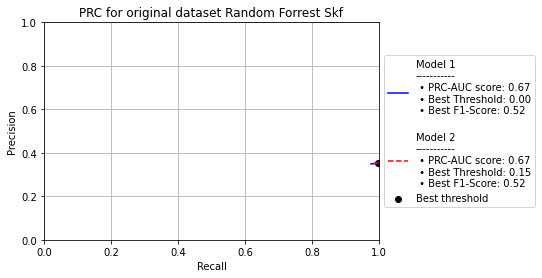

Best Threshold=0.000121, F1-Score=0.521 for model 1
Best Threshold=0.001060, F1-Score=0.522 for model 2


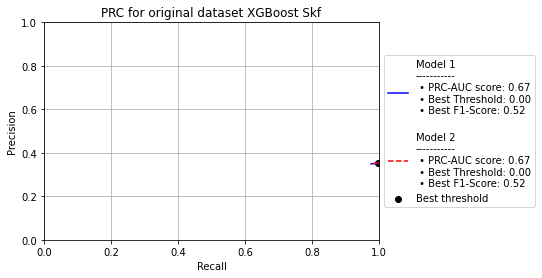

Best Threshold=0.117864, F1-Score=1.000 for model 1
Best Threshold=0.142959, F1-Score=1.000 for model 2


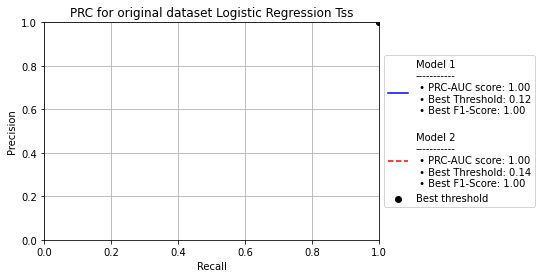

Best Threshold=0.000000, F1-Score=0.998 for model 1
Best Threshold=0.081424, F1-Score=1.000 for model 2


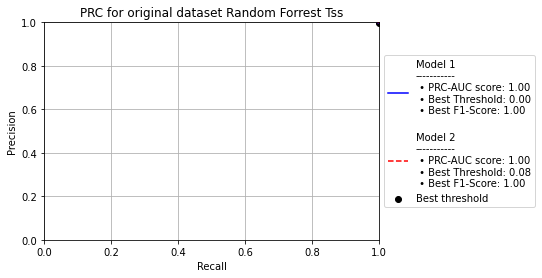

Best Threshold=0.000121, F1-Score=0.998 for model 1
Best Threshold=0.001013, F1-Score=1.000 for model 2


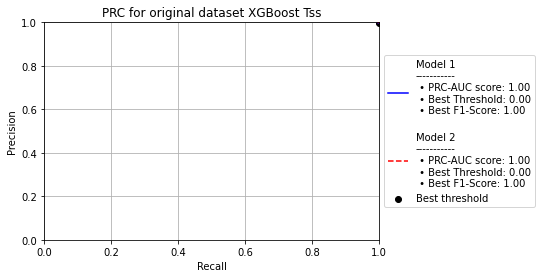

0    15835
1     8622
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8631472609563026
Average Precision-Recall Score: 0.7110522602150702
PRC-AUC for model 1: 0.8354179690941542
Accuracy: 0.641
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      3921
           1       0.00      0.00      0.00      2194

    accuracy                           0.64      6115
   macro avg       0.32      0.50      0.39      6115
weighted avg       0.41      0.64      0.50      6115


Scores for model 2
------------------
Roc_Auc Score: 0.8757734513710504
Average Precision-Recall Score: 0.7178576056870449
PRC-AUC for model 2: 0.8434250437421046
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              p

TRAIN: [    0     1     2 ... 17241 17242 17243] | TEST: [   10    17    26 ... 17216 17219 17239]

Model Score: 0.48781902552204176

Average Precision-Recall Score: 0.5065481578793511
PRC-AUC Score: 0.5158737067938496
Precision:  0.37037037037037035
Recall:  0.01141552511415525
F1:  0.0221483942414175
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.98      0.65       848
           1       0.37      0.01      0.02       876

    accuracy                           0.49      1724
   macro avg       0.43      0.50      0.34      1724
weighted avg       0.43      0.49      0.33      1724

Accuracy: 0.488
MCC:  -0.034755275162530935
TRAIN: [    0     1     2 ... 17241 17242 17243] | TEST: [   10    17    26 ... 17216 17219 17239]

Model Score: 0.48781902552204176

Average Precision-Recall Score: 0.5065481578793511
PRC-AUC Score: 0.7540603248259861
Precision:  0.37037037037037035
Recall:  0.01141552511415525
F1:  0.02214839424141

TRAIN: [    0     1     2 ... 17241 17242 17243] | TEST: [   10    17    26 ... 17216 17219 17239]

Model Score: 0.48897911832946633

Average Precision-Recall Score: 0.506959295599921
PRC-AUC Score: 0.7540603248259861
Precision:  0.38095238095238093
Recall:  0.0091324200913242
F1:  0.017837235228539576
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.98      0.65       848
           1       0.38      0.01      0.02       876

    accuracy                           0.49      1724
   macro avg       0.44      0.50      0.34      1724
weighted avg       0.43      0.49      0.33      1724

Accuracy: 0.489
MCC:  -0.02824674207792162
TRAIN: [    0     1     2 ... 17241 17242 17243] | TEST: [   10    17    26 ... 17216 17219 17239]

Model Score: 0.5232018561484919

Average Precision-Recall Score: 0.5220420199541609
PRC-AUC Score: 0.5319112352456086
Precision:  0.5467128027681661
Recall:  0.3607305936073059
F1:  0.4346629986244842
C

Precision score for model 1:  0.8326892475562628
Recall score for model 1:  0.9252336448598131
F1 score for model 1:  0.8765254845656856
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      3959
           1       0.83      0.93      0.88      3959

    accuracy                           0.87      7918
   macro avg       0.87      0.87      0.87      7918
weighted avg       0.87      0.87      0.87      7918


Scores for model 2
------------------
Roc_Auc Score: 0.8921592828130164
Average Precision-Recall Score: 0.8263919571582611
PRC-AUC for model 2: 0.8635467912816884
Precision score for model 2:  0.8326892475562628
Recall score for model 2:  0.9252336448598131
F1 score for model 2:  0.8765254845656856
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      3959
           1       0.83      0.93      0.88      3959

    accuracy           

TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14906 14907 14908 ... 31667 31668 31669]

Model Score: 0.46447742342911275

Average Precision-Recall Score: 0.48298962105421783
PRC-AUC Score: 0.7199938758716754
Precision:  0.4815059445178336
Recall:  0.9204545454545454
F1:  0.632263660017346
Classification Report:

              precision    recall  f1-score   support

           0       0.09      0.01      0.02      1583
           1       0.48      0.92      0.63      1584

    accuracy                           0.46      3167
   macro avg       0.29      0.46      0.32      3167
weighted avg       0.29      0.46      0.32      3167

Accuracy: 0.464
MCC:  -0.17411027975311272
TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14906 14907 14908 ... 31667 31668 31669]

Model Score: 0.46447742342911275

Average Precision-Recall Score: 0.48298962105421783
PRC-AUC Score: 0.7500036052145823
Precision:  0.4815059445178336
Recall:  0.9204545454545454
F1:  0.632263660017346
Cl

TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14906 14907 14908 ... 31667 31668 31669]

Model Score: 0.49352699715819387

Average Precision-Recall Score: 0.49686705753665816
PRC-AUC Score: 0.7500036052145823
Precision:  0.4967948717948718
Recall:  0.9785353535353535
F1:  0.6590136054421769
Classification Report:

              precision    recall  f1-score   support

           0       0.28      0.01      0.02      1583
           1       0.50      0.98      0.66      1584

    accuracy                           0.49      3167
   macro avg       0.39      0.49      0.34      3167
weighted avg       0.39      0.49      0.34      3167

Accuracy: 0.494
MCC:  -0.05480069536119096
TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14906 14907 14908 ... 31667 31668 31669]

Model Score: 0.45974107988632773

Average Precision-Recall Score: 0.48080621394201006
PRC-AUC Score: 0.3217158000415548
Precision:  0.47910496873971703
Recall:  0.9191919191919192
F1:  0.6298940082197708


Scores for model 1
------------------
Roc_Auc Score: 0.8885851376626177
Average Precision-Recall Score: 0.8213393189709991
PRC-AUC for model 1: 0.8381087466950563
Accuracy: 0.863
MCC for model 1: 0.7311789992163212
Precision score for model 1:  0.8281535648994516
Recall score for model 1:  0.916772071844169
F1 score for model 1:  0.8702125105054628
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      3965
           1       0.83      0.92      0.87      3953

    accuracy                           0.86      7918
   macro avg       0.87      0.86      0.86      7918
weighted avg       0.87      0.86      0.86      7918


Scores for model 2
------------------
Roc_Auc Score: 0.8885239521502497
Average Precision-Recall Score: 0.8213057269873766
PRC-AUC for model 2: 0.8381087466950563
Precision score for model 2:  0.8281535648994516
Recall score for model 2:  0.916772071844169
F1 score for model 2:  0.87021251050546


Accuracy: 0.000
MCC:  0.0

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    5278.0

    accuracy                           0.00    5278.0
   macro avg       0.00      0.00      0.00    5278.0
weighted avg       0.00      0.00      0.00    5278.0

Accuracy: 0.000
MCC:  0.0
TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14252 14253 14254 ... 31667 31668 31669]

Model Score: 0.46447742342911275

Average Precision-Recall Score: 0.4829827590025811
PRC-AUC Score: 0.3467637099501046
Precision:  0.4816633922724296
Recall:  0.9286616161616161
F1:  0.6343251401466149
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1583
           1       0.48      0.93      0.63      

TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14252 14253 14254 ... 31667 31668 31669]

Model Score: 0.46447742342911275

Average Precision-Recall Score: 0.4829827590025811
PRC-AUC Score: 0.3467637099501046
Precision:  0.4816633922724296
Recall:  0.9286616161616161
F1:  0.6343251401466149
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1583
           1       0.48      0.93      0.63      1584

    accuracy                           0.46      3167
   macro avg       0.24      0.46      0.32      3167
weighted avg       0.24      0.46      0.32      3167

Accuracy: 0.464
MCC:  -0.1922948150095452
Row 71 model 2

Model Score: 0.9262978400909435

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.9262978400909435
F1:  0.961738959378381
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
 

Performing analysis for: JCR
                   Name                                               File  \
13063  Marcel Reutegger  src/java/org/apache/jackrabbit/core/config/Wor...   
13064  Marcel Reutegger  src/java/org/apache/jackrabbit/core/search/luc...   
13065  Marcel Reutegger  src/java/org/apache/jackrabbit/core/Repository...   
13066  Marcel Reutegger                   applications/test/repository.xml   
13067  Marcel Reutegger  src/java/org/apache/jackrabbit/core/search/luc...   
...                 ...                                                ...   
62577    Timothy Reilly                               xdocs/navigation.xml   
62578    Timothy Reilly                                     checkstyle.xml   
62579    Timothy Reilly                                    xdocs/tasks.xml   
62580    Timothy Reilly                                 project.properties   
62581    Timothy Reilly                                   xdocs/layout.xml   

                      Bug  PageRan

Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.9025254289411747
Average Precision-Recall Score: 0.150077564656785
PRC-AUC for model 1: 0.2280149860890051
Accuracy: 0.972
MCC for model 1: 0.032114360717262216
Precision score for model 1:  0.5
Recall score for model 1:  0.0022522522522522522
F1 score for model 1:  0.004484304932735426
Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     15204
           1       0.50      0.00      0.00       444

    accuracy                           0.97     15648
   macro avg       0.74      0.50      0.50     15648
weighted avg       0.96      0.97      0.96     15648


Scores for model 2
------------------
Roc_Auc Score: 0.9031450057002544
Average Precision-Recall Score: 0.1501073855470756
PRC-AUC for model 2: 0.22804555680451502
Precision score for model 2:  0.5
Recall score for model 2:  0.0022522522522522522
F1 score for model 2:  0.00448430493

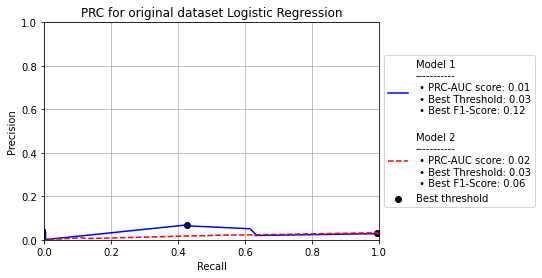

Best Threshold=0.195608, F1-Score=0.256 for model 1
Best Threshold=0.195168, F1-Score=0.256 for model 2


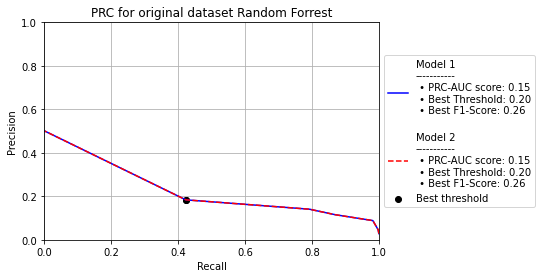

Best Threshold=0.195368, F1-Score=0.256 for model 1
Best Threshold=0.195377, F1-Score=0.256 for model 2


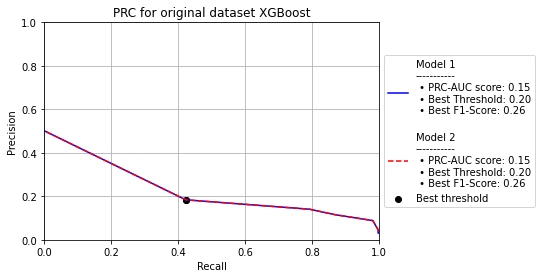

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5308588481931024
Average Precision-Recall Score: 0.05004171456416192
PRC-AUC for model 1: 0.014716097936512644
Accuracy: 0.819
MCC for model 1: 0.11119550671158315
Precision score for model 1:  0.06815723043635052
Recall score for model 1:  0.42567567567567566
F1 score for model 1:  0.11750077712154182
Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     15204
           1       0.07      0.43      0.12       444

    accuracy                           0.82     15648
   macro avg       0.52      0.63      0.51     15648
weighted avg       0.95      0.82      0.88     15648


Scores for model 2
------------------
Roc_Auc Score: 0.30397035749245693
Average Precision-Recall Score: 0.02430514240917581
PRC-AUC for model 2: 0.01842303622116827
Precision score for model 2:  0.03252391464311994
Recall score for mod

TRAIN: [    0     1     2 ... 62329 62330 62331] | TEST: [55873 55874 55875 ... 62588 62589 62590]

Model Score: 0.15593545294775524

Average Precision-Recall Score: 0.030917555839611324
PRC-AUC Score: 0.48866503698792435
Precision:  0.03105475927967659
Recall:  0.9441340782122905
F1:  0.060131649172745064
Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.13      0.23      6080
           1       0.03      0.94      0.06       179

    accuracy                           0.16      6259
   macro avg       0.51      0.54      0.15      6259
weighted avg       0.96      0.16      0.23      6259

Accuracy: 0.156
MCC:  0.03802882599511872
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 62329 62330 62331] | TEST: [55873 55874 55875 ... 62588 62589 62590]

Model Score: 0.1660009586195878

Average Precision-Recall Score: 0.031260956278573435
PRC-AUC Score: 0.4886825412528546
Precision:  0.03141847927124001
Recall:  0.

TRAIN: [    0     1     2 ... 62329 62330 62331] | TEST: [55873 55874 55875 ... 62588 62589 62590]

Model Score: 0.15593545294775524

Average Precision-Recall Score: 0.030917555839611324
PRC-AUC Score: 0.48865800371426876
Precision:  0.03105475927967659
Recall:  0.9441340782122905
F1:  0.060131649172745064
Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.13      0.23      6080
           1       0.03      0.94      0.06       179

    accuracy                           0.16      6259
   macro avg       0.51      0.54      0.15      6259
weighted avg       0.96      0.16      0.23      6259

Accuracy: 0.156
MCC:  0.03802882599511872
Row 14 model 2

Model Score: 0.938836161441856

Average Precision-Recall Score: 0.061163838558143994
PRC-AUC Score: 0.03288500784389233
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97   

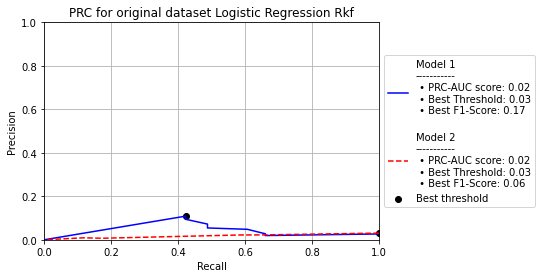

Best Threshold=0.192283, F1-Score=0.263 for model 1
Best Threshold=0.192802, F1-Score=0.263 for model 2


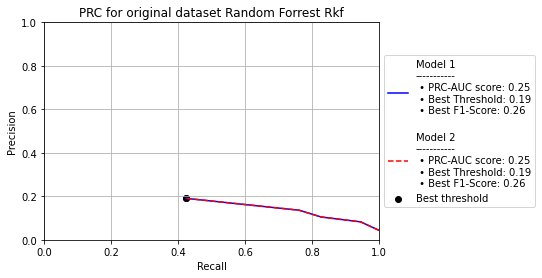

Best Threshold=0.192367, F1-Score=0.263 for model 1
Best Threshold=0.192379, F1-Score=0.263 for model 2


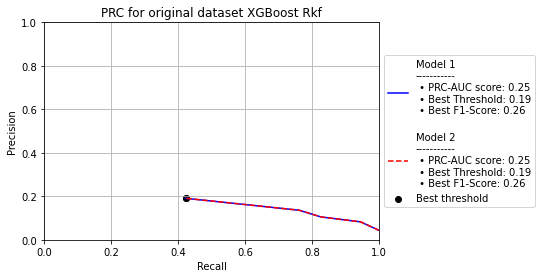

Best Threshold=0.028628, F1-Score=0.061 for model 1
Best Threshold=0.028750, F1-Score=0.061 for model 2


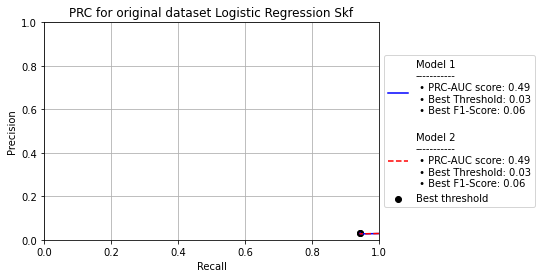

Best Threshold=0.083333, F1-Score=0.063 for model 1
Best Threshold=0.123722, F1-Score=0.063 for model 2


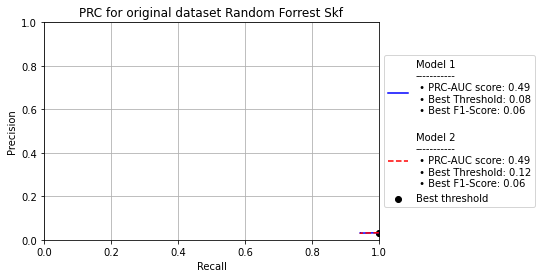

Best Threshold=0.002445, F1-Score=0.064 for model 1
Best Threshold=0.000265, F1-Score=0.063 for model 2


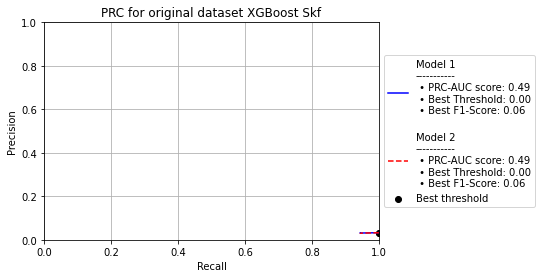

Best Threshold=0.020574, F1-Score=0.115 for model 1
Best Threshold=0.022186, F1-Score=0.118 for model 2


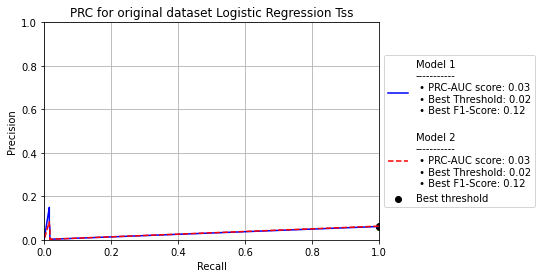

Best Threshold=0.052143, F1-Score=0.194 for model 1
Best Threshold=0.047467, F1-Score=0.194 for model 2


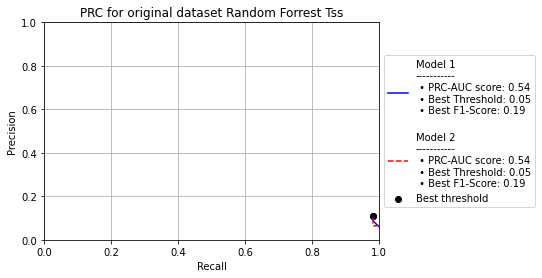

Best Threshold=0.000051, F1-Score=0.192 for model 1
Best Threshold=0.000517, F1-Score=0.141 for model 2


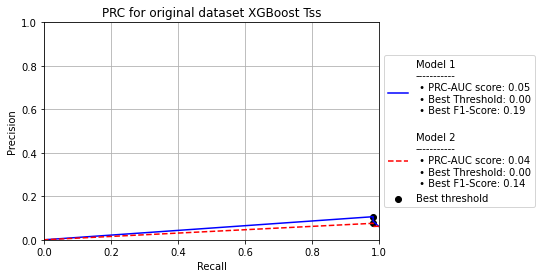

0    60800
1     1791
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5672867983635246
Average Precision-Recall Score: 0.05341502242218238
PRC-AUC for model 1: 0.0378228701783544
Accuracy: 0.971
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     15201
           1       0.00      0.00      0.00       447

    accuracy                           0.97     15648
   macro avg       0.49      0.50      0.49     15648
weighted avg       0.94      0.97      0.96     15648


Scores for model 2
------------------
Roc_Auc Score: 0.31476396745945867
Average Precision-Recall Score: 0.02476364492101741
PRC-AUC for model 2: 0.018976397682624345
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

          

TRAIN: [   0    1    2 ... 3579 3580 3581] | TEST: [  13   18   24   41   44   48   54   61   67   68   70   79   84   91
   98  100  104  126  155  164  181  188  196  203  206  208  214  218
  220  225  230  236  246  250  254  255  257  261  276  282  283  306
  314  332  343  356  364  372  402  413  418  421  422  428  432  433
  445  452  471  477  503  528  544  545  551  560  569  572  573  574
  579  587  615  638  640  654  657  662  688  693  702  706  722  744
  753  757  767  771  777  779  797  803  835  847  848  855  865  867
  873  877  880  896  897  915  918  919  926  959  968  982  989  990
  997 1007 1008 1013 1015 1040 1042 1053 1065 1070 1074 1080 1094 1099
 1104 1119 1137 1140 1151 1168 1173 1176 1191 1193 1204 1207 1216 1221
 1223 1230 1233 1260 1302 1311 1320 1332 1334 1345 1381 1388 1391 1394
 1396 1401 1407 1410 1419 1443 1459 1467 1469 1484 1489 1491 1492 1510
 1520 1533 1545 1552 1553 1556 1574 1598 1625 1628 1656 1659 1687 1701
 1706 1723 1729 1733 1749 

Precision:  0.3218390804597701
Recall:  0.1564245810055866
F1:  0.21052631578947367
Classification Report:

              precision    recall  f1-score   support

           0       0.44      0.67      0.53       179
           1       0.32      0.16      0.21       179

    accuracy                           0.41       358
   macro avg       0.38      0.41      0.37       358
weighted avg       0.38      0.41      0.37       358

Accuracy: 0.413
MCC:  -0.20189121519531633
TRAIN: [   0    1    2 ... 3400 3401 3402] | TEST: [1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625
 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639
 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653
 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667
 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681
 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695
 1696 1697 1698 1699 1700 1701 1702 1703 1704


Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     597.0

    accuracy                           0.00     597.0
   macro avg       0.00      0.00      0.00     597.0
weighted avg       0.00      0.00      0.00     597.0

Accuracy: 0.000
MCC:  0.0
Row 35 model 1

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     597.0

    accuracy                           0.00     597.0
   macro avg       0.00      0.00      0.00     597.0
weighted avg       0.00      0.00      0.00     597.0

Accuracy: 0.000
MCC:  0.0
TRAIN: 

TRAIN: [   0    1    2 ... 3579 3580 3581] | TEST: [  13   18   24   41   44   48   54   61   67   68   70   79   84   91
   98  100  104  126  155  164  181  188  196  203  206  208  214  218
  220  225  230  236  246  250  254  255  257  261  276  282  283  306
  314  332  343  356  364  372  402  413  418  421  422  428  432  433
  445  452  471  477  503  528  544  545  551  560  569  572  573  574
  579  587  615  638  640  654  657  662  688  693  702  706  722  744
  753  757  767  771  777  779  797  803  835  847  848  855  865  867
  873  877  880  896  897  915  918  919  926  959  968  982  989  990
  997 1007 1008 1013 1015 1040 1042 1053 1065 1070 1074 1080 1094 1099
 1104 1119 1137 1140 1151 1168 1173 1176 1191 1193 1204 1207 1216 1221
 1223 1230 1233 1260 1302 1311 1320 1332 1334 1345 1381 1388 1391 1394
 1396 1401 1407 1410 1419 1443 1459 1467 1469 1484 1489 1491 1492 1510
 1520 1533 1545 1552 1553 1556 1574 1598 1625 1628 1656 1659 1687 1701
 1706 1723 1729 1733 1749 

TRAIN: [   0    1    2 ... 3400 3401 3402] | TEST: [1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625
 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639
 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653
 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667
 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681
 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695
 1696 1697 1698 1699 1700 1701 1702 1703 1704 1705 1706 1707 1708 1709
 1710 1711 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722 1723
 1724 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736 1737
 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751
 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765
 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779
 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 3403 3404 3405
 3406 3407 3408 3409 3410 

Accuracy: 0.841
MCC for model 2: 0.7073921101691906

Scores for model 1
------------------
Roc_Auc Score: 0.6100538775710047
Average Precision-Recall Score: 0.7053085616335908
PRC-AUC for model 1: 0.7184643852216902
Accuracy: 0.498
MCC for model 1: 0.0
Precision score for model 1:  0.4984868421052632
Recall score for model 1:  1.0
F1 score for model 1:  0.6653202792290469
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15246
           1       0.50      1.00      0.67     15154

    accuracy                           0.50     30400
   macro avg       0.25      0.50      0.33     30400
weighted avg       0.25      0.50      0.33     30400


Scores for model 2
------------------
Roc_Auc Score: 0.31074460931264414
Average Precision-Recall Score: 0.4466620223271364
PRC-AUC for model 2: 0.35770008569860806
Precision score for model 2:  0.4984868421052632
Recall score for model 2:  1.0
F1 score for model 2:  0.665

TRAIN: [     0      1      2 ... 115517 115518 115519] | TEST: [ 55873  55874  55875 ... 121597 121598 121599]

Model Score: 0.4954769736842105

Average Precision-Recall Score: 0.4977502133645606
PRC-AUC Score: 0.5022789661844411
Precision:  0.49740737248986516
Recall:  0.8677631578947368
F1:  0.632348534787559
Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.12      0.20      6080
           1       0.50      0.87      0.63      6080

    accuracy                           0.50     12160
   macro avg       0.49      0.50      0.41     12160
weighted avg       0.49      0.50      0.41     12160

Accuracy: 0.495
MCC:  -0.013551291180877124
Row 49 model 1
TRAIN: [     0      1      2 ... 115517 115518 115519] | TEST: [ 55873  55874  55875 ... 121597 121598 121599]

Model Score: 0.4954769736842105

Average Precision-Recall Score: 0.4977502133645606
PRC-AUC Score: 0.5006374195098191
Precision:  0.49740737248986516
Recall:  0.8677

TRAIN: [     0      1      2 ... 115517 115518 115519] | TEST: [ 55873  55874  55875 ... 121597 121598 121599]

Model Score: 0.4954769736842105

Average Precision-Recall Score: 0.4977502133645606
PRC-AUC Score: 0.5006374195098191
Precision:  0.49740737248986516
Recall:  0.8677631578947368
F1:  0.632348534787559
Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.12      0.20      6080
           1       0.50      0.87      0.63      6080

    accuracy                           0.50     12160
   macro avg       0.49      0.50      0.41     12160
weighted avg       0.49      0.50      0.41     12160

Accuracy: 0.495
MCC:  -0.013551291180877124

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   2

Accuracy: 0.498
MCC for model 2: 0.0

Scores for model 1
------------------
Roc_Auc Score: 0.9037565905076692
Average Precision-Recall Score: 0.8505870069389462
PRC-AUC for model 1: 0.8645082200213301
Accuracy: 0.841
MCC for model 1: 0.7080961801531073
Precision score for model 1:  0.7688060012502604
Recall score for model 1:  0.9741897154927718
F1 score for model 1:  0.8593972921822682
Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     15251
           1       0.77      0.97      0.86     15149

    accuracy                           0.84     30400
   macro avg       0.87      0.84      0.84     30400
weighted avg       0.87      0.84      0.84     30400


Scores for model 2
------------------
Roc_Auc Score: 0.9037515112434242
Average Precision-Recall Score: 0.8505850877889435
PRC-AUC for model 2: 0.8645082192051184
Precision score for model 2:  0.76868586905568
Recall score for model 2:  0.9741897154927718
F1


Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   20266.0

    accuracy                           0.00   20266.0
   macro avg       0.00      0.00      0.00   20266.0
weighted avg       0.00      0.00      0.00   20266.0

Accuracy: 0.000
MCC:  0.0

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   20266.0

    accuracy                           0.00   20266.0
   macro avg       0.00      0.00      0.00   20266.0
weighted avg       0.00      0.00      0.00   20266.0

Accuracy: 0.000
MCC:  0.0
TRAIN: [     0      1 


Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   20266.0

    accuracy                           0.00   20266.0
   macro avg       0.00      0.00      0.00   20266.0
weighted avg       0.00      0.00      0.00   20266.0

Accuracy: 0.000
MCC:  0.0
TRAIN: [     0      1      2 ... 115517 115518 115519] | TEST: [ 54720  54721  54722 ... 121597 121598 121599]

Model Score: 0.496875

Average Precision-Recall Score: 0.4984431461582351
PRC-AUC Score: 0.5039576381088716
Precision:  0.4981932293647775
Recall:  0.8616776315789474
F1:  0.631356953482767
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.13      0.21      6080
           1       0.50      0.86      0.63      6080

    accuracy         

Performing analysis for: JMeter
                    Name                                               File  \
11037   Philippe Mouawad                                  xdocs/changes.xml   
11038   Philippe Mouawad  src/core/org/apache/jmeter/report/config/Repor...   
11039   Philippe Mouawad          xdocs/usermanual/generating-dashboard.xml   
11040   Philippe Mouawad       bin/report-template/content/js/graph.js.fmkr   
11041   Philippe Mouawad                       xdocs/devguide-dashboard.xml   
...                  ...                                                ...   
52223   Felix Schumacher  src/components/org/apache/jmeter/extractor/XPa...   
52224   Felix Schumacher  src/components/org/apache/jmeter/visualizers/b...   
52225   Felix Schumacher  src/protocol/http/org/apache/jmeter/protocol/h...   
52226   Felix Schumacher  src/components/org/apache/jmeter/assertions/XP...   
59418  Vladimir Sitnikov                                        .travis.yml   

                   

Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7923651791039104
Average Precision-Recall Score: 0.4440267974002665
PRC-AUC for model 1: 0.565939770499774
Accuracy: 0.852
MCC for model 1: 0.3961824563048004
Precision score for model 1:  0.7215302491103203
Recall score for model 1:  0.29405366207396666
F1 score for model 1:  0.4178258629572385
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.97      0.92     12478
           1       0.72      0.29      0.42      2758

    accuracy                           0.85     15236
   macro avg       0.79      0.63      0.67     15236
weighted avg       0.84      0.85      0.83     15236


Scores for model 2
------------------
Roc_Auc Score: 0.7923651791039104
Average Precision-Recall Score: 0.4440267974002665
PRC-AUC for model 2: 0.565939770499774
Precision score for model 2:  0.7215302491103203
Recall score for model 2:  0.29405366207396666
F1 score for mod

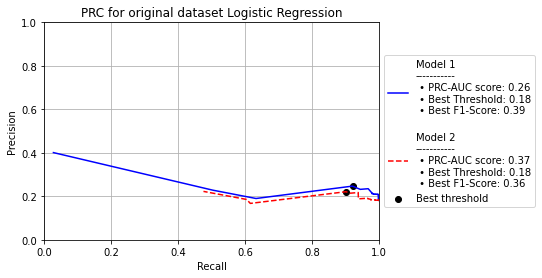

Best Threshold=0.251128, F1-Score=0.459 for model 1
Best Threshold=0.250779, F1-Score=0.459 for model 2


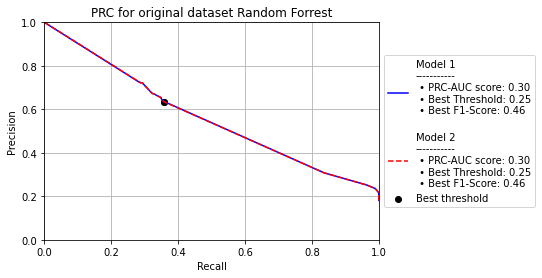

Best Threshold=0.251081, F1-Score=0.459 for model 1
Best Threshold=0.247347, F1-Score=0.459 for model 2


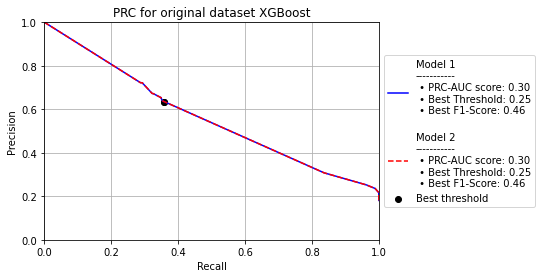

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.6125007714810844
Average Precision-Recall Score: 0.23312819028878629
PRC-AUC for model 1: 0.25940387314961033
Accuracy: 0.475
MCC for model 1: 0.24582727227250678
Precision score for model 1:  0.24636557472378368
Recall score for model 1:  0.9216823785351704
F1 score for model 1:  0.38880391557051086
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.38      0.54     12478
           1       0.25      0.92      0.39      2758

    accuracy                           0.48     15236
   macro avg       0.60      0.65      0.46     15236
weighted avg       0.83      0.48      0.51     15236


Scores for model 2
------------------
Roc_Auc Score: 0.5625384941456354
Average Precision-Recall Score: 0.21438680936165844
PRC-AUC for model 2: 0.37471309521514895
Precision score for model 2:  0.22115470153900899
Recall score for model 

TRAIN: [    0     1     2 ... 55946 55947 55948] | TEST: [45466 45467 45468 ... 60940 60941 60942]

Model Score: 0.8610108303249098

Average Precision-Recall Score: 0.36968853388944084
PRC-AUC Score: 0.23069936421435058
Precision:  1.0
Recall:  0.23069936421435058
F1:  0.37490774907749075
Classification Report:

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      4993
           1       1.00      0.23      0.37      1101

    accuracy                           0.86      6094
   macro avg       0.93      0.62      0.65      6094
weighted avg       0.88      0.86      0.82      6094

Accuracy: 0.861
MCC:  0.44411716442861304
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 55946 55947 55948] | TEST: [45466 45467 45468 ... 60940 60941 60942]

Model Score: 0.8610108303249098

Average Precision-Recall Score: 0.36968853388944084
PRC-AUC Score: 0.5023906841413353
Precision:  1.0
Recall:  0.23069936421435058
F1:  0.3749077490

TRAIN: [    0     1     2 ... 55946 55947 55948] | TEST: [45466 45467 45468 ... 60940 60941 60942]

Model Score: 0.8610108303249098

Average Precision-Recall Score: 0.36968853388944084
PRC-AUC Score: 0.469839377301031
Precision:  1.0
Recall:  0.23069936421435058
F1:  0.37490774907749075
Classification Report:

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      4993
           1       1.00      0.23      0.37      1101

    accuracy                           0.86      6094
   macro avg       0.93      0.62      0.65      6094
weighted avg       0.88      0.86      0.82      6094

Accuracy: 0.861
MCC:  0.44411716442861304
Row 14 model 2

Model Score: 0.9875947622329428

Average Precision-Recall Score: 0.012405237767057202
PRC-AUC Score: 0.0062107575136443206
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10031
         

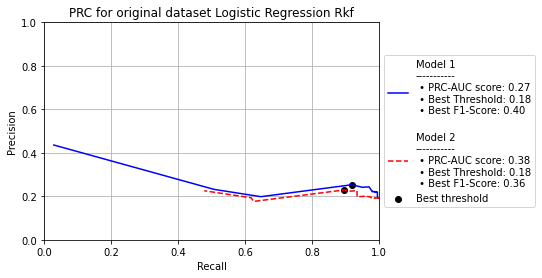

Best Threshold=0.117268, F1-Score=0.448 for model 1
Best Threshold=0.118371, F1-Score=0.447 for model 2


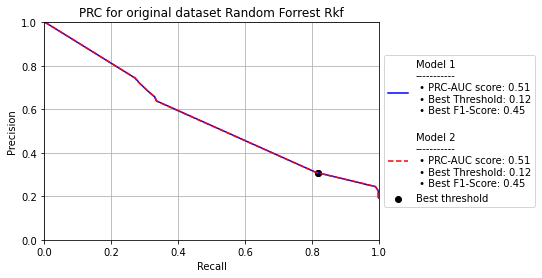

Best Threshold=0.118045, F1-Score=0.448 for model 1
Best Threshold=0.117391, F1-Score=0.448 for model 2


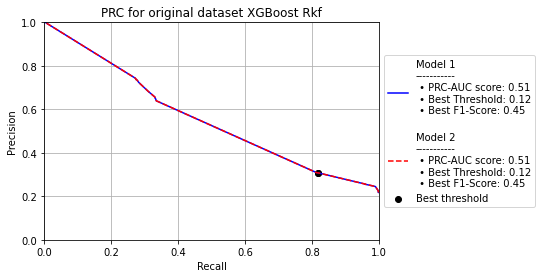

Best Threshold=0.132024, F1-Score=0.970 for model 1
Best Threshold=0.178458, F1-Score=0.711 for model 2


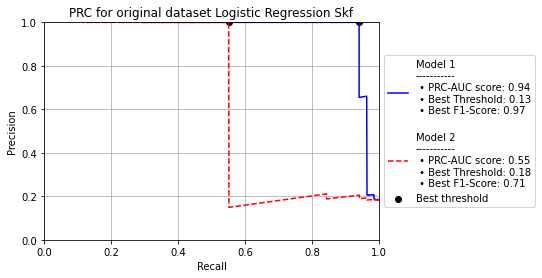

Best Threshold=0.681239, F1-Score=0.375 for model 1
Best Threshold=0.681593, F1-Score=0.375 for model 2


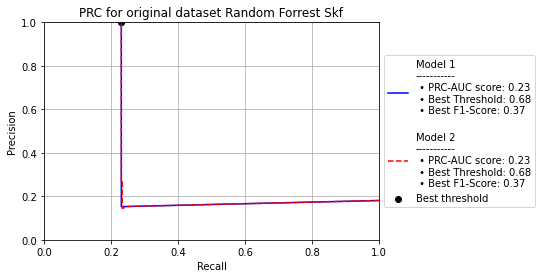

Best Threshold=0.000064, F1-Score=0.591 for model 1
Best Threshold=0.000030, F1-Score=0.591 for model 2


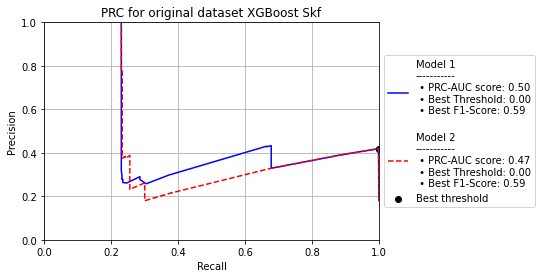

Best Threshold=0.205464, F1-Score=0.145 for model 1
Best Threshold=0.213919, F1-Score=0.025 for model 2


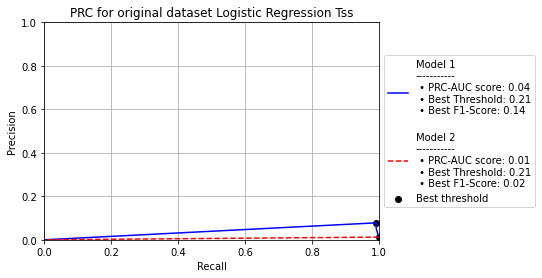

Best Threshold=0.000000, F1-Score=0.025 for model 1
Best Threshold=0.000000, F1-Score=0.025 for model 2


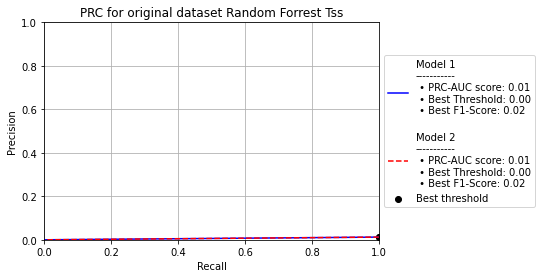

Best Threshold=0.000125, F1-Score=0.025 for model 1
Best Threshold=0.000067, F1-Score=0.025 for model 2


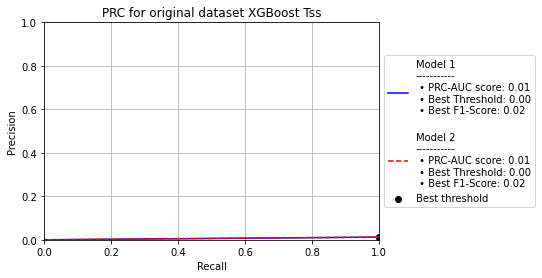

0    49939
1    11004
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.6165880336557725
Average Precision-Recall Score: 0.23435028746572223
PRC-AUC for model 1: 0.2898165288039611
Accuracy: 0.820
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     12499
           1       0.00      0.00      0.00      2737

    accuracy                           0.82     15236
   macro avg       0.41      0.50      0.45     15236
weighted avg       0.67      0.82      0.74     15236


Scores for model 2
------------------
Roc_Auc Score: 0.5635476778953423
Average Precision-Recall Score: 0.21297408118323408
PRC-AUC for model 2: 0.3949692518144547
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

             

TRAIN: [    1     2     3 ... 22005 22006 22007] | TEST: [    0    23    31 ... 21991 21995 22002]

Model Score: 0.48772727272727273

Average Precision-Recall Score: 0.4876045766484638
PRC-AUC Score: 0.49965408017054025
Precision:  0.48760330578512395
Recall:  0.9897483690587139
F1:  0.6533374346354968
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.01      0.02      1127
           1       0.49      0.99      0.65      1073

    accuracy                           0.49      2200
   macro avg       0.49      0.50      0.34      2200
weighted avg       0.49      0.49      0.33      2200

Accuracy: 0.488
MCC:  -0.002467654468504943
TRAIN: [    1     2     3 ... 22005 22006 22007] | TEST: [    0    23    31 ... 21991 21995 22002]

Model Score: 0.48772727272727273

Average Precision-Recall Score: 0.4876045766484638
PRC-AUC Score: 0.7438636363636364
Precision:  0.48760330578512395
Recall:  0.9897483690587139
F1:  0.653337434635496

TRAIN: [    1     2     3 ... 22005 22006 22007] | TEST: [    0    23    31 ... 21991 21995 22002]

Model Score: 0.4859090909090909

Average Precision-Recall Score: 0.48674209357507464
PRC-AUC Score: 0.7438636363636364
Precision:  0.4867337602927722
Recall:  0.9916123019571296
F1:  0.6529610309911016
Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.00      0.01      1127
           1       0.49      0.99      0.65      1073

    accuracy                           0.49      2200
   macro avg       0.42      0.50      0.33      2200
weighted avg       0.42      0.49      0.32      2200

Accuracy: 0.486
MCC:  -0.02483677653089273
TRAIN: [    1     2     3 ... 22005 22006 22007] | TEST: [    0    23    31 ... 21991 21995 22002]

Model Score: 0.515

Average Precision-Recall Score: 0.49592635400704715
PRC-AUC Score: 0.49857499798654553
Precision:  0.5025380710659898
Recall:  0.5535880708294502
F1:  0.526829268292683
Classification 

Roc_Auc Score: 0.7854021400959039
Average Precision-Recall Score: 0.7376730893575546
PRC-AUC for model 1: 0.8064040434906338
Accuracy: 0.706
MCC for model 1: 0.42494738819695765
Precision score for model 1:  0.66379753340185
Recall score for model 1:  0.8299068422743334
F1 score for model 1:  0.7376159885795861
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.58      0.66     12518
           1       0.66      0.83      0.74     12452

    accuracy                           0.71     24970
   macro avg       0.72      0.71      0.70     24970
weighted avg       0.72      0.71      0.70     24970


Scores for model 2
------------------
Roc_Auc Score: 0.7855676710855994
Average Precision-Recall Score: 0.7378259921381313
PRC-AUC for model 2: 0.8065524982892975
Precision score for model 2:  0.6638623081369212
Recall score for model 2:  0.8301477674269194
F1 score for model 2:  0.7377511329978946
Classification Report:

           

TRAIN: [    0     1     2 ... 94881 94882 94883] | TEST: [55949 55950 55951 ... 99875 99876 99877]

Model Score: 0.9627515770501652

Average Precision-Recall Score: 0.9627590356851171
PRC-AUC Score: 0.9895875050060072
Precision:  1.0
Recall:  0.9255106127352823
F1:  0.9613144758735441
Classification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4993
           1       1.00      0.93      0.96      4994

    accuracy                           0.96      9987
   macro avg       0.97      0.96      0.96      9987
weighted avg       0.97      0.96      0.96      9987

Accuracy: 0.963
MCC:  0.9280825807436673
TRAIN: [    0     1     2 ... 94881 94882 94883] | TEST: [55949 55950 55951 ... 99875 99876 99877]

Model Score: 0.9627515770501652

Average Precision-Recall Score: 0.9627590356851171
PRC-AUC Score: 0.9264528715102731
Precision:  1.0
Recall:  0.9255106127352823
F1:  0.9613144758735441
Classification Report:

            

TRAIN: [    0     1     2 ... 94881 94882 94883] | TEST: [55949 55950 55951 ... 99875 99876 99877]

Model Score: 0.38680284369680584

Average Precision-Recall Score: 0.4768055048987353
PRC-AUC Score: 0.750025032542305
Precision:  0.205422314911366
Recall:  0.07889467360833
F1:  0.11400462962962962
Classification Report:

              precision    recall  f1-score   support

           0       0.43      0.69      0.53      4993
           1       0.21      0.08      0.11      4994

    accuracy                           0.39      9987
   macro avg       0.32      0.39      0.32      9987
weighted avg       0.32      0.39      0.32      9987

Accuracy: 0.387
MCC:  -0.28728840023377866
TRAIN: [    0     1     2 ... 94881 94882 94883] | TEST: [55949 55950 55951 ... 99875 99876 99877]

Model Score: 0.8320817062180835

Average Precision-Recall Score: 0.777350150217898
PRC-AUC Score: 0.8628842832278247
Precision:  0.8351182056981208
Recall:  0.8275931117340809
F1:  0.831338630192095
Classifi

Roc_Auc Score: 0.5614368138277894
Average Precision-Recall Score: 0.5485323658276413
PRC-AUC for model 2: 0.6275573687974108
Precision score for model 2:  0.5000401541920977
Recall score for model 2:  0.9989571634846783
F1 score for model 2:  0.6664704308268664
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.00      0.01     12504
           1       0.50      1.00      0.67     12466

    accuracy                           0.50     24970
   macro avg       0.65      0.50      0.34     24970
weighted avg       0.65      0.50      0.34     24970

Accuracy: 0.501
MCC for model 2: 0.031121611858380492

Scores for model 1
------------------
Roc_Auc Score: 0.7872574374788227
Average Precision-Recall Score: 0.7408782742531231
PRC-AUC for model 1: 0.7870819593894842
Accuracy: 0.640
MCC for model 1: 0.38797968460655347
Precision score for model 1:  0.5821531757684839
Recall score for model 1:  0.9859618161399005
F1 score for model 1:

TRAIN: [    0     1     2 ... 94881 94882 94883] | TEST: [44946 44947 44948 ... 99875 99876 99877]

Model Score: 0.9025733453489536

Average Precision-Recall Score: 0.8905432574019855
PRC-AUC Score: 0.8001422102637307
Precision:  0.9700724807107786
Recall:  0.8307969563476172
F1:  0.8950490777693884
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      4993
           1       0.97      0.83      0.90      4994

    accuracy                           0.90      9987
   macro avg       0.91      0.90      0.90      9987
weighted avg       0.91      0.90      0.90      9987

Accuracy: 0.903
MCC:  0.8135797660322374

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   16646.0

    acc


Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   16646.0

    accuracy                           0.00   16646.0
   macro avg       0.00      0.00      0.00   16646.0
weighted avg       0.00      0.00      0.00   16646.0

Accuracy: 0.000
MCC:  0.0
---------------------
With best threshold

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   16646.0

    accuracy                           0.00   16646.0
   macro avg       0.00      0.00      0.00   16646.0
weighted avg       0.00      0.00      0.00   16646.0

Accura

Performing analysis for: LOG4J2
               Name                                               File  \
11087   Ralph Goers  core/src/test/resources/bad/log4j-badfilename.xml   
11088   Ralph Goers     core/src/test/resources/bad/log4j-nofilter.xml   
11089   Ralph Goers       core/src/test/resources/bad/log4j-status.xml   
11090   Ralph Goers  log4j12-api/src/test/java/org/apache/log4j/Bas...   
11091   Ralph Goers  core/src/main/java/org/apache/logging/log4j/co...   
...             ...                                                ...   
56697  Ivan Habunek              src/site/xdoc/manual/eventlogging.xml   
56698  Ivan Habunek                 src/site/xdoc/manual/appenders.xml   
56699  Ivan Habunek                            src/site/xdoc/index.xml   
56700  Ivan Habunek               src/site/xdoc/manual/flowtracing.xml   
56701  Ivan Habunek                 src/site/xdoc/manual/migration.xml   

                      Bug   PageRank  Betweenness  Closeness  Harmonic  \
11087



Scores for model 2
------------------
Roc_Auc Score: 0.7561985729276722
Average Precision-Recall Score: 0.22902635869025473
PRC-AUC for model 2: 0.25811078735710113
Precision score for model 2:  1.0
Recall score for model 2:  0.0018796992481203006
F1 score for model 2:  0.00375234521575985
Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     12589
           1       1.00      0.00      0.00      1596

    accuracy                           0.89     14185
   macro avg       0.94      0.50      0.47     14185
weighted avg       0.90      0.89      0.84     14185

Accuracy: 0.888
MCC for model 2: 0.04084802470338061
Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7562352541135188
Average Precision-Recall Score: 0.22902984637246981
PRC-AUC for model 1: 0.2581143972784368
Accuracy: 0.888
MCC for model 1: 0.04084802470338061
Precision score for model 1:  1.0
Recall score for model 1:  0.0

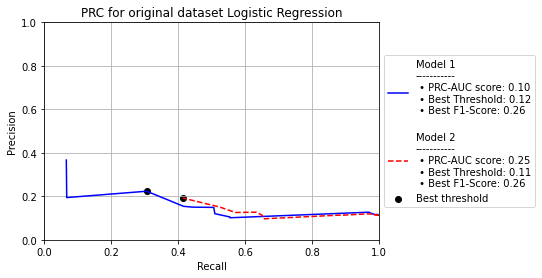

Best Threshold=0.189288, F1-Score=0.333 for model 1
Best Threshold=0.189522, F1-Score=0.333 for model 2


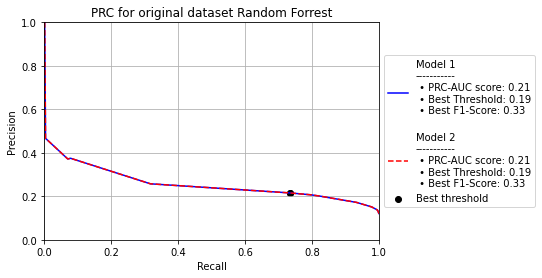

Best Threshold=0.189308, F1-Score=0.333 for model 1
Best Threshold=0.189309, F1-Score=0.333 for model 2


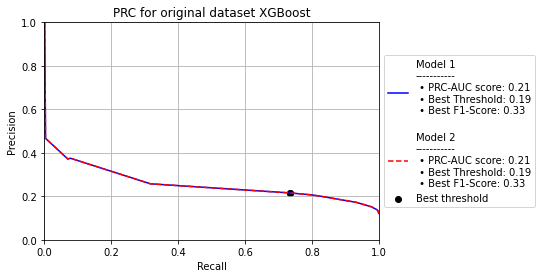

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5675490258731266
Average Precision-Recall Score: 0.1696687350568007
PRC-AUC for model 1: 0.09558884919287798
Accuracy: 0.802
MCC for model 1: 0.14988607039750734
Precision score for model 1:  0.2233896756509822
Recall score for model 1:  0.30639097744360905
F1 score for model 1:  0.25838837516512553
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.86      0.89     12589
           1       0.22      0.31      0.26      1596

    accuracy                           0.80     14185
   macro avg       0.57      0.59      0.57     14185
weighted avg       0.83      0.80      0.82     14185


Scores for model 2
------------------
Roc_Auc Score: 0.5604323781094647
Average Precision-Recall Score: 0.1521795073852454
PRC-AUC for model 2: 0.2475648237815958
Precision score for model 2:  0.1918958031837916
Recall score for model 2:  

TRAIN: [    0     1     2 ... 55249 55250 55251] | TEST: [49740 49741 49742 ... 56734 56735 56736]

Model Score: 0.1808566895822316

Average Precision-Recall Score: 0.09134778587670471
PRC-AUC Score: 0.19548393385420557
Precision:  0.03878815698875373
Recall:  0.26910828025477707
F1:  0.06780341023069208
Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.17      0.27      5045
           1       0.04      0.27      0.07       628

    accuracy                           0.18      5673
   macro avg       0.35      0.22      0.17      5673
weighted avg       0.58      0.18      0.25      5673

Accuracy: 0.181
MCC:  -0.41703015554602496
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 55249 55250 55251] | TEST: [49740 49741 49742 ... 56734 56735 56736]

Model Score: 0.1808566895822316

Average Precision-Recall Score: 0.09134778587670471
PRC-AUC Score: 0.19539327858372046
Precision:  0.03878815698875373
Recall:  0.2

TRAIN: [    0     1     2 ... 55249 55250 55251] | TEST: [49740 49741 49742 ... 56734 56735 56736]

Model Score: 0.1808566895822316

Average Precision-Recall Score: 0.09134778587670471
PRC-AUC Score: 0.1952905414739584
Precision:  0.03878815698875373
Recall:  0.26910828025477707
F1:  0.06780341023069208
Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.17      0.27      5045
           1       0.04      0.27      0.07       628

    accuracy                           0.18      5673
   macro avg       0.35      0.22      0.17      5673
weighted avg       0.58      0.18      0.25      5673

Accuracy: 0.181
MCC:  -0.41703015554602496
Row 14 model 2

Model Score: 0.7776015228426396

Average Precision-Recall Score: 0.2223984771573604
PRC-AUC Score: 0.4819553875925876
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7

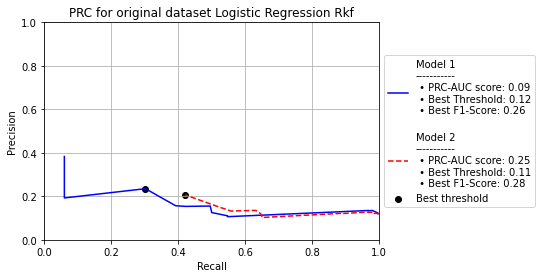

Best Threshold=0.188141, F1-Score=0.353 for model 1
Best Threshold=0.187995, F1-Score=0.353 for model 2


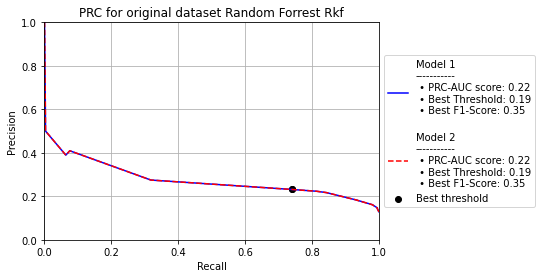

Best Threshold=0.188075, F1-Score=0.353 for model 1
Best Threshold=0.188075, F1-Score=0.353 for model 2


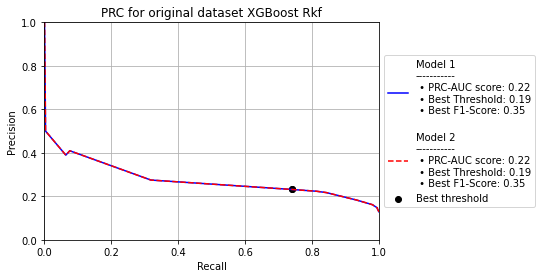

Best Threshold=0.128258, F1-Score=0.464 for model 1
Best Threshold=0.012749, F1-Score=0.201 for model 2


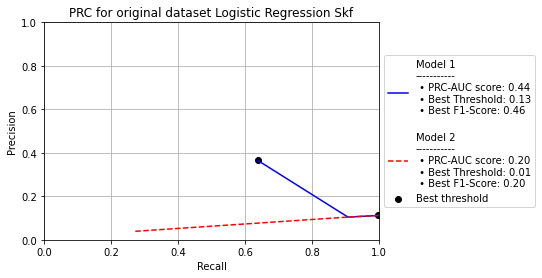

Best Threshold=0.000000, F1-Score=0.199 for model 1
Best Threshold=0.034761, F1-Score=0.201 for model 2


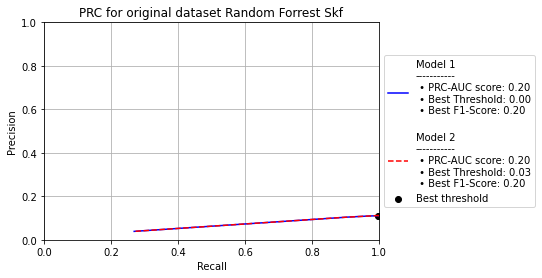

Best Threshold=0.000052, F1-Score=0.199 for model 1
Best Threshold=0.000932, F1-Score=0.200 for model 2


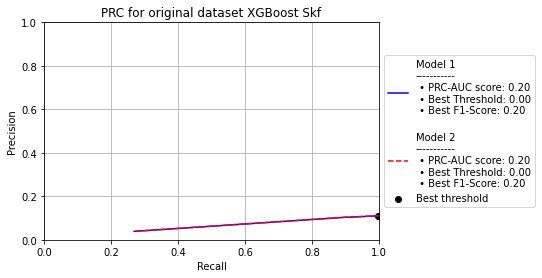

Best Threshold=0.026370, F1-Score=0.367 for model 1
Best Threshold=0.086061, F1-Score=0.390 for model 2


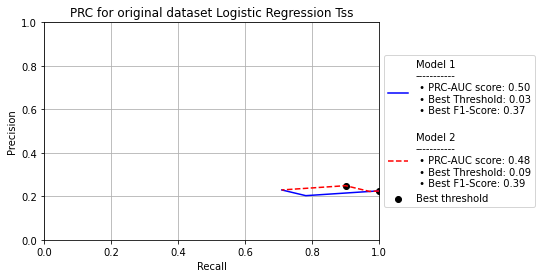

Best Threshold=0.001149, F1-Score=0.365 for model 1
Best Threshold=0.012090, F1-Score=0.365 for model 2


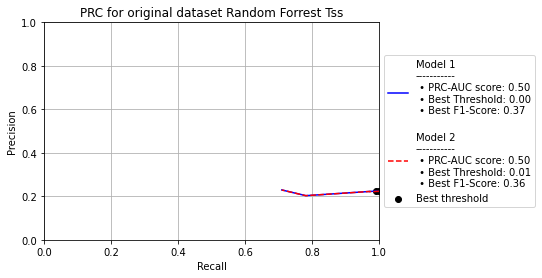

Best Threshold=0.000046, F1-Score=0.364 for model 1
Best Threshold=0.000759, F1-Score=0.366 for model 2


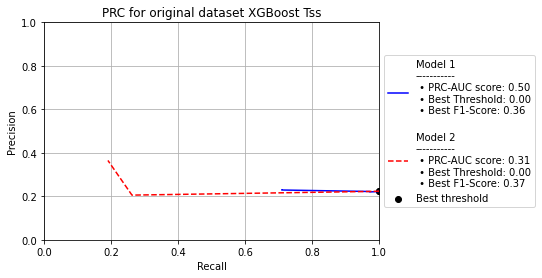

0    50453
1     6284
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5619036626925709
Average Precision-Recall Score: 0.16614410257835713
PRC-AUC for model 1: 0.18523805970305895
Accuracy: 0.889
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     12611
           1       0.00      0.00      0.00      1574

    accuracy                           0.89     14185
   macro avg       0.44      0.50      0.47     14185
weighted avg       0.79      0.89      0.84     14185


Scores for model 2
------------------
Roc_Auc Score: 0.5557613575691821
Average Precision-Recall Score: 0.14713828669028045
PRC-AUC for model 2: 0.31235439452837843
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

           

TRAIN: [    0     1     2 ... 12565 12566 12567] | TEST: [   12    16    26 ... 12543 12558 12560]

Model Score: 0.4785031847133758

Average Precision-Recall Score: 0.5313493175988493
PRC-AUC Score: 0.5436955094465044
Precision:  0.6818181818181818
Recall:  0.02262443438914027
F1:  0.0437956204379562
Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.99      0.64       593
           1       0.68      0.02      0.04       663

    accuracy                           0.48      1256
   macro avg       0.58      0.51      0.34      1256
weighted avg       0.58      0.48      0.33      1256

Accuracy: 0.479
MCC:  0.04117602836567226
TRAIN: [    0     1     2 ... 12565 12566 12567] | TEST: [   12    16    26 ... 12543 12558 12560]

Model Score: 0.4785031847133758

Average Precision-Recall Score: 0.5313493175988493
PRC-AUC Score: 0.7639331210191083
Precision:  0.6818181818181818
Recall:  0.02262443438914027
F1:  0.0437956204379562
Cla

TRAIN: [    0     1     2 ... 12565 12566 12567] | TEST: [   12    16    26 ... 12543 12558 12560]

Model Score: 0.47770700636942676

Average Precision-Recall Score: 0.5310882530952836
PRC-AUC Score: 0.7639331210191083
Precision:  0.7058823529411765
Recall:  0.01809954751131222
F1:  0.03529411764705882
Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.99      0.64       593
           1       0.71      0.02      0.04       663

    accuracy                           0.48      1256
   macro avg       0.59      0.50      0.34      1256
weighted avg       0.60      0.48      0.32      1256

Accuracy: 0.478
MCC:  0.041768958353890724
TRAIN: [    0     1     2 ... 12565 12566 12567] | TEST: [   12    16    26 ... 12543 12558 12560]

Model Score: 0.4912420382165605

Average Precision-Recall Score: 0.5295403120152321
PRC-AUC Score: 0.5415150703368379
Precision:  0.5337078651685393
Recall:  0.2865761689291101
F1:  0.37291462217860644


Accuracy: 0.510
MCC for model 2: 0.03908514172520696

Scores for model 1
------------------
Roc_Auc Score: 0.7562391199664285
Average Precision-Recall Score: 0.6917678568697238
PRC-AUC for model 1: 0.7214391610203449
Accuracy: 0.706
MCC for model 1: 0.4193270166673153
Precision score for model 1:  0.6733742994125194
Recall score for model 1:  0.7945183650705123
F1 score for model 1:  0.7289473684210526
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.62      0.68     12676
           1       0.67      0.79      0.73     12551

    accuracy                           0.71     25227
   macro avg       0.71      0.71      0.70     25227
weighted avg       0.71      0.71      0.70     25227


Scores for model 2
------------------
Roc_Auc Score: 0.7562846112317408
Average Precision-Recall Score: 0.6918522781212826
PRC-AUC for model 2: 0.7215965904933623
Precision score for model 2:  0.6733742994125194
Recall score for model 2:  0.7

TRAIN: [     0      2      3 ... 100903 100904 100905] | TEST: [     1     29     38 ... 100892 100897 100898]

Model Score: 0.7097125867195243

Average Precision-Recall Score: 0.6375285144179044
PRC-AUC Score: 0.6698953279423052
Precision:  0.6728924785461888
Recall:  0.8023675762439807
F1:  0.73194838473506
Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.62      0.68      5106
           1       0.67      0.80      0.73      4984

    accuracy                           0.71     10090
   macro avg       0.72      0.71      0.71     10090
weighted avg       0.72      0.71      0.71     10090

Accuracy: 0.710
MCC:  0.42845018643564636
Row 45 model 1
TRAIN: [     0      2      3 ... 100903 100904 100905] | TEST: [     1     29     38 ... 100892 100897 100898]

Model Score: 0.7097125867195243

Average Precision-Recall Score: 0.6375285144179044
PRC-AUC Score: 0.6697718817270728
Precision:  0.6728924785461888
Recall:  0.802367576

TRAIN: [     0      2      3 ... 100903 100904 100905] | TEST: [     1     29     38 ... 100892 100897 100898]

Model Score: 0.7098116947472746

Average Precision-Recall Score: 0.6376085834910051
PRC-AUC Score: 0.6704357183762418
Precision:  0.6729475100942126
Recall:  0.8025682182985554
F1:  0.7320644216691069
Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.62      0.68      5106
           1       0.67      0.80      0.73      4984

    accuracy                           0.71     10090
   macro avg       0.72      0.71      0.71     10090
weighted avg       0.72      0.71      0.71     10090

Accuracy: 0.710
MCC:  0.42866969786786463
TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 49740  49741  49742 ... 100903 100904 100905]

Model Score: 0.5353815659068385

Average Precision-Recall Score: 0.5184139719508281
PRC-AUC Score: 0.6642220019821605
Precision:  0.520439711439368
Recall:  0.9008919722497523
F1:  0.65974

Row 56 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7569371659133814
Average Precision-Recall Score: 0.6903230716807254
PRC-AUC for model 1: 0.7183282343439665
Accuracy: 0.709
MCC for model 1: 0.42463929151568897
Precision score for model 1:  0.6760314875135722
Recall score for model 1:  0.7947347427203829
F1 score for model 1:  0.7305929375527117
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.62      0.68     12692
           1       0.68      0.79      0.73     12535

    accuracy                           0.71     25227
   macro avg       0.72      0.71      0.71     25227
weighted avg       0.72      0.71      0.71     25227


Scores for model 2
------------------
Roc_Auc Score: 0.7570897798801238
Average Precision-Recall Score: 0.6905442899293363
PRC-AUC for model 2: 0.7186837291093934
Precision score for model 2:  0.6760754512145474
Recall score for model 2:  0.7948942959712804
F1 score for model 2:

TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 45408  45409  45410 ... 100903 100904 100905]

Model Score: 0.29425173439048563

Average Precision-Recall Score: 0.42487621798821007
PRC-AUC Score: 0.37696178734984076
Precision:  0.3651247401247401
Recall:  0.5569871159563925
F1:  0.4410956753786987
Classification Report:

              precision    recall  f1-score   support

           0       0.07      0.03      0.04      5045
           1       0.37      0.56      0.44      5045

    accuracy                           0.29     10090
   macro avg       0.22      0.29      0.24     10090
weighted avg       0.22      0.29      0.24     10090

Accuracy: 0.294
MCC:  -0.4836517311835985
TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 45408  45409  45410 ... 100903 100904 100905]

Model Score: 0.29425173439048563

Average Precision-Recall Score: 0.42487621798821007
PRC-AUC Score: 0.7512483518247979
Precision:  0.3651247401247401
Recall:  0.5569871159563925
F1:  0.44109

TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 45408  45409  45410 ... 100903 100904 100905]

Model Score: 0.5372646184340931

Average Precision-Recall Score: 0.5194327831962068
PRC-AUC Score: 0.7515958507879513
Precision:  0.5214808043875686
Recall:  0.9046580773042616
F1:  0.6615930999492644
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.17      0.27      5045
           1       0.52      0.90      0.66      5045

    accuracy                           0.54     10090
   macro avg       0.58      0.54      0.47     10090
weighted avg       0.58      0.54      0.47     10090

Accuracy: 0.537
MCC:  0.1098768331359197
TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 45408  45409  45410 ... 100903 100904 100905]

Model Score: 0.39930624380574825

Average Precision-Recall Score: 0.4553430471694681
PRC-AUC Score: 0.3765485545458318
Precision:  0.4434927697441602
Recall:  0.7902874132804757
F1:  0.5681510509

Performing analysis for: Lucene
                   Name                                               File  \
14273   Mike McCandless  lucene/core/src/java/org/apache/lucene/util/pa...   
14274   Mike McCandless  lucene/analysis/common/src/java/org/apache/luc...   
14275   Mike McCandless  lucene/analysis/common/src/test/org/apache/luc...   
14276   Mike McCandless  lucene/analysis/common/src/java/org/apache/luc...   
14277   Mike McCandless  lucene/analysis/common/src/test/org/apache/luc...   
...                 ...                                                ...   
349173         Sam Ruby                                 docs/features.html   
349174         Sam Ruby                                           build.sh   
349175         Sam Ruby                            Attic/api/overview.html   
349176         Sam Ruby                                xdocs/resources.xml   
349177         Sam Ruby                               docs/background.html   

                       Bug  Pag

Average Precision-Recall Score: 0.44143675653195685
PRC-AUC for model 1: 0.46560681276406496
Accuracy: 0.806
MCC for model 1: 0.24924668225052538
Precision score for model 1:  0.6056848531095002
Recall score for model 1:  0.17612470183613468
F1 score for model 1:  0.2728952683828269
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     69268
           1       0.61      0.18      0.27     18027

    accuracy                           0.81     87295
   macro avg       0.71      0.57      0.58     87295
weighted avg       0.77      0.81      0.76     87295


Scores for model 2
------------------
Roc_Auc Score: 0.777027624559324
Average Precision-Recall Score: 0.4414447867195936
PRC-AUC for model 2: 0.4656183084041384
Precision score for model 2:  0.6056848531095002
Recall score for model 2:  0.17612470183613468
F1 score for model 2:  0.2728952683828269
Classification Report:

              precision    recall  f1-sc

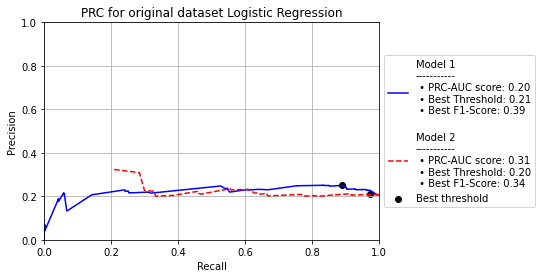

Best Threshold=0.240824, F1-Score=0.487 for model 1
Best Threshold=0.241955, F1-Score=0.487 for model 2


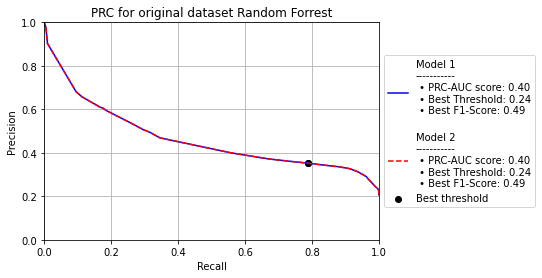

Best Threshold=0.240592, F1-Score=0.487 for model 1
Best Threshold=0.240895, F1-Score=0.487 for model 2


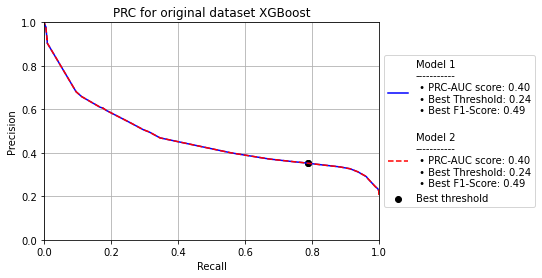

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5716980565929352
Average Precision-Recall Score: 0.2323488232162002
PRC-AUC for model 1: 0.19557508291995943
Accuracy: 0.426
MCC for model 1: 0.17879905936236393
Precision score for model 1:  0.2499376791723794
Recall score for model 1:  0.889887391135519
F1 score for model 1:  0.3902640765834256
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.30      0.46     69268
           1       0.25      0.89      0.39     18027

    accuracy                           0.43     87295
   macro avg       0.58      0.60      0.42     87295
weighted avg       0.78      0.43      0.44     87295


Scores for model 2
------------------
Roc_Auc Score: 0.5301216245864052
Average Precision-Recall Score: 0.24520298844374633
PRC-AUC for model 2: 0.30931772922463485
Precision score for model 2:  0.2089518481042795
Recall score for model 2:  0

TRAIN: [     0      1      2 ... 325295 325296 325297] | TEST: [306461 306462 306463 ... 349175 349176 349177]

Model Score: 0.5974453704499241

Average Precision-Recall Score: 0.19312442062516916
PRC-AUC Score: 0.13644656631389365
Precision:  0.08768991506161024
Recall:  0.1023314253804272
F1:  0.0944465919340291
Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     27754
           1       0.09      0.10      0.09      7163

    accuracy                           0.60     34917
   macro avg       0.42      0.41      0.42     34917
weighted avg       0.62      0.60      0.61     34917

Accuracy: 0.597
MCC:  -0.16318223559572959
Original_XGB_Classifier_skf model 1
TRAIN: [     0      1      2 ... 325295 325296 325297] | TEST: [306461 306462 306463 ... 349175 349176 349177]

Model Score: 0.5712976487097975

Average Precision-Recall Score: 0.2006787419502887
PRC-AUC Score: 0.13286772123777404
Precision:  0.021339220

TRAIN: [     0      1      2 ... 325295 325296 325297] | TEST: [306461 306462 306463 ... 349175 349176 349177]

Model Score: 0.5981613540682189

Average Precision-Recall Score: 0.20285259766823918
PRC-AUC Score: 0.14467072796891403
Precision:  0.012077294685990338
Recall:  0.011866536367443808
F1:  0.011970987958594467
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     27754
           1       0.01      0.01      0.01      7163

    accuracy                           0.60     34917
   macro avg       0.38      0.38      0.38     34917
weighted avg       0.60      0.60      0.60     34917

Accuracy: 0.598
MCC:  -0.24022557162830518
Row 14 model 2

Model Score: 0.6504742593992714

Average Precision-Recall Score: 0.34952574060072855
PRC-AUC Score: 0.46443001708070536
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.65      1.0

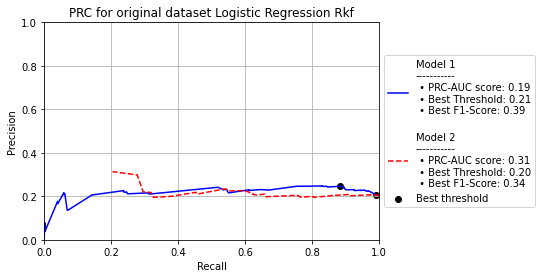

Best Threshold=0.265963, F1-Score=0.483 for model 1
Best Threshold=0.265695, F1-Score=0.483 for model 2


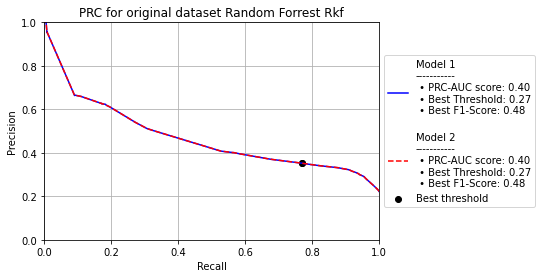

Best Threshold=0.266027, F1-Score=0.483 for model 1
Best Threshold=0.266225, F1-Score=0.483 for model 2


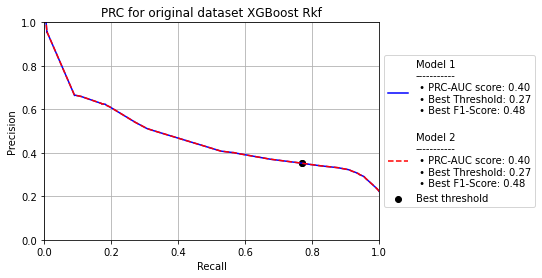

Best Threshold=0.013929, F1-Score=0.344 for model 1
Best Threshold=0.147655, F1-Score=0.345 for model 2


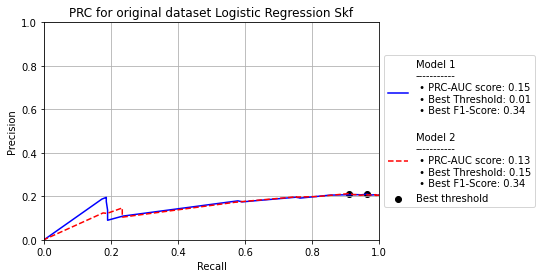

Best Threshold=0.005909, F1-Score=0.342 for model 1
Best Threshold=0.076783, F1-Score=0.341 for model 2


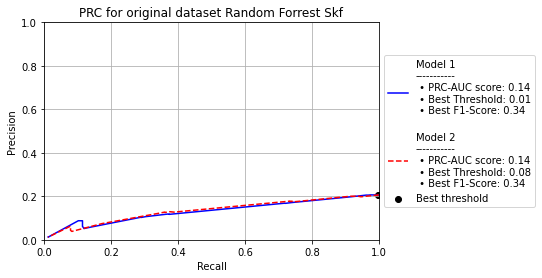

Best Threshold=0.000045, F1-Score=0.341 for model 1
Best Threshold=0.000084, F1-Score=0.342 for model 2


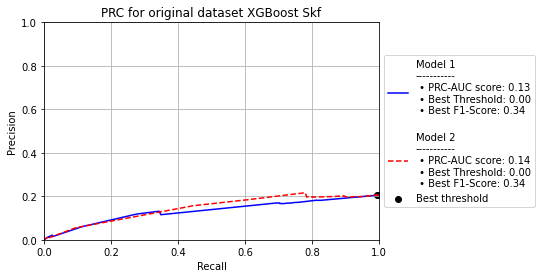

Best Threshold=0.074074, F1-Score=0.525 for model 1
Best Threshold=0.110010, F1-Score=0.529 for model 2


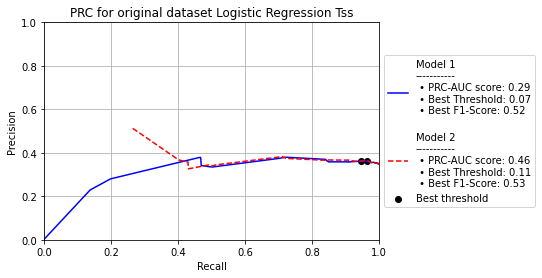

Best Threshold=0.000000, F1-Score=0.518 for model 1
Best Threshold=0.000000, F1-Score=0.518 for model 2


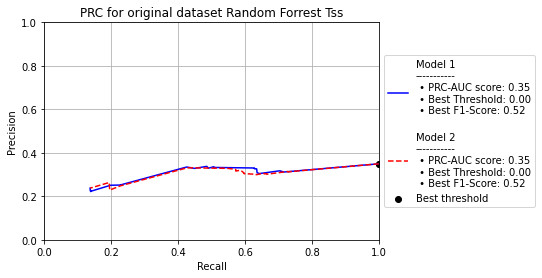

Best Threshold=0.000040, F1-Score=0.522 for model 1
Best Threshold=0.000063, F1-Score=0.523 for model 2


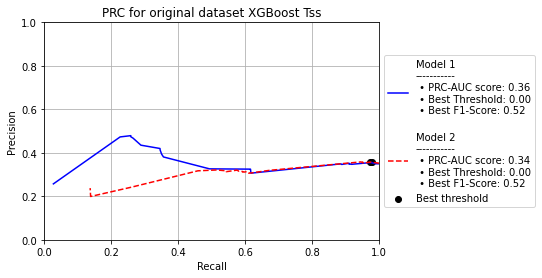

0    277547
1     71631
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5756861940104232
Average Precision-Recall Score: 0.23447440108706097
PRC-AUC for model 1: 0.22291672645400082
Accuracy: 0.794
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.79      1.00      0.89     69298
           1       0.00      0.00      0.00     17997

    accuracy                           0.79     87295
   macro avg       0.40      0.50      0.44     87295
weighted avg       0.63      0.79      0.70     87295


Scores for model 2
------------------
Roc_Auc Score: 0.5261641817275439
Average Precision-Recall Score: 0.243030752731067
PRC-AUC for model 2: 0.31118412985438404
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

           

MCC for model 2: 0.33750655810172564
TRAIN: [     1      2      3 ... 143259 143260 143261] | TEST: [     0      5      8 ... 143239 143251 143256]

Model Score: 0.4919726371631998

Average Precision-Recall Score: 0.5058099773945401
PRC-AUC Score: 0.5059189442094835
Precision:  0.4978668941979522
Recall:  0.16056686846450194
F1:  0.24282147315855182
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.83      0.62      7058
           1       0.50      0.16      0.24      7268

    accuracy                           0.49     14326
   macro avg       0.49      0.50      0.43     14326
weighted avg       0.49      0.49      0.43     14326

Accuracy: 0.492
MCC:  -0.008371317457861023
TRAIN: [     1      2      3 ... 143259 143260 143261] | TEST: [     0      5      8 ... 143239 143251 143256]

Model Score: 0.4919726371631998

Average Precision-Recall Score: 0.5058099773945401
PRC-AUC Score: 0.753664665642887
Precision:  0.4978668941

TRAIN: [     1      2      3 ... 143259 143260 143261] | TEST: [     0      5      8 ... 143239 143251 143256]

Model Score: 0.49260086555912325

Average Precision-Recall Score: 0.5072448525685529
PRC-AUC Score: 0.753664665642887
Precision:  0.49504950495049505
Recall:  0.006879471656576775
F1:  0.013570362328674175
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.99      0.66      7058
           1       0.50      0.01      0.01      7268

    accuracy                           0.49     14326
   macro avg       0.49      0.50      0.34     14326
weighted avg       0.49      0.49      0.33     14326

Accuracy: 0.493
MCC:  -0.0020696811048114936
TRAIN: [     1      2      3 ... 143259 143260 143261] | TEST: [     0      5      8 ... 143239 143251 143256]

Model Score: 0.4965098422448695

Average Precision-Recall Score: 0.5054575663589571
PRC-AUC Score: 0.5010256106103547
Precision:  0.5036977275783245
Recall:  0.51541001651073

Accuracy: 0.714
MCC for model 1: 0.4545401891714946
Precision score for model 1:  0.6605984177283408
Recall score for model 1:  0.8822750370679603
F1 score for model 1:  0.755511726093254
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.55      0.66     69307
           1       0.66      0.88      0.76     69467

    accuracy                           0.71    138774
   macro avg       0.74      0.71      0.71    138774
weighted avg       0.74      0.71      0.71    138774


Scores for model 2
------------------
Roc_Auc Score: 0.7783170731673933
Average Precision-Recall Score: 0.7383460519015743
PRC-AUC for model 2: 0.7535407239634673
Precision score for model 2:  0.6605984177283408
Recall score for model 2:  0.8822750370679603
F1 score for model 2:  0.755511726093254
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.55      0.66     69307
           1       0.66     

TRAIN: [     0      2      3 ... 555090 555091 555092] | TEST: [     1      4     15 ... 555068 555072 555093]

Model Score: 0.7142625520185916

Average Precision-Recall Score: 0.6422537586582407
PRC-AUC Score: 0.7025789180355455
Precision:  0.6610740062479802
Recall:  0.8822556877403587
F1:  0.7558155646216611
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.55      0.66     27686
           1       0.66      0.88      0.76     27823

    accuracy                           0.71     55509
   macro avg       0.74      0.71      0.71     55509
weighted avg       0.74      0.71      0.71     55509

Accuracy: 0.714
MCC:  0.4544159605245279
Row 45 model 1
TRAIN: [     0      2      3 ... 555090 555091 555092] | TEST: [     1      4     15 ... 555068 555072 555093]

Model Score: 0.7142445369219406

Average Precision-Recall Score: 0.6422399610072694
PRC-AUC Score: 0.7025603069796653
Precision:  0.6610648784034904
Recall:  0.88221974

TRAIN: [     0      2      3 ... 555090 555091 555092] | TEST: [     1      4     15 ... 555068 555072 555093]

Model Score: 0.7142445369219406

Average Precision-Recall Score: 0.6422399610072694
PRC-AUC Score: 0.7025139171047385
Precision:  0.6610648784034904
Recall:  0.8822197462531
F1:  0.755796409766912
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.55      0.66     27686
           1       0.66      0.88      0.76     27823

    accuracy                           0.71     55509
   macro avg       0.74      0.71      0.71     55509
weighted avg       0.74      0.71      0.71     55509

Accuracy: 0.714
MCC:  0.45437152962548105
TRAIN: [     0      1      2 ... 527336 527337 527338] | TEST: [306461 306462 306463 ... 555091 555092 555093]

Model Score: 0.26624511340503343

Average Precision-Recall Score: 0.4490067953518486
PRC-AUC Score: 0.3386790194384556
Precision:  0.2181920854871639
Recall:  0.1809764006485318
F1:  0.1

Average Precision-Recall Score: 0.738719519015851
PRC-AUC for model 1: 0.7538472044668226
Accuracy: 0.714
MCC for model 1: 0.45258393086139787
Precision score for model 1:  0.6605573036623739
Recall score for model 1:  0.8796112311015118
F1 score for model 1:  0.7545065490857218
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.55      0.66     69324
           1       0.66      0.88      0.75     69450

    accuracy                           0.71    138774
   macro avg       0.74      0.71      0.71    138774
weighted avg       0.74      0.71      0.71    138774


Scores for model 2
------------------
Roc_Auc Score: 0.7782601102142052
Average Precision-Recall Score: 0.7386259111865602
PRC-AUC for model 2: 0.7537853668615495
Precision score for model 2:  0.66053954695356
Recall score for model 2:  0.879625629949604
F1 score for model 2:  0.7545002624509832
Classification Report:

              precision    recall  f1-score   s

TRAIN: [     0      1      2 ... 527336 527337 527338] | TEST: [249793 249794 249795 ... 555091 555092 555093]

Model Score: 0.5616926984813273

Average Precision-Recall Score: 0.5330999758966897
PRC-AUC Score: 0.39259555649728084
Precision:  0.5364478024901564
Recall:  0.9081246622230229
F1:  0.6744715012041744
Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.22      0.33     27754
           1       0.54      0.91      0.67     27755

    accuracy                           0.56     55509
   macro avg       0.62      0.56      0.50     55509
weighted avg       0.62      0.56      0.50     55509

Accuracy: 0.562
MCC:  0.1711007435705563
TRAIN: [     0      1      2 ... 527336 527337 527338] | TEST: [249793 249794 249795 ... 555091 555092 555093]

Model Score: 0.5616926984813273

Average Precision-Recall Score: 0.5330999758966897
PRC-AUC Score: 0.7488012146271196
Precision:  0.5364478024901564
Recall:  0.9081246622230229
F1:  

TRAIN: [     0      1      2 ... 527336 527337 527338] | TEST: [249793 249794 249795 ... 555091 555092 555093]

Model Score: 0.26802860797348177

Average Precision-Recall Score: 0.44861937252567996
PRC-AUC Score: 0.7500045037741627
Precision:  0.22153979238754326
Recall:  0.1845433255269321
F1:  0.20135626535626536
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.35      0.32     27754
           1       0.22      0.18      0.20     27755

    accuracy                           0.27     55509
   macro avg       0.26      0.27      0.26     55509
weighted avg       0.26      0.27      0.26     55509

Accuracy: 0.268
MCC:  -0.4705462662309876
TRAIN: [     0      1      2 ... 527336 527337 527338] | TEST: [249793 249794 249795 ... 555091 555092 555093]

Model Score: 0.4547911149543317

Average Precision-Recall Score: 0.47849643458525887
PRC-AUC Score: 0.4022443841812431
Precision:  0.4757748382736314
Recall:  0.8876959106467304


Performing analysis for: Mahout
                      Name                                               File  \
0         Otis Gospodnetic  core/src/main/java/org/apache/mahout/cf/taste/...   
200      Karl-Johan Wettin  core/src/main/java/org/apache/mahout/utils/Tan...   
201      Karl-Johan Wettin  core/src/test/java/org/apache/mahout/utils/Tes...   
202      Karl-Johan Wettin  src/main/java/org/apache/mahout/utils/Weighted...   
203      Karl-Johan Wettin  src/test/java/org/apache/mahout/utils/TestEucl...   
...                    ...                                                ...   
51485  Abdel Hakim Deneche  core/src/test/java/org/apache/mahout/df/split/...   
51486  Abdel Hakim Deneche  core/src/test/java/org/apache/mahout/df/data/D...   
51487  Abdel Hakim Deneche  core/src/main/java/org/apache/mahout/df/Decisi...   
51488  Abdel Hakim Deneche  core/src/main/java/org/apache/mahout/df/Baggin...   
51489  Abdel Hakim Deneche  core/src/test/java/org/apache/mahout/df/data/D...



Scores for model 2
------------------
Roc_Auc Score: 0.8159994544364512
Average Precision-Recall Score: 0.6690479692503558
PRC-AUC for model 2: 0.702332530368408
Precision score for model 2:  0.6124472186524692
Recall score for model 2:  0.7021679646390233
F1 score for model 2:  0.6542459305746224
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      8122
           1       0.61      0.70      0.65      4751

    accuracy                           0.73     12873
   macro avg       0.71      0.72      0.71     12873
weighted avg       0.74      0.73      0.73     12873

Accuracy: 0.726
MCC for model 2: 0.4319586577931652
Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8156635954400092
Average Precision-Recall Score: 0.6693337721477317
PRC-AUC for model 1: 0.7005834139834577
Accuracy: 0.726
MCC for model 1: 0.4318278441310325
Precision score for model 1:  0.6123348017621145
Recall sco

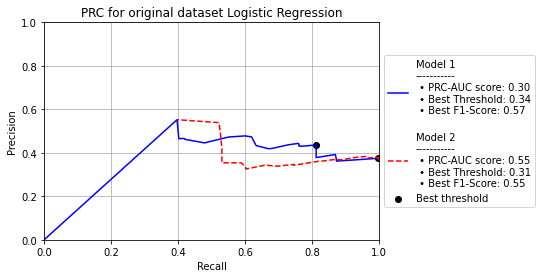

Best Threshold=0.351020, F1-Score=0.697 for model 1
Best Threshold=0.349906, F1-Score=0.697 for model 2


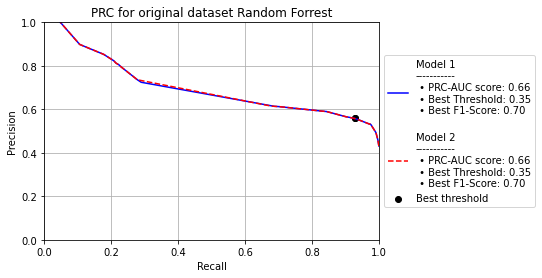

Best Threshold=0.350842, F1-Score=0.697 for model 1
Best Threshold=0.350700, F1-Score=0.697 for model 2


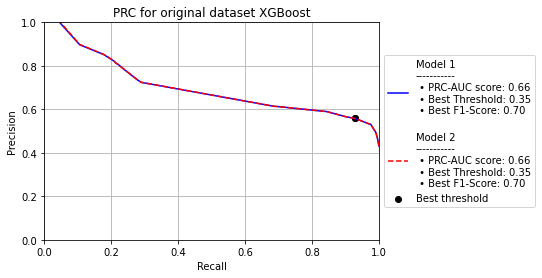

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.6134614747703292
Average Precision-Recall Score: 0.47763874945842205
PRC-AUC for model 1: 0.29644210128827186
Accuracy: 0.540
MCC for model 1: 0.20118495139584872
Precision score for model 1:  0.43396650556367317
Recall score for model 1:  0.8126710166280783
F1 score for model 1:  0.5657971864009379
Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.38      0.51      8122
           1       0.43      0.81      0.57      4751

    accuracy                           0.54     12873
   macro avg       0.61      0.60      0.54     12873
weighted avg       0.65      0.54      0.53     12873


Scores for model 2
------------------
Roc_Auc Score: 0.5541925724264637
Average Precision-Recall Score: 0.45928985765922214
PRC-AUC for model 2: 0.547257639761792
Precision score for model 2:  0.3783288151809919
Recall score for model 2:  

TRAIN: [    0     1     2 ... 47819 47820 47821] | TEST: [43565 43566 43567 ... 51488 51489 51490]

Model Score: 0.3278306467275199

Average Precision-Recall Score: 0.3183139161418588
PRC-AUC Score: 0.3166255681021
Precision:  0.21965112139551443
Recall:  0.3271474019088017
F1:  0.2628328008519702
Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.33      0.38      3263
           1       0.22      0.33      0.26      1886

    accuracy                           0.33      5149
   macro avg       0.34      0.33      0.32      5149
weighted avg       0.37      0.33      0.34      5149

Accuracy: 0.328
MCC:  -0.33346091012228213
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 47819 47820 47821] | TEST: [43565 43566 43567 ... 51488 51489 51490]

Model Score: 0.34084288211303165

Average Precision-Recall Score: 0.32498431046809606
PRC-AUC Score: 0.2605768050320679
Precision:  0.1758383490971625
Recall:  0.216861081

TRAIN: [    0     1     2 ... 47819 47820 47821] | TEST: [43565 43566 43567 ... 51488 51489 51490]

Model Score: 0.41444940765197125

Average Precision-Recall Score: 0.356087455643806
PRC-AUC Score: 0.22516893762902654
Precision:  0.35195384211906633
Recall:  0.711558854718982
F1:  0.47095981751184407
Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.24      0.34      3263
           1       0.35      0.71      0.47      1886

    accuracy                           0.41      5149
   macro avg       0.47      0.48      0.41      5149
weighted avg       0.50      0.41      0.39      5149

Accuracy: 0.414
MCC:  -0.050251189045666673
Row 14 model 2

Model Score: 0.45659014100920636

Average Precision-Recall Score: 0.5434098589907936
PRC-AUC Score: 0.5874771156398322
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.46      1.00      0.63      3

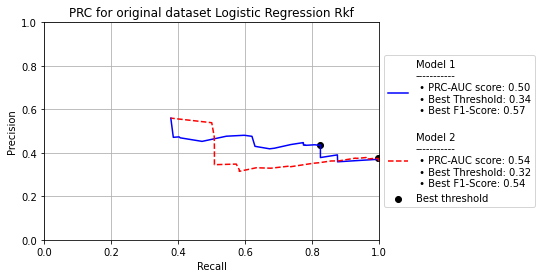

Best Threshold=0.294957, F1-Score=0.695 for model 1
Best Threshold=0.298643, F1-Score=0.695 for model 2


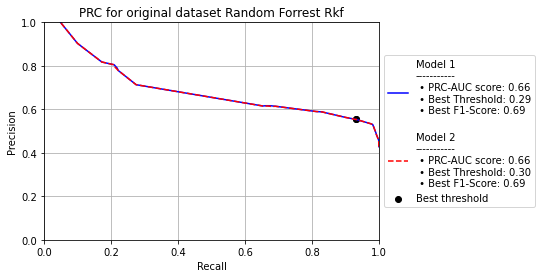

Best Threshold=0.305257, F1-Score=0.695 for model 1
Best Threshold=0.301590, F1-Score=0.695 for model 2


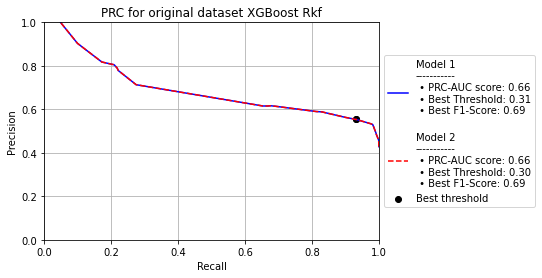

Best Threshold=0.339201, F1-Score=0.536 for model 1
Best Threshold=0.307782, F1-Score=0.536 for model 2


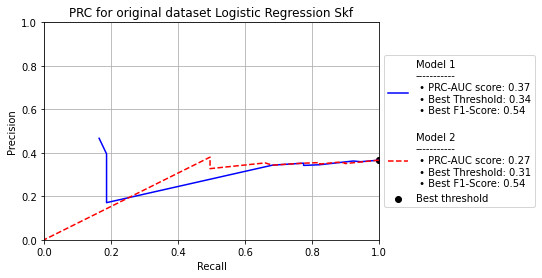

Best Threshold=0.273242, F1-Score=0.536 for model 1
Best Threshold=0.367043, F1-Score=0.545 for model 2


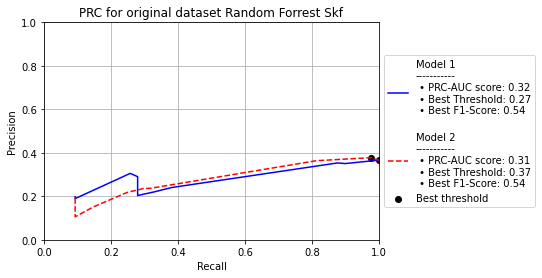

Best Threshold=0.154620, F1-Score=0.536 for model 1
Best Threshold=0.601812, F1-Score=0.545 for model 2


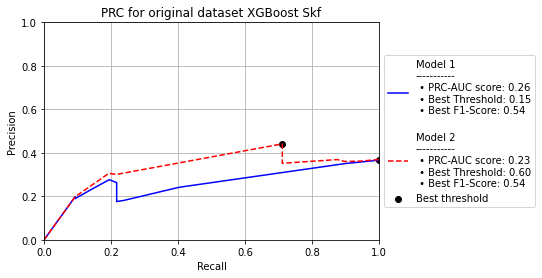

Best Threshold=0.305063, F1-Score=0.704 for model 1
Best Threshold=0.269436, F1-Score=0.704 for model 2


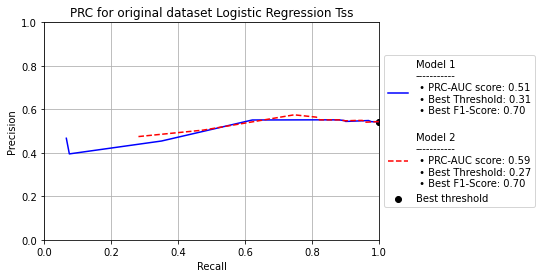

Best Threshold=0.000000, F1-Score=0.704 for model 1
Best Threshold=0.000000, F1-Score=0.704 for model 2


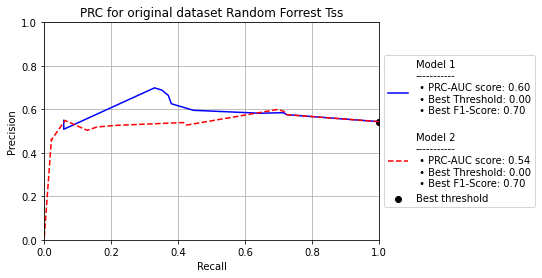

Best Threshold=0.000852, F1-Score=0.704 for model 1
Best Threshold=0.000095, F1-Score=0.704 for model 2


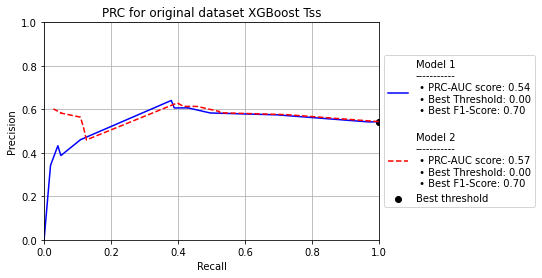

0    32631
1    18860
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.6189700155411624
Average Precision-Recall Score: 0.47880884650475
PRC-AUC for model 1: 0.5621537628577102
Accuracy: 0.632
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.63      1.00      0.77      8136
           1       0.00      0.00      0.00      4737

    accuracy                           0.63     12873
   macro avg       0.32      0.50      0.39     12873
weighted avg       0.40      0.63      0.49     12873


Scores for model 2
------------------
Roc_Auc Score: 0.5488371735800656
Average Precision-Recall Score: 0.4553123281646112
PRC-AUC for model 2: 0.5397230873859847
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              pre

TRAIN: [    0     1     2 ... 37717 37718 37719] | TEST: [   17    29    30 ... 37665 37673 37692]

Model Score: 0.5005302226935313

Average Precision-Recall Score: 0.505856246125334
PRC-AUC Score: 0.5765917209268978
Precision:  0.5054501412999596
Recall:  0.6551543694400838
F1:  0.5706472196900638
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.34      0.40      1861
           1       0.51      0.66      0.57      1911

    accuracy                           0.50      3772
   macro avg       0.50      0.50      0.49      3772
weighted avg       0.50      0.50      0.49      3772

Accuracy: 0.501
MCC:  -0.0032576895548221615
TRAIN: [    0     1     2 ... 37717 37718 37719] | TEST: [   17    29    30 ... 37665 37673 37692]

Model Score: 0.5005302226935313

Average Precision-Recall Score: 0.505856246125334
PRC-AUC Score: 0.7533138918345705
Precision:  0.5054501412999596
Recall:  0.6551543694400838
F1:  0.5706472196900638
Clas

TRAIN: [    0     1     2 ... 37717 37718 37719] | TEST: [   17    29    30 ... 37665 37673 37692]

Model Score: 0.5066277836691411

Average Precision-Recall Score: 0.5092430752963789
PRC-AUC Score: 0.5095323676470214
Precision:  0.5108885017421603
Recall:  0.6138147566718996
F1:  0.5576420251961018
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.40      0.44      1861
           1       0.51      0.61      0.56      1911

    accuracy                           0.51      3772
   macro avg       0.51      0.51      0.50      3772
weighted avg       0.51      0.51      0.50      3772

Accuracy: 0.507
MCC:  0.010629032022229045
Row 27 model 2
TRAIN: [    0     1     2 ... 37717 37718 37719] | TEST: [   17    29    30 ... 37665 37673 37692]

Model Score: 0.5071580063626723

Average Precision-Recall Score: 0.509592184942319
PRC-AUC Score: 0.5095995695877573
Precision:  0.5115452930728241
Recall:  0.6028257456828885
F1:  0.5534470



Scores for model 2
------------------
Roc_Auc Score: 0.8094674531318368
Average Precision-Recall Score: 0.7626311508480432
PRC-AUC for model 2: 0.7916105125566177
Precision score for model 2:  0.6853504368841792
Recall score for model 2:  0.9017857142857143
F1 score for model 2:  0.7788106052603782
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.58      0.69      8140
           1       0.69      0.90      0.78      8176

    accuracy                           0.74     16316
   macro avg       0.77      0.74      0.74     16316
weighted avg       0.77      0.74      0.74     16316

Accuracy: 0.743
MCC for model 2: 0.5126707122277018

Scores for model 1
------------------
Roc_Auc Score: 0.6120195682695683
Average Precision-Recall Score: 0.6033617010706424
PRC-AUC for model 1: 0.5730113566395254
Accuracy: 0.515
MCC for model 1: 0.11320130333020934
Precision score for model 1:  0.5079601990049751
Recall score for model 1:  0.

TRAIN: [    0     1     2 ... 61996 61997 61998] | TEST: [43565 43566 43567 ... 65259 65260 65261]

Model Score: 0.42522218817039537

Average Precision-Recall Score: 0.46584501575950177
PRC-AUC Score: 0.7027073021211463
Precision:  0.45675292449486
Recall:  0.7897640208397181
F1:  0.5787759685569905
Classification Report:

              precision    recall  f1-score   support

           0       0.22      0.06      0.10      3263
           1       0.46      0.79      0.58      3263

    accuracy                           0.43      6526
   macro avg       0.34      0.43      0.34      6526
weighted avg       0.34      0.43      0.34      6526

Accuracy: 0.425
MCC:  -0.21851293409696806
TRAIN: [    0     1     2 ... 61996 61997 61998] | TEST: [43565 43566 43567 ... 65259 65260 65261]

Model Score: 0.4566349984676678

Average Precision-Recall Score: 0.4793006986757222
PRC-AUC Score: 0.4514714654366171
Precision:  0.47732735138599586
Recall:  0.912963530493411
F1:  0.6268939393939393
Clas

TRAIN: [    0     1     2 ... 61996 61997 61998] | TEST: [43565 43566 43567 ... 65259 65260 65261]

Model Score: 0.4566349984676678

Average Precision-Recall Score: 0.4793006986757222
PRC-AUC Score: 0.45370682001360285
Precision:  0.47732735138599586
Recall:  0.912963530493411
F1:  0.6268939393939393
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3263
           1       0.48      0.91      0.63      3263

    accuracy                           0.46      6526
   macro avg       0.24      0.46      0.31      6526
weighted avg       0.24      0.46      0.31      6526

Accuracy: 0.457
MCC:  -0.21219586380483943
Row 49 model 2
TRAIN: [    0     1     2 ... 61996 61997 61998] | TEST: [43565 43566 43567 ... 65259 65260 65261]

Model Score: 0.4566349984676678

Average Precision-Recall Score: 0.4793006986757222
PRC-AUC Score: 0.3681715490801978
Precision:  0.47732735138599586
Recall:  0.912963530493411
F1:  0.62689


Scores for model 1
------------------
Roc_Auc Score: 0.8116642093104063
Average Precision-Recall Score: 0.7652588507599399
PRC-AUC for model 1: 0.7708154730753065
Accuracy: 0.738
MCC for model 1: 0.53934973680363
Precision score for model 1:  0.6610311349179779
Recall score for model 1:  0.9720615384615384
F1 score for model 1:  0.7869277138444677
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.51      0.66      8191
           1       0.66      0.97      0.79      8125

    accuracy                           0.74     16316
   macro avg       0.80      0.74      0.72     16316
weighted avg       0.81      0.74      0.72     16316


Scores for model 2
------------------
Roc_Auc Score: 0.811592671130603
Average Precision-Recall Score: 0.7651959386542332
PRC-AUC for model 2: 0.7706529642141702
Precision score for model 2:  0.6609205020920502
Recall score for model 2:  0.9720615384615384
F1 score for model 2:  0.786849315068493


Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999999
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   10877.0

    accuracy                           0.00   10877.0
   macro avg       0.00      0.00      0.00   10877.0
weighted avg       0.00      0.00      0.00   10877.0

Accuracy: 0.000
MCC:  0.0

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   10877.0

    accuracy                           0.00   10877.0
   macro avg       0.00      0.00      0.00   10877.0
weighted avg       0.00      0.00      0.00   10877.0

Accuracy: 0.000
MCC:  0.0
TRAIN: 


Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   10877.0

    accuracy                           0.00   10877.0
   macro avg       0.00      0.00      0.00   10877.0
weighted avg       0.00      0.00      0.00   10877.0

Accuracy: 0.000
MCC:  0.0
TRAIN: [    0     1     2 ... 61996 61997 61998] | TEST: [29368 29369 29370 ... 65259 65260 65261]

Model Score: 0.4595464296659516

Average Precision-Recall Score: 0.48063727167506226
PRC-AUC Score: 0.4517874701648845
Precision:  0.4786407766990291
Recall:  0.9065277352129941
F1:  0.626495817007307
Classification Report:

              precision    recall  f1-score   support

           0       0.12      0.01      0.02      3263
           1       0.48      0.91      0.63      3263

    accuracy          

Performing analysis for: OpenJPA
                Name                                               File  \
3702   Mark Struberg                                            pom.xml   
3703   Mark Struberg                                    openjpa/pom.xml   
3704   Mark Struberg                           openjpa-features/pom.xml   
3705   Mark Struberg      openjpa-features/src/main/feature/feature.xml   
12652   Jody Grassel  openjpa-kernel/src/main/java/org/apache/openjp...   
...              ...                                                ...   
42108    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   
42109    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   
42110    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   
42111    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   
42112    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   

                      Bug  PageRank  Betweenness  Closeness  Harmo

Average Precision-Recall Score: 0.663543840245698
PRC-AUC for model 2: 0.6926482054383438
Precision score for model 2:  0.6517046848172676
Recall score for model 2:  0.7812408115260218
F1 score for model 2:  0.7106178122492647
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      7128
           1       0.65      0.78      0.71      3401

    accuracy                           0.79     10529
   macro avg       0.77      0.79      0.78     10529
weighted avg       0.81      0.79      0.80     10529

Accuracy: 0.794
MCC for model 2: 0.5587433207818863
Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8630963783676221
Average Precision-Recall Score: 0.6635033794427806
PRC-AUC for model 1: 0.6926055407722546
Accuracy: 0.794
MCC for model 1: 0.5587433207818863
Precision score for model 1:  0.6517046848172676
Recall score for model 1:  0.7812408115260218
F1 score for model 1:  0.7106178122492

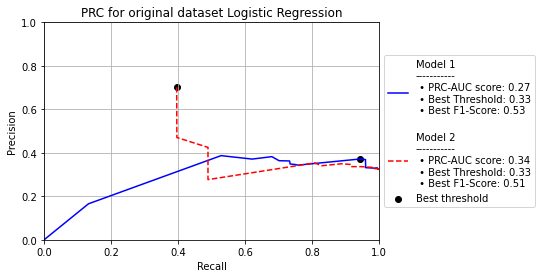

Best Threshold=0.571610, F1-Score=0.711 for model 1
Best Threshold=0.407902, F1-Score=0.711 for model 2


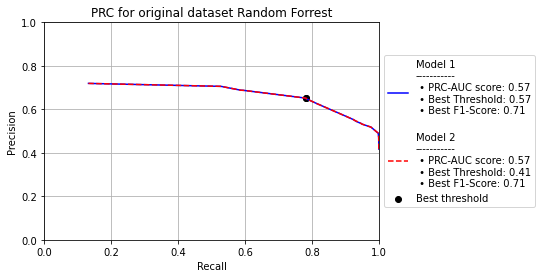

Best Threshold=0.572259, F1-Score=0.711 for model 1
Best Threshold=0.572284, F1-Score=0.711 for model 2


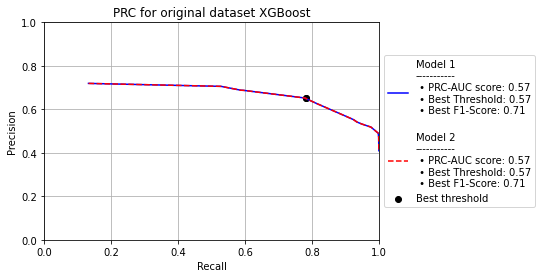

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5122686030813542
Average Precision-Recall Score: 0.34818608545717045
PRC-AUC for model 1: 0.27235467767164345
Accuracy: 0.466
MCC for model 1: 0.22240935216435204
Precision score for model 1:  0.3716435185185185
Recall score for model 1:  0.9441340782122905
F1 score for model 1:  0.5333444066107466
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.24      0.38      7128
           1       0.37      0.94      0.53      3401

    accuracy                           0.47     10529
   macro avg       0.64      0.59      0.46     10529
weighted avg       0.73      0.47      0.43     10529


Scores for model 2
------------------
Roc_Auc Score: 0.5872292256750259
Average Precision-Recall Score: 0.4896238755409967
PRC-AUC for model 2: 0.336888084941793
Precision score for model 2:  0.7011972930765227
Recall score for model 2:  0.

TRAIN: [    0     1     2 ... 40604 40605 40606] | TEST: [31048 31049 31050 ... 42113 42114 42115]

Model Score: 0.31773925433388744

Average Precision-Recall Score: 0.3141925721753552
PRC-AUC Score: 0.6493693776595448
Precision:  0.3130456472935894
Recall:  0.913391557496361
F1:  0.4662827419654468
Classification Report:

              precision    recall  f1-score   support

           0       0.41      0.03      0.05      2837
           1       0.31      0.91      0.47      1374

    accuracy                           0.32      4211
   macro avg       0.36      0.47      0.26      4211
weighted avg       0.38      0.32      0.19      4211

Accuracy: 0.318
MCC:  -0.12582858026894586
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 40604 40605 40606] | TEST: [31048 31049 31050 ... 42113 42114 42115]

Model Score: 0.31773925433388744

Average Precision-Recall Score: 0.3141925721753552
PRC-AUC Score: 0.21550171779905217
Precision:  0.3130456472935894
Recall:  0.9133915

TRAIN: [    0     1     2 ... 40604 40605 40606] | TEST: [31048 31049 31050 ... 42113 42114 42115]

Model Score: 0.33270007124198525

Average Precision-Recall Score: 0.3252486552356556
PRC-AUC Score: 0.21550171779905217
Precision:  0.3252190847127556
Recall:  0.9723435225618632
F1:  0.4874133527909523
Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.02      0.04      2837
           1       0.33      0.97      0.49      1374

    accuracy                           0.33      4211
   macro avg       0.48      0.50      0.27      4211
weighted avg       0.53      0.33      0.19      4211

Accuracy: 0.333
MCC:  -0.014401938520772099
Row 14 model 2

Model Score: 0.21840718051004415

Average Precision-Recall Score: 0.7815928194899558
PRC-AUC Score: 0.9285476553051919
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.22      1.00      0.36      1

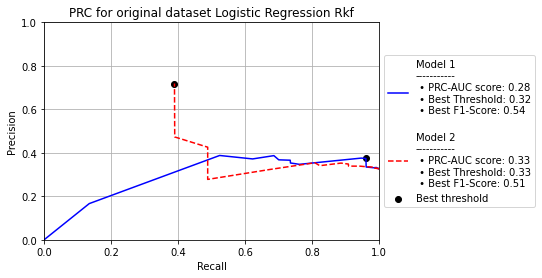

Best Threshold=0.386416, F1-Score=0.719 for model 1
Best Threshold=0.386568, F1-Score=0.719 for model 2


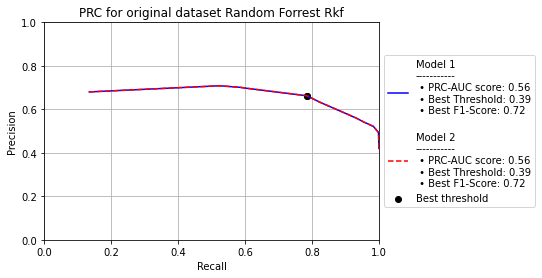

Best Threshold=0.385237, F1-Score=0.719 for model 1
Best Threshold=0.385861, F1-Score=0.719 for model 2


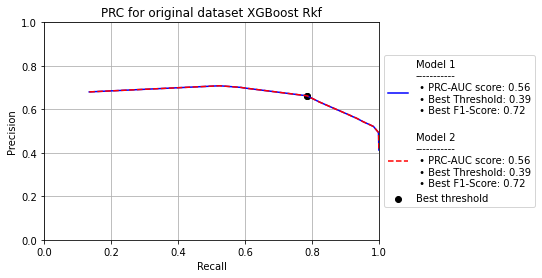

Best Threshold=0.330176, F1-Score=0.729 for model 1
Best Threshold=0.327441, F1-Score=0.524 for model 2


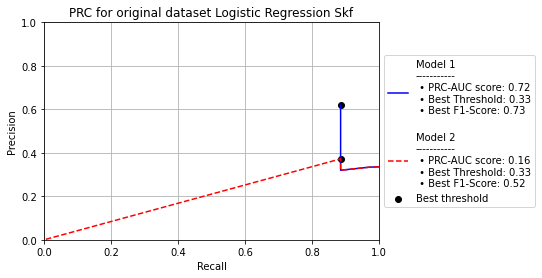

Best Threshold=1.000000, F1-Score=0.611 for model 1
Best Threshold=1.000000, F1-Score=0.611 for model 2


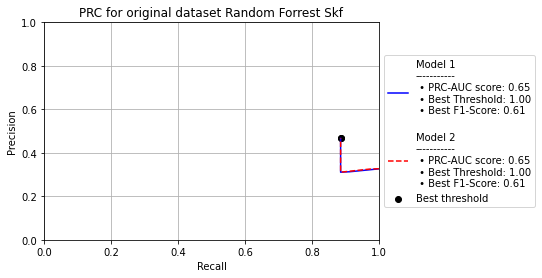

Best Threshold=0.999251, F1-Score=0.628 for model 1
Best Threshold=0.999808, F1-Score=0.628 for model 2


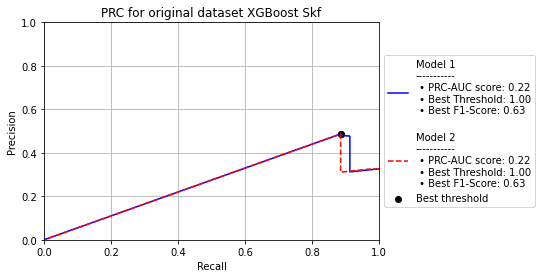

Best Threshold=0.232351, F1-Score=0.883 for model 1
Best Threshold=0.225444, F1-Score=0.883 for model 2


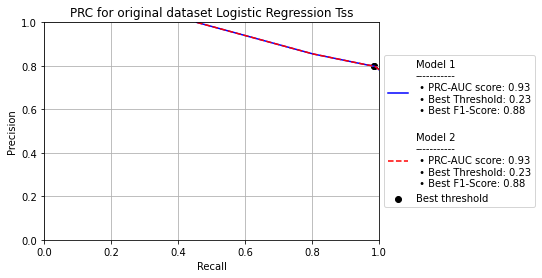

Best Threshold=0.000000, F1-Score=0.877 for model 1
Best Threshold=0.224325, F1-Score=0.883 for model 2


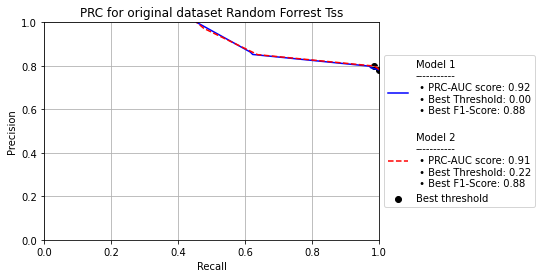

Best Threshold=0.000083, F1-Score=0.877 for model 1
Best Threshold=0.001651, F1-Score=0.879 for model 2


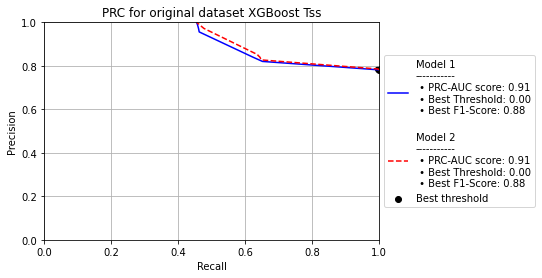

0    28370
1    13746
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.511886678918844
Average Precision-Recall Score: 0.3551001338661938
PRC-AUC for model 1: 0.29826714606807697
Accuracy: 0.670
MCC for model 1: 0.0
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      7054
           1       0.00      0.00      0.00      3475

    accuracy                           0.67     10529
   macro avg       0.33      0.50      0.40     10529
weighted avg       0.45      0.67      0.54     10529


Scores for model 2
------------------
Roc_Auc Score: 0.5812652650774192
Average Precision-Recall Score: 0.4972409861882082
PRC-AUC for model 2: 0.5470354743915135
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              p

TRAIN: [    0     1     3 ... 27489 27490 27491] | TEST: [    2    22    30 ... 27416 27422 27460]

Model Score: 0.48563113859585305

Average Precision-Recall Score: 0.514368861404147
PRC-AUC Score: 0.5603425596577768
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.49      1.00      0.65      1335
           1       0.00      0.00      0.00      1414

    accuracy                           0.49      2749
   macro avg       0.24      0.50      0.33      2749
weighted avg       0.24      0.49      0.32      2749

Accuracy: 0.486
MCC:  0.0
TRAIN: [    0     1     3 ... 27489 27490 27491] | TEST: [    2    22    30 ... 27416 27422 27460]

Model Score: 0.48563113859585305

Average Precision-Recall Score: 0.514368861404147
PRC-AUC Score: 0.7571844307020734
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.49      1.0

TRAIN: [    0     1     3 ... 27489 27490 27491] | TEST: [    2    22    30 ... 27416 27422 27460]

Model Score: 0.5078210258275737

Average Precision-Recall Score: 0.5214617038205136
PRC-AUC Score: 0.5279471262018335
Precision:  0.5370595382746051
Recall:  0.3125884016973126
F1:  0.3951721054984354
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.71      0.59      1335
           1       0.54      0.31      0.40      1414

    accuracy                           0.51      2749
   macro avg       0.52      0.51      0.49      2749
weighted avg       0.52      0.51      0.49      2749

Accuracy: 0.508
MCC:  0.0296775899319812
Row 27 model 2
TRAIN: [    0     1     3 ... 27489 27490 27491] | TEST: [    2    22    30 ... 27416 27422 27460]

Model Score: 0.5023644961804292

Average Precision-Recall Score: 0.5196489047566575
PRC-AUC Score: 0.5257468091243785
Precision:  0.5363924050632911
Recall:  0.23974540311173975
F1:  0.3313782


Scores for model 2
------------------
Roc_Auc Score: 0.8599595282015592
Average Precision-Recall Score: 0.797442823908513
PRC-AUC for model 2: 0.8143403335501203
Precision score for model 2:  0.7802375809935205
Recall score for model 2:  0.8127109111361079
F1 score for model 2:  0.7961432506887053
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      7073
           1       0.78      0.81      0.80      7112

    accuracy                           0.79     14185
   macro avg       0.79      0.79      0.79     14185
weighted avg       0.79      0.79      0.79     14185

Accuracy: 0.791
MCC for model 2: 0.58311485334624
-------------------------------
|Scores for XGBoost Classifier|
-------------------------------
Row 38 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.859976385984058
Average Precision-Recall Score: 0.797447034167715
PRC-AUC for model 1: 0.8143530744825518
Accuracy: 0.791
MCC for mo

TRAIN: [    0     2     3 ... 56736 56737 56738] | TEST: [    1    21    31 ... 56725 56730 56739]

Model Score: 0.788861473387381

Average Precision-Recall Score: 0.7282478056549461
PRC-AUC Score: 0.809032057116114
Precision:  0.7813027337158286
Recall:  0.8080279232111692
F1:  0.7944406314344543
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      2809
           1       0.78      0.81      0.79      2865

    accuracy                           0.79      5674
   macro avg       0.79      0.79      0.79      5674
weighted avg       0.79      0.79      0.79      5674

Accuracy: 0.789
MCC:  0.577882951778557
TRAIN: [    0     1     2 ... 53900 53901 53902] | TEST: [31048 31049 31050 ... 56737 56738 56739]

Model Score: 0.387381036305957

Average Precision-Recall Score: 0.45162125628395644
PRC-AUC Score: 0.4536823028536424
Precision:  0.42957901697156714
Recall:  0.6869933027846317
F1:  0.5286140493626256
Classifi

TRAIN: [    0     1     2 ... 53900 53901 53902] | TEST: [31048 31049 31050 ... 56737 56738 56739]

Model Score: 0.4841381741275996

Average Precision-Recall Score: 0.49220942960494374
PRC-AUC Score: 0.5952717548301704
Precision:  0.4911521824616595
Recall:  0.8805075784279168
F1:  0.6305692288274644
Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.09      0.15      2837
           1       0.49      0.88      0.63      2837

    accuracy                           0.48      5674
   macro avg       0.46      0.48      0.39      5674
weighted avg       0.46      0.48      0.39      5674

Accuracy: 0.484
MCC:  -0.05204340085891189
TRAIN: [    0     1     2 ... 53900 53901 53902] | TEST: [31048 31049 31050 ... 56737 56738 56739]

Model Score: 0.4841381741275996

Average Precision-Recall Score: 0.49220942960494374
PRC-AUC Score: 0.7503529827038475
Precision:  0.4911521824616595
Recall:  0.8805075784279168
F1:  0.6305692288274644
Cl

Average Precision-Recall Score: 0.5160781605735264
PRC-AUC for model 1: 0.42303902086623707
Accuracy: 0.501
MCC for model 1: 0.02222457083755179
Precision score for model 1:  0.5003526590492312
Recall score for model 1:  1.0
F1 score for model 1:  0.666980067694622
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      7091
           1       0.50      1.00      0.67      7094

    accuracy                           0.50     14185
   macro avg       0.75      0.50      0.33     14185
weighted avg       0.75      0.50      0.33     14185


Scores for model 2
------------------
Roc_Auc Score: 0.5715538210282319
Average Precision-Recall Score: 0.6400433061115665
PRC-AUC for model 2: 0.656753340620817
Precision score for model 2:  0.5006704778036559
Recall score for model 2:  1.0
F1 score for model 2:  0.6672623806612425
Classification Report:

              precision    recall  f1-score   support

           0       

TRAIN: [    0     1     2 ... 53900 53901 53902] | TEST: [25533 25534 25535 ... 56737 56738 56739]

Model Score: 0.3836799436023969

Average Precision-Recall Score: 0.44952016760176045
PRC-AUC Score: 0.43644838100817324
Precision:  0.4339735894357743
Recall:  0.7645400070497004
F1:  0.553669432035737
Classification Report:

              precision    recall  f1-score   support

           0       0.01      0.00      0.00      2837
           1       0.43      0.76      0.55      2837

    accuracy                           0.38      5674
   macro avg       0.22      0.38      0.28      5674
weighted avg       0.22      0.38      0.28      5674

Accuracy: 0.384
MCC:  -0.3590644936069258
Row 67 model 1
TRAIN: [    0     1     2 ... 53900 53901 53902] | TEST: [25533 25534 25535 ... 56737 56738 56739]

Model Score: 0.3836799436023969

Average Precision-Recall Score: 0.44952016760176045
PRC-AUC Score: 0.3831100113105341
Precision:  0.4339735894357743
Recall:  0.7645400070497004
F1:  0.55366

TRAIN: [    0     1     2 ... 53900 53901 53902] | TEST: [25533 25534 25535 ... 56737 56738 56739]

Model Score: 0.3836799436023969

Average Precision-Recall Score: 0.44952016760176045
PRC-AUC Score: 0.4130774525348657
Precision:  0.4339735894357743
Recall:  0.7645400070497004
F1:  0.553669432035737
Classification Report:

              precision    recall  f1-score   support

           0       0.01      0.00      0.00      2837
           1       0.43      0.76      0.55      2837

    accuracy                           0.38      5674
   macro avg       0.22      0.38      0.28      5674
weighted avg       0.22      0.38      0.28      5674

Accuracy: 0.384
MCC:  -0.3590644936069258

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    9456.0

    ac

In [91]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders

start = 0

if os.path.exists('out.csv'):
    final_result_df = pd.read_csv('out.csv', index_col=0)
    print(final_result_df)
    for index, row in final_result_df.iterrows():
        print()
        if math.isnan(row['XGB_precision_1']):
            break
        start += 1
else:
    final_result_df = pd.DataFrame({'XGB_precision_1':[None]*14, 
                                'XGB_precision_2':[None]*14,
                                'XGB_recall_1':[None]*14, 
                                'XGB_recall_2':[None]*14,
                                'XGB_f1_1':[None]*14, 
                                'XGB_f1_2':[None]*14,
                                'XGB_MCC_1':[None]*14,
                                'XGB_MCC_2':[None]*14,
                                'XGB_PRC_AUC_1':[None]*14,
                                'XGB_PRC_AUC_2':[None]*14,
                                'LR_precision_1':[None]*14, 
                                'LR_precision_2':[None]*14, 
                                'LR_recall_1':[None]*14, 
                                'LR_recall_2':[None]*14, 
                                'LR_f1_1':[None]*14, 
                                'LR_f1_2':[None]*14, 
                                'LR_MCC_1':[None]*14,
                                'LR_MCC_2':[None]*14,
                                'LR_PRC_AUC_1':[None]*14, 
                                'LR_PRC_AUC_2':[None]*14,
                                'RF_precision_1':[None]*14, 
                                'RF_precision_2':[None]*14,
                                'RF_recall_1':[None]*14, 
                                'RF_recall_2':[None]*14,
                                'RF_f1_1':[None]*14, 
                                'RF_f1_2':[None]*14,
                                'RF_MCC_1':[None]*14,
                                'RF_MCC_2':[None]*14,
                                'RF_PRC_AUC_1':[None]*14, 
                                'RF_PRC_AUC_2':[None]*14})

rankings = {'XGB':[], 'Logistic_Regression':[], 'Random_Forest':[]}

files = ['ActiveMQ', 'Ant', 'Camel', 'Derby', 'Geronimo', 'Hadoop', 'HBase', 'Ivy', 'JCR', 'JMeter', 'LOG4J2', 'Lucene', 'Mahout', 'OpenJPA']

for file_index in range(start, len(files)):
    if final_result_df.iloc[file_index]['XGB_precision_1'] is None:
        pass
    else:
        continue
    graph_df = pd.read_csv(f"../Neo4j_output/Jit_Reliability_Output/{files[file_index]}.csv")
    print(f"Performing analysis for: {files[file_index]}")
    print(graph_df.loc[graph_df['Bug'] == "INTRODUCED_NEW_BUG"])
    new_columns = {}

    # Generate binary classification for our dataframe based on if a developer 
    # introduced a bug or not with the corresponding commit
    for index in graph_df.index:
        if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
            graph_df.loc[index, "Bug"] = 0
        else:
            graph_df.loc[index, "Bug"] = 1

        # separate each node2vec embedding into it's own unique label
        embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
        for i, embedding in enumerate(embeddings):
            if f"emb_{i}" not in new_columns:
                new_columns[f"emb_{i}"] = []
                new_columns[f"emb_{i}"].append(embedding)
            else:
                new_columns[f"emb_{i}"].append(embedding)

    # delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
    del graph_df['n2vEmbedding']
    temp_df = pd.DataFrame.from_dict(new_columns)
    graph_df = graph_df.join(temp_df)
    
    # Normalize the dataframe
    subset = graph_df.select_dtypes('number')
    graph_df[subset.columns] = subset.div(subset.sum(axis=1), axis=0)
    #graph_df = graph_df[~graph_df.isin([np.nan, np.inf, -np.inf]).any(1)]
    print(graph_df)
    
    x = graph_df["Name"]
    y = graph_df["Bug"].astype('int')

    lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
    lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
    rf_model1 = RandomForestClassifier(n_estimators=120)
    rf_model2 = RandomForestClassifier(n_estimators=120)
    xgb_model1 = XGBClassifier(verbosity = 0)
    xgb_model2 = XGBClassifier(verbosity = 0)

    '''
    train_test_split params
    -----------------------
    graph_df: Graph dataset
    test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
    random_state = used to create reproducible, or deterministic results.
    '''
    try:
        train, test = train_test_split(graph_df, test_size=0.25, random_state = 5)
    except Exception as e:
        print(e)
        continue
    train = train.reset_index()
    test = test.reset_index()

    # Labels used for model 1
    labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

    # Labels used for model 2
    labels2 = set(list(graph_df.columns))
    labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

    x1_train = train[labels1]
    x2_train = train[labels2]
    y_train = train["Bug"]
    x1_test = test[labels1]
    x2_test = test[labels2]
    y_test = test["Bug"]
    y_train = y_train.astype('int')
    y_test = y_test.astype('int')

    lr_model1.fit(x1_train, y_train)
    lr_model2.fit(x2_train, y_train)
    rf_model1.fit(x1_train, y_train)
    rf_model2.fit(x2_train, y_train)
    xgb_model1.fit(x1_train, y_train)
    xgb_model2.fit(x2_train, y_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    results_data = [[None for j in range(17)] for i in range(72)]

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    print("Original_Logistic_Regression model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[0][0] = "Original_Logistic_Regression"
    results_data[0][1] = lr_model1.score(x1_test, y_test)
    results_data[0][2] = lr_model2.score(x2_test, y_test)
    results_data[0][3] = acc1
    results_data[0][4] = acc2
    results_data[0][5] = prc_val1
    results_data[0][6] = prc_val2
    results_data[0][7] = pr_auc1
    results_data[0][8] = pr_auc2
    results_data[0][9] = prec_1
    results_data[0][10] = prec_2
    results_data[0][11] = rec_1
    results_data[0][12] = rec_2
    results_data[0][13] = f1_1
    results_data[0][14] = f1_2
    results_data[0][15] = mcc1
    results_data[0][16] = mcc1

    print("Original_Random_Forrest model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[1][0] = "Original_Random_Forrest"
    results_data[1][1] = rf_model1.score(x1_test, y_test)
    results_data[1][2] = rf_model2.score(x2_test, y_test)
    results_data[1][3] = acc1
    results_data[1][4] = acc2
    results_data[1][5] = prc_val1
    results_data[1][6] = prc_val2
    results_data[1][7] = pr_auc1
    results_data[1][8] = pr_auc2
    results_data[1][9] = prec_1
    results_data[1][10] = prec_2
    results_data[1][11] = rec_1
    results_data[1][12] = rec_2
    results_data[1][13] = f1_1
    results_data[1][14] = f1_2
    results_data[1][15] = mcc1
    results_data[1][16] = mcc2

    print("Original_XGB model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[2][0] = "Original_XGB_Classifier"
    results_data[2][1] = xgb_model1.score(x1_test, y_test)
    results_data[2][2] = xgb_model2.score(x2_test, y_test)
    results_data[2][3] = acc1
    results_data[2][4] = acc2
    results_data[2][5] = prc_val1
    results_data[2][6] = prc_val2
    results_data[2][7] = pr_auc1
    results_data[2][8] = pr_auc2
    results_data[2][9] = prec_1
    results_data[2][10] = prec_2
    results_data[2][11] = rec_1
    results_data[2][12] = rec_2
    results_data[2][13] = f1_1
    results_data[2][14] = f1_2
    results_data[2][15] = mcc1
    results_data[2][16] = mcc2

    lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")
    rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")
    xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    print("Original_Logistic_Regression_Best_Threshold model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

    results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
    results_data[3][1] = lr_model1.score(x1_test, y_test)
    results_data[3][2] = lr_model2.score(x2_test, y_test)
    results_data[3][3] = acc1
    results_data[3][4] = acc2
    results_data[3][5] = prc_val1
    results_data[3][6] = prc_val2
    results_data[3][7] = pr_auc1
    results_data[3][8] = pr_auc2
    results_data[3][9] = prec_1
    results_data[3][10] = prec_2
    results_data[3][11] = rec_1
    results_data[3][12] = rec_2
    results_data[3][13] = f1_1
    results_data[3][14] = f1_2
    results_data[3][15] = mcc1
    results_data[3][16] = mcc2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    print("Original_Random_Forrest_Best_Threshold model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    
    results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
    results_data[4][1] = rf_model1.score(x1_test, y_test)
    results_data[4][2] = rf_model2.score(x2_test, y_test)
    results_data[4][3] = acc1
    results_data[4][4] = acc2
    results_data[4][5] = prc_val1
    results_data[4][6] = prc_val2
    results_data[4][7] = pr_auc1
    results_data[4][8] = pr_auc2
    results_data[4][9] = prec_1
    results_data[4][10] = prec_2
    results_data[4][11] = rec_1
    results_data[4][12] = rec_2
    results_data[4][13] = f1_1
    results_data[4][14] = f1_2
    results_data[4][15] = mcc1
    results_data[4][16] = mcc2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Original_XGBoost_Classifier_Best_Threshold model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    
    results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
    results_data[5][1] = xgb_model1.score(x1_test, y_test)
    results_data[5][2] = xgb_model2.score(x2_test, y_test)
    results_data[5][3] = acc1
    results_data[5][4] = acc2
    results_data[5][5] = prc_val1
    results_data[5][6] = prc_val2
    results_data[5][7] = pr_auc1
    results_data[5][8] = pr_auc2
    results_data[5][9] = prec_1
    results_data[5][10] = prec_2
    results_data[5][11] = rec_1
    results_data[5][12] = rec_2
    results_data[5][13] = f1_1
    results_data[5][14] = f1_2
    results_data[5][15] = mcc1
    results_data[5][16] = mcc2

    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df['Bug'].astype('int')

    print("Original_XGBoost_Classifier_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(lr_model1, x1, y)
    
    results_data[6][0] = "Original_Logistic_Regression_rkf"
    results_data[6][1] = model_score
    results_data[6][3] = acc
    results_data[6][5] = prc_val
    results_data[6][7] = pr_auc
    results_data[6][9] = precision
    results_data[6][11] = recall
    results_data[6][13] = f1
    results_data[6][15] = mcc
    print("---------------------")
    print("With best threshold")
    
    print("Original_Logistic_Regression_rkf_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1, mcc = Rkf(lr_model1, x1, y, lr_best_threshold1)
    results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
    results_data[7][1] = model_score
    results_data[7][3] = acc
    results_data[7][5] = prc_val
    results_data[7][7] = pr_auc
    results_data[7][9] = precision
    results_data[7][11] = recall
    results_data[7][13] = f1
    results_data[7][15] = mcc

    # Rkf_short(lr_model1, x1, y)
    print("Original_Random_Forrest_rkf model 1")
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(rf_model1, x1, y)
    results_data[8][0] = "Original_Random_Forrest_rkf"
    results_data[8][1] = model_score
    results_data[8][3] = acc
    results_data[8][5] = prc_val
    results_data[8][7] = pr_auc
    results_data[8][9] = precision
    results_data[8][11] = recall
    results_data[8][13] = f1
    results_data[8][15] = mcc

    print("Original_XGB_Classifier_rkf model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(xgb_model1, x1, y)
    results_data[9][0] = "Original_XGB_Classifier_rkf"
    results_data[9][1] = model_score
    results_data[9][3] = acc
    results_data[9][5] = prc_val
    results_data[9][7] = pr_auc
    results_data[9][9] = precision
    results_data[9][11] = recall
    results_data[9][13] = f1
    results_data[9][15] = mcc

    print("Original_Logistic_Regression_skf model 1")
    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1, mcc = Skf(lr_model1, x1, y)
    results_data[10][0] = "Original_Logistic_Regression_skf"
    results_data[10][1] = model_score
    results_data[10][3] = acc
    results_data[10][5] = prc_val
    results_data[10][7] = pr_auc
    results_data[10][9] = precision
    results_data[10][11] = recall
    results_data[10][13] = f1
    results_data[10][15] = mcc

    print("Original_Logistic_Regression_skf_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1, mcc = Skf(lr_model1, x1, y, lr_best_threshold1)
    results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
    results_data[11][1] = model_score
    results_data[11][3] = acc
    results_data[11][5] = prc_val
    results_data[11][7] = pr_auc
    results_data[11][9] = precision
    results_data[11][11] = recall
    results_data[11][13] = f1
    results_data[11][15] = mcc

    print("Original_Random_Forrest_skf model 1")
    # Skf_short(lr_model1, x1, y)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1, mcc = Skf(rf_model1, x1, y)
    results_data[12][0] = "Original_Random_Forrest_skf"
    results_data[12][1] = model_score
    results_data[12][3] = acc
    results_data[12][5] = prc_val
    results_data[12][7] = pr_auc
    results_data[12][9] = precision
    results_data[12][11] = recall
    results_data[12][13] = f1
    results_data[12][15] = mcc

    print("Original_XGB_Classifier_skf model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1, mcc = Skf(xgb_model1, x1, y)
    results_data[13][0] = "Original_XGB_Classifier_skf"
    results_data[13][1] = model_score
    results_data[13][3] = acc
    results_data[13][5] = prc_val
    results_data[13][7] = pr_auc
    results_data[13][9] = precision
    results_data[13][11] = recall
    results_data[13][13] = f1
    results_data[13][15] = mcc

    print("Original_Logistic_Regression_tss model 1")
    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1, mcc = Tss(lr_model1, x1, y)
    results_data[14][0] = "Original_Logistic_Regression_tss"
    results_data[14][1] = model_score
    results_data[14][3] = acc
    results_data[14][5] = prc_val
    results_data[14][7] = pr_auc
    results_data[14][9] = precision
    results_data[14][11] = recall
    results_data[14][13] = f1
    results_data[14][15] = mcc

    print("Original_Logistic_Regression_tss_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1, mcc = Tss(lr_model1, x1, y, lr_best_threshold1)
    results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
    results_data[15][1] = model_score
    results_data[15][3] = acc
    results_data[15][5] = prc_val
    results_data[15][7] = pr_auc
    results_data[15][9] = precision
    results_data[15][11] = recall
    results_data[15][13] = f1
    results_data[15][15] = mcc

    # Skf_short(lr_model1, x1, y)
    print("Original_Random_Forrest_tss model 1")
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1, mcc = Tss(rf_model1, x1, y)
    results_data[16][0] = "Original_Random_Forrest_tss"
    results_data[16][1] = model_score
    results_data[16][3] = acc
    results_data[16][5] = prc_val
    results_data[16][7] = pr_auc
    results_data[16][9] = precision
    results_data[16][11] = recall
    results_data[16][13] = f1
    results_data[16][15] = mcc

    print("Original_XGB_Classifier_tss model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1, mcc = Tss(xgb_model1, x1, y)
    results_data[17][0] = "Original_XGB_Classifier_tss"
    results_data[17][1] = model_score
    results_data[17][3] = acc
    results_data[17][5] = prc_val
    results_data[17][7] = pr_auc
    results_data[17][9] = precision
    results_data[17][11] = recall
    results_data[17][13] = f1
    results_data[17][15] = mcc

    # ---- Data for Model 2 ----
    print("Row 6 model 2")
    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(lr_model2, x2, y)
    results_data[6][2] = model_score
    results_data[6][4] = acc
    results_data[6][6] = prc_val
    results_data[6][8] = pr_auc
    results_data[6][10] = precision
    results_data[6][12] = recall
    results_data[6][14] = f1
    results_data[6][16] = mcc

    print("Row 7 model 2")
    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1, mcc = Rkf(lr_model2, x2, y, lr_best_threshold2)
    results_data[7][2] = model_score
    results_data[7][4] = acc
    results_data[7][6] = prc_val
    results_data[7][8] = pr_auc
    results_data[7][10] = precision
    results_data[7][12] = recall
    results_data[7][14] = f1
    results_data[7][16] = mcc

    # Rkf_short(lr_model2, x2, y)

    print("Row 8 model 2")
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(rf_model2, x2, y)
    results_data[8][2] = model_score
    results_data[8][4] = acc
    results_data[8][6] = prc_val
    results_data[8][8] = pr_auc
    results_data[8][10] = precision
    results_data[8][12] = recall
    results_data[8][14] = f1
    results_data[8][16] = mcc

    print("Row 9 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(xgb_model2, x2, y)
    results_data[9][2] = model_score
    results_data[9][4] = acc
    results_data[9][6] = prc_val
    results_data[9][8] = pr_auc
    results_data[9][10] = precision
    results_data[9][12] = recall
    results_data[9][14] = f1
    results_data[9][16] = mcc

    print("Row 10 model 2")
    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1, mcc = Skf(lr_model2, x2, y)
    results_data[10][2] = model_score
    results_data[10][4] = acc
    results_data[10][6] = prc_val
    results_data[10][8] = pr_auc
    results_data[10][10] = precision
    results_data[10][12] = recall
    results_data[10][14] = f1
    results_data[10][16] = mcc

    print("Row 11 model 2")
    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1, mcc = Skf(lr_model2, x2, y, lr_best_threshold2)
    results_data[11][2] = model_score
    results_data[11][4] = acc
    results_data[11][6] = prc_val
    results_data[11][8] = pr_auc
    results_data[11][10] = precision
    results_data[11][12] = recall
    results_data[11][14] = f1
    results_data[11][16] = mcc

    print("Row 12 model 2")
    # Skf_short(lr_model2, x2, y)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1, mcc = Skf(rf_model2, x2, y)
    results_data[12][2] = model_score
    results_data[12][4] = acc
    results_data[12][6] = prc_val
    results_data[12][8] = pr_auc
    results_data[12][10] = precision
    results_data[12][12] = recall
    results_data[12][14] = f1
    results_data[12][16] = mcc

    print("Row 13 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1, mcc = Skf(xgb_model2, x2, y)
    results_data[13][2] = model_score
    results_data[13][4] = acc
    results_data[13][6] = prc_val
    results_data[13][8] = pr_auc
    results_data[13][10] = precision
    results_data[13][12] = recall
    results_data[13][14] = f1
    results_data[13][16] = mcc

    print("Row 14 model 2")
    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1, mcc = Tss(lr_model2, x2, y)
    results_data[14][2] = model_score
    results_data[14][4] = acc
    results_data[14][6] = prc_val
    results_data[14][8] = pr_auc
    results_data[14][10] = precision
    results_data[14][12] = recall
    results_data[14][14] = f1
    results_data[14][16] = mcc

    print("Row 15 model 2")
    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1, mcc = Tss(lr_model2, x2, y, lr_best_threshold2)
    results_data[15][2] = model_score
    results_data[15][4] = acc
    results_data[15][6] = prc_val
    results_data[15][8] = pr_auc
    results_data[15][10] = precision
    results_data[15][12] = recall
    results_data[15][14] = f1
    results_data[15][16] = mcc

    print("Row 16 model 2")
    # Skf_short(lr_model2, x2, y)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1, mcc = Tss(rf_model2, x2, y)
    results_data[16][2] = model_score
    results_data[16][4] = acc
    results_data[16][6] = prc_val
    results_data[16][8] = pr_auc
    results_data[16][10] = precision
    results_data[16][12] = recall
    results_data[16][14] = f1
    results_data[16][16] = mcc

    print("Row 17 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1, mcc = Tss(xgb_model2, x2, y)
    results_data[17][2] = model_score
    results_data[17][4] = acc
    results_data[17][6] = prc_val
    results_data[17][8] = pr_auc
    results_data[17][10] = precision
    results_data[17][12] = recall
    results_data[17][14] = f1
    results_data[17][16] = mcc

    lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
    rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
    xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

    lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
    rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
    xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

    lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
    rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
    xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

    # Perform undersampling
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    
    bug_df = graph_df.loc[graph_df['Bug'] == 1]
    non_bug_df = graph_df.loc[graph_df['Bug'] == 0]
    normalized_under_df = pd.concat([bug_df, non_bug_df])
    normalized_under_df = normalized_under_df.reset_index()
    print(normalized_under_df['Bug'].value_counts())

    usx1 = normalized_under_df[labels1]
    usx2 = normalized_under_df[labels2]
    usy = normalized_under_df["Bug"].astype('int')
    usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset
    usy1 = usy
    usy2 = usy
    
    usx1, usy1 = rus.fit_resample(usx1, usy1)
    usx2, usy2 = rus.fit_resample(usx2, usy2)

    train, test = train_test_split(normalized_under_df, test_size=0.25, random_state = 5)

    labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
    labels2 = set(list(normalized_under_df.columns))
    labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

    x1_train = train[labels1]
    x2_train = train[labels2]
    y_train = train["Bug"].astype('int')
    x1_test = test[labels1]
    x2_test = test[labels2]
    y_test = test["Bug"].astype('int')

    lr_model1.fit(x1_train, y_train)
    lr_model2.fit(x2_train, y_train)
    rf_model1.fit(x1_train, y_train)
    rf_model2.fit(x2_train, y_train)
    xgb_model1.fit(x1_train, y_train)
    xgb_model2.fit(x2_train, y_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[18][0] = "Undersampled_Logistic_Regression"
    results_data[18][1] = lr_model1.score(x1_test, y_test)
    results_data[18][2] = lr_model2.score(x2_test, y_test)

    results_data[19][0] = "Undersampled_Random_Forrest"
    results_data[19][1] = rf_model1.score(x1_test, y_test)
    results_data[19][2] = rf_model2.score(x2_test, y_test)

    results_data[20][0] = "Undersampled_XGB_Classifier"
    results_data[20][1] = xgb_model1.score(x1_test, y_test)
    results_data[20][2] = xgb_model2.score(x2_test, y_test)

    print("Row 18 model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[18][3] = acc1
    results_data[18][4] = acc2
    results_data[18][5] = prc_val1
    results_data[18][6] = prc_val2
    results_data[18][7] = pr_auc1
    results_data[18][8] = pr_auc2
    results_data[18][9] = prec_1
    results_data[18][10] = prec_2
    results_data[18][11] = rec_1
    results_data[18][12] = rec_2
    results_data[18][13] = f1_1
    results_data[18][14] = f1_2
    results_data[18][15] = mcc1
    results_data[18][16] = mcc2

    print("Row 19 model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[19][3] = acc1
    results_data[19][4] = acc2
    results_data[19][5] = prc_val1
    results_data[19][6] = prc_val2
    results_data[19][7] = pr_auc1
    results_data[19][8] = pr_auc2
    results_data[19][9] = prec_1
    results_data[19][10] = prec_2
    results_data[19][11] = rec_1
    results_data[19][12] = rec_2
    results_data[19][13] = f1_1
    results_data[19][14] = f1_2
    results_data[19][15] = mcc1
    results_data[19][16] = mcc2

    print("Row 20 model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[20][3] = acc1
    results_data[20][4] = acc2
    results_data[20][5] = prc_val1
    results_data[20][6] = prc_val2
    results_data[20][7] = pr_auc1
    results_data[20][8] = pr_auc2
    results_data[20][9] = prec_1
    results_data[20][10] = prec_2
    results_data[20][11] = rec_1
    results_data[20][12] = rec_2
    results_data[20][13] = f1_1
    results_data[20][14] = f1_2
    results_data[20][15] = mcc1
    results_data[20][16] = mcc2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
    results_data[21][1] = lr_model1.score(x1_test, y_test)
    results_data[21][2] = lr_model2.score(x2_test, y_test)
    results_data[21][3] = acc1
    results_data[21][4] = acc2
    results_data[21][5] = prc_val1
    results_data[21][6] = prc_val2
    results_data[21][7] = pr_auc1
    results_data[21][8] = pr_auc2
    results_data[21][9] = prec_1
    results_data[21][10] = prec_2
    results_data[21][11] = rec_1
    results_data[21][12] = rec_2
    results_data[21][13] = f1_1
    results_data[21][14] = f1_2
    results_data[21][15] = mcc1
    results_data[21][16] = mcc2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
    results_data[22][1] = rf_model1.score(x1_test, y_test)
    results_data[22][2] = rf_model2.score(x2_test, y_test)
    results_data[22][3] = acc1
    results_data[22][4] = acc2
    results_data[22][5] = prc_val1
    results_data[22][6] = prc_val2
    results_data[22][7] = pr_auc1
    results_data[22][8] = pr_auc2
    results_data[22][9] = prec_1
    results_data[22][10] = prec_2
    results_data[22][11] = rec_1
    results_data[22][12] = rec_2
    results_data[22][13] = f1_1
    results_data[22][14] = f1_2
    results_data[22][15] = mcc1
    results_data[22][16] = mcc2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Row 23 model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
    results_data[23][1] = xgb_model1.score(x1_test, y_test)
    results_data[23][2] = xgb_model2.score(x2_test, y_test)
    results_data[23][3] = acc1
    results_data[23][4] = acc2
    results_data[23][5] = prc_val1
    results_data[23][6] = prc_val2
    results_data[23][7] = pr_auc1
    results_data[23][8] = pr_auc2
    results_data[23][9] = prec_1
    results_data[23][10] = prec_2
    results_data[23][11] = rec_1
    results_data[23][12] = rec_2
    results_data[23][13] = f1_1
    results_data[23][14] = f1_2
    results_data[23][15] = mcc1
    results_data[23][16] = mcc2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(lr_model1, usx1, usy1)
    results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
    results_data[24][1] = model_score
    results_data[24][3] = acc
    results_data[24][5] = prc_val
    results_data[24][7] = pr_auc
    results_data[24][9] = precision
    results_data[24][11] = recall
    results_data[24][13] = f1
    results_data[24][15] = mcc

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1, mcc = Rkf(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
    results_data[25][1] = model_score
    results_data[25][3] = acc
    results_data[25][5] = prc_val
    results_data[25][7] = pr_auc
    results_data[25][9] = precision
    results_data[25][11] = recall
    results_data[25][13] = f1
    results_data[25][15] = mcc

    #Rkf_short(lr_model1, usx1, usy)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(rf_model1, usx1, usy1)
    results_data[26][0] = "Undersampled_Random_Forrest_rkf"
    results_data[26][1] = model_score
    results_data[26][3] = acc
    results_data[26][5] = prc_val
    results_data[26][7] = pr_auc
    results_data[26][9] = precision
    results_data[26][11] = recall
    results_data[26][13] = f1
    results_data[26][15] = mcc

    print("Row 27 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(xgb_model1, usx1, usy1)
    results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
    results_data[27][1] = model_score
    results_data[27][3] = acc
    results_data[27][5] = prc_val
    results_data[27][7] = pr_auc
    results_data[27][9] = precision
    results_data[27][11] = recall
    results_data[27][13] = f1
    results_data[27][15] = mcc

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1, mcc = Skf(lr_model1, usx1, usy1)
    results_data[28][0] = "Undersampled_Logistic_Regression_skf"
    results_data[28][1] = model_score
    results_data[28][3] = acc
    results_data[28][5] = prc_val
    results_data[28][7] = pr_auc
    results_data[28][9] = precision
    results_data[28][11] = recall
    results_data[28][13] = f1
    results_data[28][15] = mcc

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1, mcc = Skf(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
    results_data[29][1] = model_score
    results_data[29][3] = acc
    results_data[29][5] = prc_val
    results_data[29][7] = pr_auc
    results_data[29][9] = precision
    results_data[29][11] = recall
    results_data[29][13] = f1
    results_data[29][15] = mcc

    # Skf_short(lr_model1, usx1, usy)

    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1, mcc = Skf(rf_model1, usx1, usy1)
    results_data[30][0] = "Undersampled_Random_Forrest_skf"
    results_data[30][1] = model_score
    results_data[30][3] = acc
    results_data[30][5] = prc_val
    results_data[30][7] = pr_auc
    results_data[30][9] = precision
    results_data[30][11] = recall
    results_data[30][13] = f1
    results_data[30][15] = mcc

    print("Row 31 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1, mcc = Skf(xgb_model1, usx1, usy1)
    results_data[31][0] = "Undersampled_XGB_Classifier_skf"
    results_data[31][1] = model_score
    results_data[31][3] = acc
    results_data[31][5] = prc_val
    results_data[31][7] = pr_auc
    results_data[31][9] = precision
    results_data[31][11] = recall
    results_data[31][13] = f1
    results_data[31][15] = mcc

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1, mcc = Tss(lr_model1, usx1, usy1)
    results_data[32][0] = "Undersampled_Logistic_Regression_tss"
    results_data[32][1] = model_score
    results_data[32][3] = acc
    results_data[32][5] = prc_val
    results_data[32][7] = pr_auc
    results_data[32][9] = precision
    results_data[32][11] = recall
    results_data[32][13] = f1
    results_data[32][15] = mcc

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1, mcc = Tss(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
    results_data[33][1] = model_score
    results_data[33][3] = acc
    results_data[33][5] = prc_val
    results_data[33][7] = pr_auc
    results_data[33][9] = precision
    results_data[33][11] = recall
    results_data[33][13] = f1
    results_data[33][15] = mcc

    # Skf_short(lr_model1, usx1, usy)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1, mcc = Tss(rf_model1, usx1, usy1)
    results_data[34][0] = "Undersampled_Random_Forrest_tss"
    results_data[34][1] = model_score
    results_data[34][3] = acc
    results_data[34][5] = prc_val
    results_data[34][7] = pr_auc
    results_data[34][9] = precision
    results_data[34][11] = recall
    results_data[34][13] = f1
    results_data[34][15] = mcc

    print("Row 35 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1, mcc = Tss(xgb_model1, usx1, usy1)
    results_data[35][0] = "Undersampled_XGB_Classifier_tss"
    results_data[35][1] = model_score
    results_data[35][3] = acc
    results_data[35][5] = prc_val
    results_data[35][7] = pr_auc
    results_data[35][9] = precision
    results_data[35][11] = recall
    results_data[35][13] = f1
    results_data[35][15] = mcc

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(lr_model2, usx2, usy2)
    results_data[24][2] = model_score
    results_data[24][4] = acc
    results_data[24][6] = prc_val
    results_data[24][8] = pr_auc
    results_data[24][10] = precision
    results_data[24][12] = recall
    results_data[24][14] = f1
    results_data[24][16] = mcc

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1, mcc = Rkf(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[25][2] = model_score
    results_data[25][4] = acc
    results_data[25][6] = prc_val
    results_data[25][8] = pr_auc
    results_data[25][10] = precision
    results_data[25][12] = recall
    results_data[25][14] = f1
    results_data[25][16] = mcc

    # Rkf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(rf_model2, usx2, usy2)
    results_data[26][2] = model_score
    results_data[26][4] = acc
    results_data[26][6] = prc_val
    results_data[26][8] = pr_auc
    results_data[26][10] = precision
    results_data[26][12] = recall
    results_data[26][14] = f1
    results_data[26][16] = mcc

    print("Row 27 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(xgb_model2, usx2, usy2)
    results_data[27][2] = model_score
    results_data[27][4] = acc
    results_data[27][6] = prc_val
    results_data[27][8] = pr_auc
    results_data[27][10] = precision
    results_data[27][12] = recall
    results_data[27][14] = f1
    results_data[27][16] = mcc

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1, mcc = Skf(lr_model2, usx2, usy2)
    results_data[28][2] = model_score
    results_data[28][4] = acc
    results_data[28][6] = prc_val
    results_data[28][8] = pr_auc
    results_data[28][10] = precision
    results_data[28][12] = recall
    results_data[28][14] = f1
    results_data[28][16] = mcc

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1, mcc = Skf(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[29][2] = model_score
    results_data[29][4] = acc
    results_data[29][6] = prc_val
    results_data[29][8] = pr_auc
    results_data[29][10] = precision
    results_data[29][12] = recall
    results_data[29][14] = f1
    results_data[29][16] = mcc

    # Skf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1, mcc = Skf(rf_model2, usx2, usy2)
    results_data[30][2] = model_score
    results_data[30][4] = acc
    results_data[30][6] = prc_val
    results_data[30][8] = pr_auc
    results_data[30][10] = precision
    results_data[30][12] = recall
    results_data[30][14] = f1
    results_data[30][16] = mcc

    print("Row 31 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1, mcc = Skf(xgb_model2, usx2, usy2)
    results_data[31][2] = model_score
    results_data[31][4] = acc
    results_data[31][6] = prc_val
    results_data[31][8] = pr_auc
    results_data[31][10] = precision
    results_data[31][12] = recall
    results_data[31][14] = f1
    results_data[31][16] = mcc

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1, mcc = Tss(lr_model2, usx2, usy)
    results_data[32][2] = model_score
    results_data[32][4] = acc
    results_data[32][6] = prc_val
    results_data[32][8] = pr_auc
    results_data[32][10] = precision
    results_data[32][12] = recall
    results_data[32][14] = f1
    results_data[32][16] = mcc

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1, mcc = Tss(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[33][2] = model_score
    results_data[33][4] = acc
    results_data[33][6] = prc_val
    results_data[33][8] = pr_auc
    results_data[33][10] = precision
    results_data[33][12] = recall
    results_data[33][14] = f1
    results_data[33][16] = mcc

    # Skf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1, mcc = Tss(rf_model2, usx2, usy2)
    results_data[34][2] = model_score
    results_data[34][4] = acc
    results_data[34][6] = prc_val
    results_data[34][8] = pr_auc
    results_data[34][10] = precision
    results_data[34][12] = recall
    results_data[34][14] = f1
    results_data[34][16] = mcc

    print("Row 35 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1, mcc = Tss(xgb_model2, usx2, usy2)
    results_data[35][2] = model_score
    results_data[35][4] = acc
    results_data[35][6] = prc_val
    results_data[35][8] = pr_auc
    results_data[35][10] = precision
    results_data[35][12] = recall
    results_data[35][14] = f1
    results_data[35][16] = mcc

    # Oversampling
    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df["Bug"].astype('int')
    # For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)
    # Resample the minority class. You can change the strategy to 'auto' if you are not sure.
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    # Fit the model to generate the data for Model 1.
    oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

    # Fit the model to generate the data for Model 2.
    oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

    osx1 = oversampled_X1
    osx2 = oversampled_X2
    osy1 = oversampled_Y1
    osy2 = oversampled_Y2

    x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.25, random_state = 5)
    #x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
    x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.25, random_state = 5)
    #x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
    lr_model1.fit(x1_train, y1_train)
    lr_model2.fit(x2_train, y2_train)
    rf_model1.fit(x1_train, y1_train)
    rf_model2.fit(x2_train, y2_train)
    xgb_model1.fit(x1_train, y1_train)
    xgb_model2.fit(x2_train, y2_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[36][0] = "Oversampled_Logistic_Regression"
    results_data[36][1] = lr_model1.score(x1_test, y1_test)
    results_data[36][2] = lr_model2.score(x2_test, y2_test)

    results_data[37][0] = "Oversampled_Random_Forrest"
    results_data[37][1] = rf_model1.score(x1_test, y1_test)
    results_data[37][2] = rf_model2.score(x2_test, y2_test)

    results_data[38][0] = "Oversampled_XGB_Classifier"
    results_data[38][1] = xgb_model1.score(x1_test, y1_test)
    results_data[38][2] = xgb_model2.score(x2_test, y2_test)

    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[36][3] = acc1
    results_data[36][4] = acc2
    results_data[36][5] = prc_val1
    results_data[36][6] = prc_val2
    results_data[36][7] = pr_auc1
    results_data[36][8] = pr_auc2
    results_data[36][9] = prec_1
    results_data[36][10] = prec_2
    results_data[36][11] = rec_1
    results_data[36][12] = rec_2
    results_data[36][13] = f1_1
    results_data[36][14] = f1_2
    results_data[36][15] = mcc1
    results_data[36][16] = mcc2

    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[37][3] = acc1
    results_data[37][4] = acc2
    results_data[37][5] = prc_val1
    results_data[37][6] = prc_val2
    results_data[37][7] = pr_auc1
    results_data[37][8] = pr_auc2
    results_data[37][9] = prec_1
    results_data[37][10] = prec_2
    results_data[37][11] = rec_1
    results_data[37][12] = rec_2
    results_data[37][13] = f1_1
    results_data[37][14] = f1_2
    results_data[37][15] = mcc1
    results_data[37][16] = mcc2

    print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
    print("Row 38 model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[38][3] = acc1
    results_data[38][4] = acc2
    results_data[38][5] = prc_val1
    results_data[38][6] = prc_val2
    results_data[38][7] = pr_auc1
    results_data[38][8] = pr_auc2
    results_data[38][9] = prec_1
    results_data[38][10] = prec_2
    results_data[38][11] = rec_1
    results_data[38][12] = rec_2
    results_data[38][13] = f1_1
    results_data[38][14] = f1_2
    results_data[38][15] = mcc1
    results_data[38][16] = mcc2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[39][1] = lr_model1.score(x1_test, y1_test)
    results_data[39][2] = lr_model2.score(x2_test, y2_test)
    results_data[39][3] = acc1
    results_data[39][4] = acc2
    results_data[39][5] = prc_val1
    results_data[39][6] = prc_val2
    results_data[39][7] = pr_auc1
    results_data[39][8] = pr_auc2
    results_data[39][9] = prec_1
    results_data[39][10] = prec_2
    results_data[39][11] = rec_1
    results_data[39][12] = rec_2
    results_data[39][13] = f1_1
    results_data[39][14] = f1_2
    results_data[39][15] = mcc1
    results_data[39][16] = mcc2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[40][1] = rf_model1.score(x1_test, y1_test)
    results_data[40][2] = rf_model2.score(x2_test, y2_test)
    results_data[40][3] = acc1
    results_data[40][4] = acc2
    results_data[40][5] = prc_val1
    results_data[40][6] = prc_val2
    results_data[40][7] = pr_auc1
    results_data[40][8] = pr_auc2
    results_data[40][9] = prec_1
    results_data[40][10] = prec_2
    results_data[40][11] = rec_1
    results_data[40][12] = rec_2
    results_data[40][13] = f1_1
    results_data[40][14] = f1_2
    results_data[40][15] = mcc1
    results_data[40][16] = mcc2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[41][1] = xgb_model1.score(x1_test, y1_test)
    results_data[41][2] = xgb_model2.score(x2_test, y2_test)
    results_data[41][3] = acc1
    results_data[41][4] = acc2
    results_data[41][5] = prc_val1
    results_data[41][6] = prc_val2
    results_data[41][7] = pr_auc1
    results_data[41][8] = pr_auc2
    results_data[41][9] = prec_1
    results_data[41][10] = prec_2
    results_data[41][11] = rec_1
    results_data[41][12] = rec_2
    results_data[41][13] = f1_1
    results_data[41][14] = f1_2
    results_data[41][15] = mcc1
    results_data[41][16] = mcc2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(lr_model1, osx1, osy1)
    results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
    results_data[42][1] = model_score
    results_data[42][3] = acc
    results_data[42][5] = prc_val
    results_data[42][7] = pr_auc
    results_data[42][9] = precision
    results_data[42][11] = recall
    results_data[42][13] = f1
    results_data[42][15] = mcc

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1, mcc = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
    results_data[43][1] = model_score
    results_data[43][3] = acc
    results_data[43][5] = prc_val
    results_data[43][7] = pr_auc
    results_data[43][9] = precision
    results_data[43][11] = recall
    results_data[43][13] = f1
    results_data[43][15] = mcc

    # Rkf_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(rf_model1, osx1, osy1)
    results_data[44][0] = "Oversampled_Random_Forrest_rkf"
    results_data[44][1] = model_score
    results_data[44][3] = acc
    results_data[44][5] = prc_val
    results_data[44][7] = pr_auc
    results_data[44][9] = precision
    results_data[44][11] = recall
    results_data[44][13] = f1
    results_data[44][15] = mcc

    print("Row 45 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(xgb_model1, osx1, osy1)
    results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
    results_data[45][1] = model_score
    results_data[45][3] = acc
    results_data[45][5] = prc_val
    results_data[45][7] = pr_auc
    results_data[45][9] = precision
    results_data[45][11] = recall
    results_data[45][13] = f1
    results_data[45][15] = mcc

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1, mcc = Skf(lr_model1, osx1, osy1)
    results_data[46][0] = "Oversampled_Logistic_Regression_skf"
    results_data[46][1] = model_score
    results_data[46][3] = acc
    results_data[46][5] = prc_val
    results_data[46][7] = pr_auc
    results_data[46][9] = precision
    results_data[46][11] = recall
    results_data[46][13] = f1
    results_data[46][15] = mcc

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1, mcc = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
    results_data[47][1] = model_score
    results_data[47][3] = acc
    results_data[47][5] = prc_val
    results_data[47][7] = pr_auc
    results_data[47][9] = precision
    results_data[47][11] = recall
    results_data[47][13] = f1
    results_data[47][15] = mcc

    # Skf_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1, mcc = Skf(rf_model1, osx1, osy1)
    results_data[48][0] = "Oversampled_Random_Forrest_skf"
    results_data[48][1] = model_score
    results_data[48][3] = acc
    results_data[48][5] = prc_val
    results_data[48][7] = pr_auc
    results_data[48][9] = precision
    results_data[48][11] = recall
    results_data[48][13] = f1
    results_data[48][15] = mcc

    print("Row 49 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1, mcc = Skf(xgb_model1, osx1, osy1)
    results_data[49][0] = "Oversampled_XGB_Classifier_skf"
    results_data[49][1] = model_score
    results_data[49][3] = acc
    results_data[49][5] = prc_val
    results_data[49][7] = pr_auc
    results_data[49][9] = precision
    results_data[49][11] = recall
    results_data[49][13] = f1
    results_data[49][15] = mcc

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1, mcc = Tss(lr_model1, osx1, osy1)
    results_data[50][0] = "Oversampled_Logistic_Regression_tss"
    results_data[50][1] = model_score
    results_data[50][3] = acc
    results_data[50][5] = prc_val
    results_data[50][7] = pr_auc
    results_data[50][9] = precision
    results_data[50][11] = recall
    results_data[50][13] = f1
    results_data[50][15] = mcc

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1, mcc = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
    results_data[51][1] = model_score
    results_data[51][3] = acc
    results_data[51][5] = prc_val
    results_data[51][7] = pr_auc
    results_data[51][9] = precision
    results_data[51][11] = recall
    results_data[51][13] = f1
    results_data[51][15] = mcc

    # Tss_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1, mcc = Tss(rf_model1, osx1, osy1)
    results_data[52][0] = "Oversampled_Random_Forrest_tss"
    results_data[52][1] = model_score
    results_data[52][3] = acc
    results_data[52][5] = prc_val
    results_data[52][7] = pr_auc
    results_data[52][9] = precision
    results_data[52][11] = recall
    results_data[52][13] = f1
    results_data[52][15] = mcc

    print("Row 53 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1, mcc = Tss(xgb_model1, osx1, osy1)
    results_data[53][0] = "Oversampled_XGB_Classifier_tss"
    results_data[53][1] = model_score
    results_data[53][3] = acc
    results_data[53][5] = prc_val
    results_data[53][7] = pr_auc
    results_data[53][9] = precision
    results_data[53][11] = recall
    results_data[53][13] = f1
    results_data[53][15] = mcc

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(lr_model2, osx2, osy2)
    results_data[42][2] = model_score
    results_data[42][4] = acc
    results_data[42][6] = prc_val
    results_data[42][8] = pr_auc
    results_data[42][10] = precision
    results_data[42][12] = recall
    results_data[42][14] = f1
    results_data[42][16] = mcc

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1, mcc = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[43][2] = model_score
    results_data[43][4] = acc
    results_data[43][6] = prc_val
    results_data[43][8] = pr_auc
    results_data[43][10] = precision
    results_data[43][12] = recall
    results_data[43][14] = f1
    results_data[43][16] = mcc

    # Rkf_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(rf_model2, osx2, osy2)
    results_data[44][2] = model_score
    results_data[44][4] = acc
    results_data[44][6] = prc_val
    results_data[44][8] = pr_auc
    results_data[44][10] = precision
    results_data[44][12] = recall
    results_data[44][14] = f1
    results_data[44][16] = mcc

    print("Row 45 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(xgb_model2, osx2, osy2)
    results_data[45][2] = model_score
    results_data[45][4] = acc
    results_data[45][6] = prc_val
    results_data[45][8] = pr_auc
    results_data[45][10] = precision
    results_data[45][12] = recall
    results_data[45][14] = f1
    results_data[45][16] = mcc

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1, mcc = Skf(lr_model2, osx2, osy2)
    results_data[46][2] = model_score
    results_data[46][4] = acc
    results_data[46][6] = prc_val
    results_data[46][8] = pr_auc
    results_data[46][10] = precision
    results_data[46][12] = recall
    results_data[46][14] = f1
    results_data[46][16] = mcc

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1, mcc = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[47][2] = model_score
    results_data[47][4] = acc
    results_data[47][6] = prc_val
    results_data[47][8] = pr_auc
    results_data[47][10] = precision
    results_data[47][12] = recall
    results_data[47][14] = f1
    results_data[47][16] = mcc

    # Skf_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1, mcc = Skf(rf_model2, osx2, osy2)
    results_data[48][2] = model_score
    results_data[48][4] = acc
    results_data[48][6] = prc_val
    results_data[48][8] = pr_auc
    results_data[48][10] = precision
    results_data[48][12] = recall
    results_data[48][14] = f1
    results_data[48][16] = mcc

    print("Row 49 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1, mcc = Skf(xgb_model1, osx1, osy1)
    results_data[49][2] = model_score
    results_data[49][4] = acc
    results_data[49][6] = prc_val
    results_data[49][8] = pr_auc
    results_data[49][10] = precision
    results_data[49][12] = recall
    results_data[49][14] = f1
    results_data[49][16] = mcc

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1, mcc = Tss(lr_model2, osx2, osy2)
    results_data[50][2] = model_score
    results_data[50][4] = acc
    results_data[50][6] = prc_val
    results_data[50][8] = pr_auc
    results_data[50][10] = precision
    results_data[50][12] = recall
    results_data[50][14] = f1
    results_data[50][16] = mcc

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1, mcc = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[51][2] = model_score
    results_data[51][4] = acc
    results_data[51][6] = prc_val
    results_data[51][8] = pr_auc
    results_data[51][10] = precision
    results_data[51][12] = recall
    results_data[51][14] = f1
    results_data[51][16] = mcc

    # Tss_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1, mcc = Tss(rf_model2, osx2, osy2)
    results_data[52][2] = model_score
    results_data[52][4] = acc
    results_data[52][6] = prc_val
    results_data[52][8] = pr_auc
    results_data[52][10] = precision
    results_data[52][12] = recall
    results_data[52][14] = f1
    results_data[52][16] = mcc

    print("Row 53 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1, mcc = Tss(xgb_model2, osx2, osy2)
    results_data[53][2] = model_score
    results_data[53][4] = acc
    results_data[53][6] = prc_val
    results_data[53][8] = pr_auc
    results_data[53][10] = precision
    results_data[53][12] = recall
    results_data[53][14] = f1
    results_data[53][16] = mcc

    # OSUS
    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df["Bug"].astype('int')

    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    # Fit the model to generate the data for Model 1.
    oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

    # Fit the model to generate the data for Model 2.
    oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

    osx1 = oversampled_X1
    osx2 = oversampled_X2
    osy1 = oversampled_Y1
    osy2 = oversampled_Y2

    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

    balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
    balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)
    
    x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.25, random_state = 5)
    #x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
    x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.25, random_state = 5)
    #x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
    lr_model1.fit(x1_train, y1_train)
    lr_model2.fit(x2_train, y2_train)
    rf_model1.fit(x1_train, y1_train)
    rf_model2.fit(x2_train, y2_train)
    xgb_model1.fit(x1_train, y1_train)
    xgb_model2.fit(x2_train, y2_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[54][0] = "OSUS_Combination_Logistic_Regression"
    results_data[54][1] = lr_model1.score(x1_test, y1_test)
    results_data[54][2] = lr_model2.score(x2_test, y2_test)

    results_data[55][0] = "OSUS_Combination_Random_Forrest"
    results_data[55][1] = rf_model1.score(x1_test, y1_test)
    results_data[55][2] = rf_model2.score(x2_test, y2_test)

    results_data[56][0] = "OSUS_Combination_XGB_Classifier"
    results_data[56][1] = xgb_model1.score(x1_test, y1_test)
    results_data[56][2] = xgb_model2.score(x2_test, y2_test)

    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[54][3] = acc1
    results_data[54][4] = acc2
    results_data[54][5] = prc_val1
    results_data[54][6] = prc_val2
    results_data[54][7] = pr_auc1
    results_data[54][8] = pr_auc2
    results_data[54][9] = prec_1
    results_data[54][10] = prec_2
    results_data[54][11] = rec_1
    results_data[54][12] = rec_2
    results_data[54][13] = f1_1
    results_data[54][14] = f1_2
    results_data[54][15] = mcc1
    results_data[54][16] = mcc2

    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[55][3] = acc1
    results_data[55][4] = acc2
    results_data[55][5] = prc_val1
    results_data[55][6] = prc_val2
    results_data[55][7] = pr_auc1
    results_data[55][8] = pr_auc2
    results_data[55][9] = prec_1
    results_data[55][10] = prec_2
    results_data[55][11] = rec_1
    results_data[55][12] = rec_2
    results_data[55][13] = f1_1
    results_data[55][14] = f1_2
    results_data[55][15] = mcc1
    results_data[55][16] = mcc2

    print("Row 56 model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[56][3] = acc1
    results_data[56][4] = acc2
    results_data[56][5] = prc_val1
    results_data[56][6] = prc_val2
    results_data[56][7] = pr_auc1
    results_data[56][8] = pr_auc2
    results_data[56][9] = prec_1
    results_data[56][10] = prec_2
    results_data[56][11] = rec_1
    results_data[56][12] = rec_2
    results_data[56][13] = f1_1
    results_data[56][14] = f1_2
    results_data[56][15] = mcc1
    results_data[56][16] = mcc2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
    results_data[57][1] = lr_model1.score(x1_test, y1_test)
    results_data[57][2] = lr_model2.score(x2_test, y2_test)
    results_data[57][3] = acc1
    results_data[57][4] = acc2
    results_data[57][5] = prc_val1
    results_data[57][6] = prc_val2
    results_data[57][7] = pr_auc1
    results_data[57][8] = pr_auc2
    results_data[57][9] = prec_1
    results_data[57][10] = prec_2
    results_data[57][11] = rec_1
    results_data[57][12] = rec_2
    results_data[57][13] = f1_1
    results_data[57][14] = f1_2
    results_data[57][15] = mcc1
    results_data[57][16] = mcc2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
    results_data[58][1] = rf_model1.score(x1_test, y1_test)
    results_data[58][2] = rf_model2.score(x2_test, y2_test)
    results_data[58][3] = acc1
    results_data[58][4] = acc2
    results_data[58][5] = prc_val1
    results_data[58][6] = prc_val2
    results_data[58][7] = pr_auc1
    results_data[58][8] = pr_auc2
    results_data[58][9] = prec_1
    results_data[58][10] = prec_2
    results_data[58][11] = rec_1
    results_data[58][12] = rec_2
    results_data[58][13] = f1_1
    results_data[58][14] = f1_2
    results_data[58][15] = mcc1
    results_data[58][16] = mcc2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Row 59 model 1")
    acc1, acc2, mcc1, mcc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
    results_data[59][1] = xgb_model1.score(x1_test, y1_test)
    results_data[59][2] = xgb_model2.score(x2_test, y2_test)
    results_data[59][3] = acc1
    results_data[59][4] = acc2
    results_data[59][5] = prc_val1
    results_data[59][6] = prc_val2
    results_data[59][7] = pr_auc1
    results_data[59][8] = pr_auc2
    results_data[59][9] = prec_1
    results_data[59][10] = prec_2
    results_data[59][11] = rec_1
    results_data[59][12] = rec_2
    results_data[59][13] = f1_1
    results_data[59][14] = f1_2
    results_data[59][15] = mcc1
    results_data[59][16] = mcc2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(lr_model1, balanced_x1, balanced_y1)
    results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
    results_data[60][1] = model_score
    results_data[60][3] = acc
    results_data[60][5] = prc_val
    results_data[60][7] = pr_auc
    results_data[60][9] = precision
    results_data[60][11] = recall
    results_data[60][13] = f1
    results_data[60][15] = mcc

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1, mcc = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
    results_data[61][1] = model_score
    results_data[61][3] = acc
    results_data[61][5] = prc_val
    results_data[61][7] = pr_auc
    results_data[61][9] = precision
    results_data[61][11] = recall
    results_data[61][13] = f1
    results_data[61][15] = mcc

    # Rkf_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(rf_model1, balanced_x1, balanced_y1)
    results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
    results_data[62][1] = model_score
    results_data[62][3] = acc
    results_data[62][5] = prc_val
    results_data[62][7] = pr_auc
    results_data[62][9] = precision
    results_data[62][11] = recall
    results_data[62][13] = f1
    results_data[62][15] = mcc

    print("Row 63 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1, mcc = Rkf(xgb_model1, balanced_x1, balanced_y1)
    results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
    results_data[63][1] = model_score
    results_data[63][3] = acc
    results_data[63][5] = prc_val
    results_data[63][7] = pr_auc
    results_data[63][9] = precision
    results_data[63][11] = recall
    results_data[63][13] = f1
    results_data[63][15] = mcc

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1, mcc = Skf(lr_model1, balanced_x1, balanced_y1)
    results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
    results_data[64][1] = model_score
    results_data[64][3] = acc
    results_data[64][5] = prc_val
    results_data[64][7] = pr_auc
    results_data[64][9] = precision
    results_data[64][11] = recall
    results_data[64][13] = f1
    results_data[64][15] = mcc

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1, mcc = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
    results_data[65][1] = model_score
    results_data[65][3] = acc
    results_data[65][5] = prc_val
    results_data[65][7] = pr_auc
    results_data[65][9] = precision
    results_data[65][11] = recall
    results_data[65][13] = f1
    results_data[65][15] = mcc

    # Skf_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1, mcc = Skf(rf_model1, balanced_x1, balanced_y1)
    results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
    results_data[66][1] = model_score
    results_data[66][3] = acc
    results_data[66][5] = prc_val
    results_data[66][7] = pr_auc
    results_data[66][9] = precision
    results_data[66][11] = recall
    results_data[66][13] = f1
    results_data[66][15] = mcc

    print("Row 67 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1, mcc = Skf(xgb_model1, balanced_x1, balanced_y1)
    results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
    results_data[67][1] = model_score
    results_data[67][3] = acc
    results_data[67][5] = prc_val
    results_data[67][7] = pr_auc
    results_data[67][9] = precision
    results_data[67][11] = recall
    results_data[67][13] = f1
    results_data[67][15] = mcc

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1, mcc = Tss(lr_model1, balanced_x1, balanced_y1)
    results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
    results_data[68][1] = model_score
    results_data[68][3] = acc
    results_data[68][5] = prc_val
    results_data[68][7] = pr_auc
    results_data[68][9] = precision
    results_data[68][11] = recall
    results_data[68][13] = f1
    results_data[68][15] = mcc

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1, mcc = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
    results_data[69][1] = model_score
    results_data[69][3] = acc
    results_data[69][5] = prc_val
    results_data[69][7] = pr_auc
    results_data[69][9] = precision
    results_data[69][11] = recall
    results_data[69][13] = f1
    results_data[69][15] = mcc

    # Tss_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1, mcc = Skf(rf_model1, balanced_x1, balanced_y1)
    results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
    results_data[70][1] = model_score
    results_data[70][3] = acc
    results_data[70][5] = prc_val
    results_data[70][7] = pr_auc
    results_data[70][9] = precision
    results_data[70][11] = recall
    results_data[70][13] = f1
    results_data[70][15] = mcc

    print("Row 71 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1, mcc = Tss(xgb_model1, balanced_x1, balanced_y1)
    results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
    results_data[71][1] = model_score
    results_data[71][3] = acc
    results_data[71][5] = prc_val
    results_data[71][7] = pr_auc
    results_data[71][9] = precision
    results_data[71][11] = recall
    results_data[71][13] = f1
    results_data[71][15] = mcc

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(lr_model2, balanced_x2, balanced_y2)
    results_data[60][2] = model_score
    results_data[60][4] = acc
    results_data[60][6] = prc_val
    results_data[60][8] = pr_auc
    results_data[60][10] = precision
    results_data[60][12] = recall
    results_data[60][14] = f1
    results_data[60][16] = mcc

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1, mcc = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[61][2] = model_score
    results_data[61][4] = acc
    results_data[61][6] = prc_val
    results_data[61][8] = pr_auc
    results_data[61][10] = precision
    results_data[61][12] = recall
    results_data[61][14] = f1
    results_data[61][16] = mcc

    # Rkf_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(rf_model2, balanced_x2, balanced_y2)
    results_data[62][2] = model_score
    results_data[62][4] = acc
    results_data[62][6] = prc_val
    results_data[62][8] = pr_auc
    results_data[62][10] = precision
    results_data[62][12] = recall
    results_data[62][14] = f1
    results_data[62][16] = mcc

    print("Row 63 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1, mcc = Rkf(xgb_model2, balanced_x2, balanced_y2)
    results_data[63][2] = model_score
    results_data[63][4] = acc
    results_data[63][6] = prc_val
    results_data[63][8] = pr_auc
    results_data[63][10] = precision
    results_data[63][12] = recall
    results_data[63][14] = f1
    results_data[63][16] = mcc

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1, mcc = Skf(lr_model2, balanced_x2, balanced_y2)
    results_data[64][2] = model_score
    results_data[64][4] = acc
    results_data[64][6] = prc_val
    results_data[64][8] = pr_auc
    results_data[64][10] = precision
    results_data[64][12] = recall
    results_data[64][14] = f1
    results_data[64][16] = mcc

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1, mcc = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[65][2] = model_score
    results_data[65][4] = acc
    results_data[65][6] = prc_val
    results_data[65][8] = pr_auc
    results_data[65][10] = precision
    results_data[65][12] = recall
    results_data[65][14] = f1
    results_data[65][16] = mcc

    # Skf_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1, mcc = Skf(rf_model2, balanced_x2, balanced_y2)
    results_data[66][2] = model_score
    results_data[66][4] = acc
    results_data[66][6] = prc_val
    results_data[66][8] = pr_auc
    results_data[66][10] = precision
    results_data[66][12] = recall
    results_data[66][14] = f1
    results_data[66][16] = mcc

    print("Row 67 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1, mcc = Skf(xgb_model2, balanced_x2, balanced_y2)
    results_data[67][2] = model_score
    results_data[67][4] = acc
    results_data[67][6] = prc_val
    results_data[67][8] = pr_auc
    results_data[67][10] = precision
    results_data[67][12] = recall
    results_data[67][14] = f1
    results_data[67][16] = mcc

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1, mcc = Tss(lr_model2, balanced_x2, balanced_y2)
    results_data[68][2] = model_score
    results_data[68][4] = acc
    results_data[68][6] = prc_val
    results_data[68][8] = pr_auc
    results_data[68][10] = precision
    results_data[68][12] = recall
    results_data[68][14] = f1
    results_data[68][16] = mcc
    
    print("---------------------")
    print("With best threshold")
    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1, mcc = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[69][2] = model_score
    results_data[69][4] = acc
    results_data[69][6] = prc_val
    results_data[69][8] = pr_auc
    results_data[69][10] = precision
    results_data[69][12] = recall
    results_data[69][14] = f1
    results_data[69][16] = mcc

    # Tss_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1, mcc = Skf(rf_model2, balanced_x2, balanced_y2)
    results_data[70][2] = model_score
    results_data[70][4] = acc
    results_data[70][6] = prc_val
    results_data[70][8] = pr_auc
    results_data[70][10] = precision
    results_data[70][12] = recall
    results_data[70][14] = f1
    results_data[70][16] = mcc

    print("Row 71 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1, mcc = Tss(xgb_model2, balanced_x2, balanced_y2)
    results_data[71][2] = model_score
    results_data[71][4] = acc
    results_data[71][6] = prc_val
    results_data[71][8] = pr_auc
    results_data[71][10] = precision
    results_data[71][12] = recall
    results_data[71][14] = f1
    results_data[71][16] = mcc

    results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 MCC Score', 'Model2 MCC Score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score', 'Model1 Precision Score', 'Model2 Precision Score', 'Model1 Recall Score', 'Model2 Recall Score', 'Model1 F1 Score', 'Model2 F1 Score'])
    model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 MCC Score', 'Model1 PRC-AUC Score', 'Model1 Precision Score', 'Model1 Recall Score', 'Model1 F1 Score']]
    model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 MCC Score', 'Model2 PRC-AUC Score', 'Model2 Precision Score', 'Model2 Recall Score', 'Model2 F1 Score']]

    print(results_df)

    model1_results_df = model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)
    model2_results_df = model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

    print(model1_results_df)
    print(model2_results_df)
    
    found_lr = False
    found_xgb = False
    found_rf = False
    
    for index, row in model1_results_df.iterrows():
        if found_lr == True and found_xgb == True and found_rf == True:
            break
        if 'Logistic_Regression' in row['Test'] and found_lr == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_lr = True
            final_result_df.loc[file_index, 'LR_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'LR_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'LR_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'LR_MCC_1'] = row['Model1 MCC Score']
            final_result_df.loc[file_index, 'LR_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
        elif 'Random_Forrest' in row['Test'] and found_rf == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_rf = True
            final_result_df.loc[file_index, 'RF_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'RF_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'RF_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'RF_MCC_1'] = row['Model1 MCC Score']
            final_result_df.loc[file_index, 'RF_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
        elif 'XGB' in row['Test'] and found_xgb == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_xgb = True
            final_result_df.loc[file_index, 'XGB_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'XGB_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'XGB_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'XGB_MCC_1'] = row['Model1 MCC Score']
            final_result_df.loc[file_index, 'XGB_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
      
    found_lr = False
    found_xgb = False
    found_rf = False
    
    for index, row in model2_results_df.iterrows():
        if found_lr == True and found_xgb == True and found_rf == True:
            break
        if 'Logistic_Regression' in row['Test'] and found_lr == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_lr = True
            final_result_df.loc[file_index, 'LR_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'LR_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'LR_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'LR_MCC_2'] = row['Model2 MCC Score']
            final_result_df.loc[file_index, 'LR_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
        elif 'Random_Forrest' in row['Test'] and found_rf == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_rf = True
            final_result_df.loc[file_index, 'RF_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'RF_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'RF_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'RF_MCC_2'] = row['Model2 MCC Score']
            final_result_df.loc[file_index, 'RF_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
        elif 'XGB' in row['Test'] and found_xgb == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_xgb = True
            final_result_df.loc[file_index, 'XGB_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'XGB_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'XGB_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'XGB_MCC_2'] = row['Model2 MCC Score']
            final_result_df.loc[file_index, 'XGB_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
    
    final_result_df.to_csv('out.csv')
    

In [92]:
final_result_df

XGB_precision_1 XGB_precision_2 XGB_recall_1 XGB_recall_2  XGB_f1_1  \
0          0.73434         0.73434     0.721789     0.721789  0.435922   
1         0.905283        0.905283     0.733938     0.733938  0.390588   
2         0.608712        0.609248     0.680023     0.680259   0.43407   
3         0.683867        0.683867     0.694301     0.694301  0.390846   
4          0.30946         0.30946     0.431845     0.431845   0.27498   
5         0.853466        0.851532     0.724369     0.723595  0.331901   
6              1.0             1.0     0.997689     0.997689  0.995357   
7         0.924261        0.924261     0.882422     0.882422  0.750178   
8         0.971354        0.971354     0.860748     0.860748  0.707883   
9         0.830797        0.827593     0.895049     0.845367   0.81358   
10        0.794735        0.794894     0.730593     0.730686  0.424639   
11         0.88222         0.88222     0.755796     0.755796  0.454372   
12        0.901604        0.901604     0.781969     0.781969  0.526225   
13        0.769665        0.769665     0.783245     0.783245  0.574265   

    XGB_f1_2 XGB_MCC_1 XGB_MCC_2 XGB_PRC_AUC_1 XGB_PRC_AUC_2  ...  \
0   0.435922  0.780806   0.78081      0.709659      0.709659  ...   
1   0.390588  0.715637  0.715571      0.617132      0.617132  ...   
2   0.434094  0.778354  0.777946      0.770261      0.770008  ...   
3   0.390846  0.655166  0.655166      0.705057      0.705057  ...   
4    0.27498  0.632278  0.632278      0.714362      0.714362  ...   
5   0.330356  0.696101  0.696692      0.629195       0.62908  ...   
6   0.995357  0.997695  0.997695      0.995389      0.995389  ...   
7   0.750178  0.852504  0.852504      0.844207      0.844207  ...   
8   0.707883  0.861404  0.861404      0.772757      0.772757  ...   
9   0.697825  0.800142  0.821305      0.970072      0.863921  ...   
10  0.424813  0.718328  0.718684      0.676031      0.676075  ...   
11  0.454372   0.70256  0.702514      0.661065      0.661065  ...   
12  0.526225   0.73583   0.73583      0.690364      0.690364  ...   
13  0.574265  0.798078  0.798078      0.797313      0.797313  ...   

   RF_precision_1 RF_precision_2 RF_recall_1 RF_recall_2   RF_f1_1   RF_f1_2  \
0         0.73434        0.73434    0.721789    0.721789  0.435922  0.435922   
1        0.905283       0.905283    0.733938    0.733938  0.390588  0.390588   
2        0.609178       0.609248    0.680208    0.680268  0.434029  0.434121   
3        0.683867       0.683867    0.694301    0.694301  0.390846  0.390846   
4         0.30946        0.30946    0.431845    0.431845   0.27498   0.27498   
5        0.852131        0.85302    0.724314    0.724219  0.328231  0.331638   
6             1.0            1.0    0.997689    0.997689  0.995357  0.995357   
7        0.924261       0.924261    0.882422    0.882422  0.750178  0.750178   
8        0.971354       0.971354    0.860748    0.860748  0.707883  0.707883   
9        0.827593       0.827593    0.894976    0.831339  0.815045  0.664191   
10       0.794735       0.794815    0.730593    0.730639  0.424639  0.424726   
11       0.882256       0.882256    0.755816    0.755816  0.454416  0.454416   
12       0.903455       0.901604    0.781379    0.781969  0.524494  0.526225   
13       0.769665       0.802232    0.783245    0.795022  0.574265  0.581923   

    RF_MCC_1  RF_MCC_2 RF_PRC_AUC_1 RF_PRC_AUC_2  
0   0.780813  0.780799     0.709659     0.709659  
1   0.715763  0.715519     0.617132     0.617132  
2   0.777807  0.777929     0.769988     0.770031  
3   0.655122  0.655122     0.705057     0.705057  
4   0.632278  0.632276     0.714362     0.714362  
5   0.727656  0.696574     0.629841     0.629211  
6   0.997695  0.997695     0.995389     0.995389  
7   0.852504  0.852504     0.844207     0.844207  
8   0.861404  0.861404     0.772757     0.772757  
9   0.829175  0.862884     0.974305     0.835118  
10   0.71828  0.719672     0.676031     0.676053  
11  0.702579  0.702559     0.661074     0.6

In [93]:
rank_column = [0]*14
final_result_df['XGB_precision_rank1'] = rank_column
final_result_df['XGB_recall_rank1'] = rank_column
final_result_df['XGB_f1_rank1'] = rank_column
final_result_df['XGB_MCC_rank1'] = rank_column
final_result_df['XGB_PRC_AUC_rank1'] = rank_column
final_result_df['LR_precision_rank1'] = rank_column
final_result_df['LR_recall_rank1'] = rank_column
final_result_df['LR_f1_rank1'] = rank_column
final_result_df['LR_MCC_rank1'] = rank_column
final_result_df['LR_PRC_AUC_rank1'] = rank_column
final_result_df['RF_precision_rank1'] = rank_column
final_result_df['RF_recall_rank1'] = rank_column
final_result_df['RF_f1_rank1'] = rank_column
final_result_df['RF_MCC_rank1'] = rank_column
final_result_df['RF_PRC_AUC_rank1'] = rank_column

final_result_df['XGB_precision_rank2'] = rank_column
final_result_df['XGB_recall_rank2'] = rank_column
final_result_df['XGB_f1_rank2'] = rank_column
final_result_df['XGB_MCC_rank2'] = rank_column
final_result_df['XGB_PRC_AUC_rank2'] = rank_column
final_result_df['LR_precision_rank2'] = rank_column
final_result_df['LR_recall_rank2'] = rank_column
final_result_df['LR_f1_rank2'] = rank_column
final_result_df['LR_MCC_rank2'] = rank_column
final_result_df['LR_PRC_AUC_rank2'] = rank_column
final_result_df['RF_precision_rank2'] = rank_column
final_result_df['RF_recall_rank2'] = rank_column
final_result_df['RF_f1_rank2'] = rank_column
final_result_df['RF_MCC_rank2'] = rank_column
final_result_df['RF_PRC_AUC_rank2'] = rank_column

print(final_result_df['XGB_precision_rank1'])
for index, row in final_result_df.iterrows():
    precision_items = [('XGB_precision_rank1', row['XGB_precision_1']), ('LR_precision_rank1', row['LR_precision_1']), ('RF_precision_rank1', row['RF_precision_1'])]
    recall_items = [('XGB_recall_rank1', row['XGB_recall_1']), ('LR_recall_rank1', row['LR_recall_1']), ('RF_recall_rank1', row['RF_recall_1'])]
    f1_items = [('XGB_f1_rank1', row['XGB_f1_1']), ('LR_f1_rank1', row['LR_f1_1']), ('RF_f1_rank1', row['RF_f1_1'])]
    mcc_items = [('XGB_MCC_rank1', row['XGB_MCC_1']), ('LR_MCC_rank1', row['LR_MCC_1']), ('RF_MCC_rank1', row['RF_MCC_1'])]
    prc_items = [('XGB_PRC_AUC_rank1', row['XGB_PRC_AUC_1']), ('LR_PRC_AUC_rank1', row['LR_PRC_AUC_1']), ('RF_PRC_AUC_rank1', row['RF_PRC_AUC_1'])]
    
    sorted_result = sorted(precision_items, key=lambda tup: tup[1], reverse=True)
    print(sorted_result)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
     
    sorted_result = sorted(recall_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(f1_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
    
    sorted_result = sorted(mcc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
    
    sorted_result = sorted(prc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
    
    precision_items = [('XGB_precision_rank2', row['XGB_precision_2']), ('LR_precision_rank2', row['LR_precision_2']), ('RF_precision_rank2', row['RF_precision_2'])]
    recall_items = [('XGB_recall_rank2', row['XGB_recall_2']), ('LR_recall_rank2', row['LR_recall_2']), ('RF_recall_rank2', row['RF_recall_2'])]
    f1_items = [('XGB_f1_rank2', row['XGB_f1_2']), ('LR_f1_rank2', row['LR_f1_2']), ('RF_f1_rank2', row['RF_f1_2'])]
    mcc_items = [('XGB_MCC_rank2', row['XGB_MCC_2']), ('LR_MCC_rank2', row['LR_MCC_2']), ('RF_MCC_rank2', row['RF_MCC_2'])]
    prc_items = [('XGB_PRC_AUC_rank2', row['XGB_PRC_AUC_2']), ('LR_PRC_AUC_rank2', row['LR_PRC_AUC_2']), ('RF_PRC_AUC_rank2', row['RF_PRC_AUC_2'])]
    
    sorted_result = sorted(precision_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(recall_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(f1_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(mcc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1    
    
    sorted_result = sorted(prc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
print(final_result_df['XGB_precision_rank1'])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
Name: XGB_precision_rank1, dtype: int64
[('XGB_precision_rank1', 0.7343399902581588), ('RF_precision_rank1', 0.7343399902581588), ('LR_precision_rank1', 0.7214357937310415)]
[('LR_precision_rank1', 0.9937844865859072), ('XGB_precision_rank1', 0.9052831984769157), ('RF_precision_rank1', 0.9052831984769157)]
[('RF_precision_rank1', 0.6091779896054257), ('XGB_precision_rank1', 0.6087118651968211), ('LR_precision_rank1', 0.39616800731690155)]
[('LR_precision_rank1', 0.7918996006845408), ('XGB_precision_rank1', 0.6838673093280409), ('RF_precision_rank1', 0.6838673093280409)]
[('LR_precision_rank1', 0.9377289377289377), ('XGB_precision_rank1', 0.3094595636419705), ('RF_precision_rank1', 0.3094595636419705)]
[('LR_precision_rank1', 0.9505584950029394), ('XGB_precision_rank1', 0.8534662302886046), ('RF_precision_rank1', 0.8521306228886386)]
[('XGB_precision_rank1', 1.0), ('LR_precisi

In [94]:
final_result_df

XGB_precision_1 XGB_precision_2 XGB_recall_1 XGB_recall_2  XGB_f1_1  \
0          0.73434         0.73434     0.721789     0.721789  0.435922   
1         0.905283        0.905283     0.733938     0.733938  0.390588   
2         0.608712        0.609248     0.680023     0.680259   0.43407   
3         0.683867        0.683867     0.694301     0.694301  0.390846   
4          0.30946         0.30946     0.431845     0.431845   0.27498   
5         0.853466        0.851532     0.724369     0.723595  0.331901   
6              1.0             1.0     0.997689     0.997689  0.995357   
7         0.924261        0.924261     0.882422     0.882422  0.750178   
8         0.971354        0.971354     0.860748     0.860748  0.707883   
9         0.830797        0.827593     0.895049     0.845367   0.81358   
10        0.794735        0.794894     0.730593     0.730686  0.424639   
11         0.88222         0.88222     0.755796     0.755796  0.454372   
12        0.901604        0.901604     0.781969     0.781969  0.526225   
13        0.769665        0.769665     0.783245     0.783245  0.574265   

    XGB_f1_2 XGB_MCC_1 XGB_MCC_2 XGB_PRC_AUC_1 XGB_PRC_AUC_2  ...  \
0   0.435922  0.780806   0.78081      0.709659      0.709659  ...   
1   0.390588  0.715637  0.715571      0.617132      0.617132  ...   
2   0.434094  0.778354  0.777946      0.770261      0.770008  ...   
3   0.390846  0.655166  0.655166      0.705057      0.705057  ...   
4    0.27498  0.632278  0.632278      0.714362      0.714362  ...   
5   0.330356  0.696101  0.696692      0.629195       0.62908  ...   
6   0.995357  0.997695  0.997695      0.995389      0.995389  ...   
7   0.750178  0.852504  0.852504      0.844207      0.844207  ...   
8   0.707883  0.861404  0.861404      0.772757      0.772757  ...   
9   0.697825  0.800142  0.821305      0.970072      0.863921  ...   
10  0.424813  0.718328  0.718684      0.676031      0.676075  ...   
11  0.454372   0.70256  0.702514      0.661065      0.661065  ...   
12  0.526225   0.73583   0.73583      0.690364      0.690364  ...   
13  0.574265  0.798078  0.798078      0.797313      0.797313  ...   

   LR_precision_rank2 LR_recall_rank2 LR_f1_rank2 LR_MCC_rank2  \
0                   3               3           3            3   
1                   1               1           1            3   
2                   1               1           3            3   
3                   1               1           3            3   
4                   1               1           3            1   
5                   1               1           1            3   
6                   2               3           3            3   
7                   1               3           3            3   
8                   1               3           3            1   
9                   1               3           3            3   
10                  3               3           3            1   
11                  1               3           3            3   
12                  1               1           1            1   
13                  3               3           3            3   

   LR_PRC_AUC_rank2 RF_precision_rank2 RF_recall_rank2 RF_f1_rank2  \
0                 3                  2               2           2   
1                 3                  3               3           3   
2                 3                  3               2           1   
3                 3                  3               3           2   
4                 3                  3               3           2   
5                 3                  2               2           2   
6                 3                  3               2           2   
7                 3                  3               2           2   
8                 3                  3               2           2   
9                 3                  3               2           2   
10                1                  2               2           2   
11                3      

In [95]:
results_mean = final_result_df[['XGB_precision_1', 
                                'XGB_precision_2',
                                'XGB_recall_1', 
                                'XGB_recall_2',
                                'XGB_f1_1', 
                                'XGB_f1_2',
                                'XGB_MCC_1',
                                'XGB_MCC_2',
                                'XGB_PRC_AUC_1',
                                'XGB_PRC_AUC_2',
                                'LR_precision_1', 
                                'LR_precision_2', 
                                'LR_recall_1', 
                                'LR_recall_2', 
                                'LR_f1_1', 
                                'LR_f1_2',
                                'LR_MCC_1',
                                'LR_MCC_2',
                                'LR_PRC_AUC_1', 
                                'LR_PRC_AUC_2',
                                'RF_precision_1', 
                                'RF_precision_2',
                                'RF_recall_1', 
                                'RF_recall_2',
                                'RF_f1_1', 
                                'RF_f1_2',
                                'RF_MCC_1',
                                'RF_MCC_2',
                                'RF_PRC_AUC_1', 
                                'RF_PRC_AUC_2']].mean()
print(results_mean)

ranks_mean = final_result_df[['XGB_precision_rank1',
                             'XGB_recall_rank1',
                             'XGB_f1_rank1',
                             'XGB_MCC_rank1',
                             'XGB_PRC_AUC_rank1',
                             'LR_precision_rank1',
                             'LR_recall_rank1',
                             'LR_f1_rank1',
                             'LR_MCC_rank1',
                             'LR_PRC_AUC_rank1',
                             'RF_precision_rank1',
                             'RF_recall_rank1',
                             'RF_f1_rank1',
                             'RF_MCC_rank1',
                             'RF_PRC_AUC_rank1',
                             'XGB_precision_rank2',
                             'XGB_recall_rank2',
                             'XGB_f1_rank2',
                             'XGB_MCC_rank2',
                             'XGB_PRC_AUC_rank2',
                             'LR_precision_rank2',
                             'LR_recall_rank2',
                             'LR_f1_rank2',
                             'LR_MCC_rank2',
                             'LR_PRC_AUC_rank2',
                             'RF_precision_rank2',
                             'RF_recall_rank2',
                             'RF_f1_rank2',
                             'RF_MCC_rank2',
                             'RF_PRC_AUC_rank2']].mean()

print(ranks_mean)

XGB_precision_1    0.797840
XGB_precision_2    0.797523
XGB_recall_1       0.762413
XGB_recall_2       0.758832
XGB_f1_1           0.536057
XGB_f1_2           0.527693
XGB_MCC_1          0.766063
XGB_MCC_2          0.767605
XGB_PRC_AUC_1      0.753776
XGB_PRC_AUC_2      0.746171
LR_precision_1     0.809791
LR_precision_2     0.840177
LR_recall_1        0.704343
LR_recall_2        0.717880
LR_f1_1            0.454714
LR_f1_2            0.468358
LR_MCC_1           0.697315
LR_MCC_2           0.761500
LR_PRC_AUC_1       0.686498
LR_PRC_AUC_2       0.686685
RF_precision_1     0.797684
RF_precision_2     0.799952
RF_recall_1        0.762376
RF_recall_2        0.758715
RF_f1_1            0.535777
RF_f1_2            0.525928
RF_MCC_1           0.770356
RF_MCC_2           0.770949
RF_PRC_AUC_1       0.753963
RF_PRC_AUC_2       0.743454
dtype: float64
XGB_precision_rank1    1.857143
XGB_recall_rank1       1.500000
XGB_f1_rank1           1.357143
XGB_MCC_rank1          1.642857
XGB_PRC_AUC_rank1

In [96]:
results_mean.to_csv('75_25_results.csv')

In [97]:
test = pd.read_csv('75_25_results.csv')
print(test)

         Unnamed: 0         0
0   XGB_precision_1  0.797840
1   XGB_precision_2  0.797523
2      XGB_recall_1  0.762413
3      XGB_recall_2  0.758832
4          XGB_f1_1  0.536057
5          XGB_f1_2  0.527693
6         XGB_MCC_1  0.766063
7         XGB_MCC_2  0.767605
8     XGB_PRC_AUC_1  0.753776
9     XGB_PRC_AUC_2  0.746171
10   LR_precision_1  0.809791
11   LR_precision_2  0.840177
12      LR_recall_1  0.704343
13      LR_recall_2  0.717880
14          LR_f1_1  0.454714
15          LR_f1_2  0.468358
16         LR_MCC_1  0.697315
17         LR_MCC_2  0.761500
18     LR_PRC_AUC_1  0.686498
19     LR_PRC_AUC_2  0.686685
20   RF_precision_1  0.797684
21   RF_precision_2  0.799952
22      RF_recall_1  0.762376
23      RF_recall_2  0.758715
24          RF_f1_1  0.535777
25          RF_f1_2  0.525928
26         RF_MCC_1  0.770356
27         RF_MCC_2  0.770949
28     RF_PRC_AUC_1  0.753963
29     RF_PRC_AUC_2  0.743454


In [98]:
ranks_mean.to_csv('75_25_rank_results.csv')